<a href="https://colab.research.google.com/github/kaitlynrv/classification-predictions/blob/main/AirbnbinAustin_Bellamy_Vickers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyzing Airbnb

#Import Libraries

In [ ]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Libraries and View Data

In [ ]:
# load the data into a pandas dataframe

#data_path = '/content/drive/MyDrive/School/Predictive/Final Project/airbnb_listings_austin.csv'
#data_path = '/content/airbnb_listings_austin.csv'
data_path = '/content/drive/MyDrive/airbnb_listings_austin (1).csv'

airbnb = pd.read_csv(data_path)

# preview data
airbnb.info()
print(airbnb)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5835 entries, 0 to 5834
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5835 non-null   int64  
 1   listing_url                  5835 non-null   object 
 2   name                         5835 non-null   object 
 3   summary                      5373 non-null   object 
 4   space                        4475 non-null   object 
 5   description                  5832 non-null   object 
 6   experiences_offered          5835 non-null   object 
 7   neighborhood_overview        3572 non-null   object 
 8   notes                        2412 non-null   object 
 9   transit                      3492 non-null   object 
 10  host_id                      5835 non-null   int64  
 11  host_name                    5820 non-null   object 
 12  host_since                   5820 non-null   object 
 13  host_location     

In [ ]:
airbnb.head()

id                           listing_url  \
0    72635    https://www.airbnb.com/rooms/72635   
1  5386323  https://www.airbnb.com/rooms/5386323   
2  8826517  https://www.airbnb.com/rooms/8826517   
3  8828616  https://www.airbnb.com/rooms/8828616   
4  8536913  https://www.airbnb.com/rooms/8536913   

                             name  \
0   3 Private Bedrooms, SW Austin   
1                 Cricket Trailer   
2  Private room 1 in South Austin   
3  Private room 2 in South Austin   
4       Brand-New 3BR Austin Home   

                                             summary  \
0  Conveniently located 10-15 from downtown in SW...   
1  Rent this cool concept trailer that has everyt...   
2  Upstairs, private, 12ft x 13 1/2ft room.  Priv...   
3  Upstairs, private, 11ft x 13 1/2ft room.  Priv...   
4  Brand-new 3BR/2BA Austin home with landscaped ...   

                                               space  \
0  We have three spare bedrooms, each with a quee...   
1  Rental arrangements for this trailer allows yo...   
2                                                NaN   
3                                                NaN   
4  Feel instantly at home at our brand new 3BR/2B...   

                                         description experiences_offered  \
0  Conveniently located 10-15 from downtown in SW...                none   
1  Rent this cool concept trailer that has everyt...                none   
2  Upstairs, private, 12ft x 13 1/2ft room.  Priv...                none   
3  Upstairs, private, 11ft x 13 1/2ft room.  Priv...                none   
4  Brand-new 3BR/2BA Austin home with landscaped ...                none   

                               neighborhood_overview notes  \
0  Location and convenience are key.  Easy access...   NaN   
1  We're talking about wherever you'd like in the...   NaN   
2                                                NaN   NaN   
3                                                NaN   NaN   
4  Entertainment and activities are plentiful her...   NaN   

                                             transit  ...  number_of_reviews  \
0  Unfortunately there is no convenient public tr...  ...                  1   
1  Bike, Bus, Metrorail, etc. you name it we've g...  ...                  0   
2                                                NaN  ...                  0   
3                                                NaN  ...                  0   
4                                                NaN  ...                  0   

  review_scores_rating review_scores_accuracy review_scores_cleanliness  \
0                100.0                   10.0                      10.0   
1                  NaN                    NaN                       NaN   
2                  NaN                    NaN                       NaN   
3                  NaN                    NaN                       NaN   
4                  NaN                    NaN                       NaN   

  review_scores_checkin review_scores_communication review_scores_location  \
0                  10.0                        10.0                   10.0   
1                   NaN                         NaN                    NaN   
2                   NaN                         NaN                    NaN   
3                   NaN                         NaN                    NaN   
4                   NaN                         NaN                    NaN   

  review_scores_value  instant_bookable cancellation_policy  
0                10.0                 f            moderate  
1                 NaN                 f            moderate  
2                 NaN                 f            flexible  
3                 NaN                 f            flexible  
4                 NaN                 f              strict  

[5 rows x 54 columns]

###Checking Value Counts for Columns

In [ ]:
#note that all vales for experiences offered are the same, so we can drop the column
print(airbnb['experiences_offered'].value_counts())
print(airbnb['has_availability'].value_counts())

none    5835
Name: experiences_offered, dtype: int64
t    5835
Name: has_availability, dtype: int64


In [ ]:
# convert each amenities string to a list of amenities
# then flatten this list of lists into a single list containing all amenities
all_amenities = [amenity.strip() for sublist in airbnb['amenities'].str.split(',') for amenity in sublist]

# create a set of unique amenities
amenities = set(all_amenities)

# convert the set back to a list if you need a list format
amenities_list = list(amenities)
amenities_list
#Note the amenities I believe would affect value: "Gym", "Smoking Allowed", "Pool"


['Shampoo}',
 'Pool',
 'Hangers',
 'Dog(s)}',
 '"Family/Kid Friendly"',
 'Doorman',
 '"Fire Extinguisher"}',
 '{"Smoke Detector"',
 '"Other pet(s)"}',
 '"Carbon Monoxide Detector"',
 'Iron',
 'Iron}',
 '"Laptop Friendly Workspace"}',
 '"Suitable for Events"}',
 '{Kitchen',
 'Kitchen',
 '"Washer / Dryer"',
 '"Pets live on this property"',
 '"Family/Kid Friendly"}',
 'Washer',
 '"Wireless Internet"',
 '{"Wireless Internet"',
 '"Indoor Fireplace"',
 '"Cable TV"',
 '"Wireless Internet"}',
 '"Lock on Bedroom Door"',
 'Hangers}',
 '"Smoke Detector"',
 '"Safety Card"}',
 'Washer}',
 '"Smoking Allowed"',
 '"24-Hour Check-in"',
 '{"Wheelchair Accessible"',
 '"Carbon Monoxide Detector"}',
 '"Hair Dryer"',
 '{"Cable TV"',
 'Essentials}',
 '"24-Hour Check-in"}',
 '"Free Parking on Premises"}',
 'Cat(s)',
 '"Elevator in Building"',
 'Breakfast}',
 'Essentials',
 '{"Air Conditioning"}',
 '"Safety Card"',
 'Gym',
 '{"Pets live on this property"',
 '{"Pets live on this property"}',
 '{"Air Conditionin

In [ ]:
column_name = 'host_is_superhost' #interchanged to check value counts and inform preprocessing steps
airbnb[column_name].value_counts()

f    4992
t     828
Name: host_is_superhost, dtype: int64

In [ ]:
# total count of NaN values
print(airbnb.isnull().sum())

id                                0
listing_url                       0
name                              0
summary                         462
space                          1360
description                       3
experiences_offered               0
neighborhood_overview          2263
notes                          3423
transit                        2343
host_id                           0
host_name                        15
host_since                       15
host_location                    25
host_about                     1861
host_response_time             1658
host_response_rate             1658
host_is_superhost                15
host_listings_count              15
host_has_profile_pic             15
host_identity_verified           15
neighbourhood                  1035
city                              0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                        46
bedrooms                    

#Data Preprocessing

In [ ]:
# create new df and drop rows where host_since is null
df = airbnb.dropna(subset=['host_since'])

In [ ]:
# total count of NaN values
print(df.isnull().sum())

id                                0
listing_url                       0
name                              0
summary                         460
space                          1355
description                       3
experiences_offered               0
neighborhood_overview          2255
notes                          3414
transit                        2334
host_id                           0
host_name                         0
host_since                        0
host_location                    10
host_about                     1846
host_response_time             1643
host_response_rate             1643
host_is_superhost                 0
host_listings_count               0
host_has_profile_pic              0
host_identity_verified            0
neighbourhood                  1029
city                              0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                        45
bedrooms                    

In [ ]:
#create a column 'booked' to indicate whether the 90 day availability is greater (0) or less (1) than 40%
df['booked'] = df['availability_90'].apply(lambda x: 1 if x / 90 <= 0.4 else 0)

In [ ]:
# for 'name' create a boolean column that will note whether the listing name contains 'Austin' in it or not
# 1 if name contains Austin, 0 if not
df['austin_name'] = df['name'].str.contains('Austin', case=False, na=False).astype(int)

In [ ]:
# create binary column for "summary" for if the listing has or does not have a summary
# 1 if the listing has a summary, 0 if it does not
df['has_summary'] = (~df['summary'].isna()).astype(int)

In [ ]:
# create a binary column for "space" for if the listing has a description of the space or not
# 1 if the listing has a description for "space", 0 if it does not
df['has_space'] = (~df['space'].isna()).astype(int)

In [ ]:
# create a binary column for "description" for if the listing has a description of the space or not
# 1 if the listing has a description for "space", 0 if it does not
df['has_description'] = (~df['description'].isna()).astype(int)

In [ ]:
# create a binary column for "neighborhood_overview" for if the listing has a neighborhood overview or not
# 1 if the listing has a neighborhood overview, 0 if it does not
df['has_neighborhood'] = (~df['neighborhood_overview'].isna()).astype(int)

In [ ]:
# create a binary column for "notes" for if the listing has a note or not
# 1 if the listing has a "notes" section, 0 if it does not
df['has_notes'] = (~df['notes'].isna()).astype(int)

In [ ]:
# create a binary column for "transit" for if the listing has a description of the transit options or not
# 1 if the listing has a "transit" section, 0 if it does not
df['has_transit'] = (~df['transit'].isna()).astype(int)

In [ ]:
# create a binary column "multiple_host" for if a host id is listed multiple times or not
# 1 if host id is listed multiple times, 0 if it does not
df['has_transit'] = (~df['transit'].isna()).astype(int)

In [ ]:
# Get the count of each host_id
host_counts = df['host_id'].value_counts().to_dict()

# create a binary column "multiple_host" for if a host id is listed multiple times or not
# 1 if host id is listed multiple times, 0 if it does not
df['multiple_host'] = df['host_id'].apply(lambda x: 1 if host_counts[x] > 1 else 0)

In [ ]:
# create a column "years_as_host" which will be derived from the "host_since" (consider 12/01/2023 as present)
# convert 'host_since' to datetime
df['host_since'] = pd.to_datetime(df['host_since'])

# Calculate the number of years as host
present_date = pd.Timestamp('2023-12-01')
df['years_as_host'] = (present_date - df['host_since']).dt.days / 365

In [ ]:
# for 'host_location' create a boolean column that will note whether the host is in Texas or not; if null, consider not in texas
# 1 if host is in texas, 0 if not
df['host_texas'] = df['host_location'].str.contains('Texas', case=False, na=False).astype(int)

In [ ]:
# create a binary column for 'host_about' for if there is an about section for the host or not
# 1 if the listing has a host about, 0 if it does not
df['host_about'] = (~df['host_about'].isna()).astype(int)

In [ ]:
# create a binary column from property_type for if the property is a house or not
# 1 if house, 0 if not
df['house'] = df['property_type'].apply(lambda x: 1 if x == 'House' else 0)

In [ ]:
#create three columns from amenities; if the amenities column contains "Gym", "Smoking Allowed", "Pool"
# 1 if the amenity is present in the 'amenities' column, 0 otherwise
df['has_gym'] = df['amenities'].str.contains('Gym', case=False, na=False).astype(int)
df['has_smoking_allowed'] = df['amenities'].str.contains('Smoking Allowed', case=False, na=False).astype(int)
df['has_pool'] = df['amenities'].str.contains('Pool', case=False, na=False).astype(int)

In [ ]:
#list of columns to fill nulls with median
columns = ['bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy',
                   'review_scores_cleanliness', 'review_scores_checkin',
                   'review_scores_communication', 'review_scores_location',
                   'review_scores_value']

#fill nulls with median for each column in the list
for col in columns:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
#convert t to 1 and f to 0 in columns below
columns_bool = ['instant_bookable','host_has_profile_pic', 'host_identity_verified', 'host_is_superhost']

for col in columns_bool:
  df[col] = df[col].map({'t': 1, 'f': 0})

In [ ]:
# drop unnecessary columns
col_to_drop = ['id', 'listing_url', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'host_id', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'neighbourhood', 'city', 'property_type', 'room_type', 'bed_type', 'amenities', 'square_feet', 'weekly_price', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'cancellation_policy']

df = df.drop(columns=col_to_drop)

In [ ]:
df.isnull().sum()

host_is_superhost                 0
host_listings_count               0
host_has_profile_pic              0
host_identity_verified            0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
price                             0
security_deposit               3055
cleaning_fee                   2239
guests_included                   0
extra_people                      0
minimum_nights                    0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location            0
review_scores_value               0
instant_bookable                  0
booked                            0
austin_name                       0
has_summary                       0
has_space                         0
has_description             

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5820 entries, 0 to 5834
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            5820 non-null   int64  
 1   host_listings_count          5820 non-null   float64
 2   host_has_profile_pic         5820 non-null   int64  
 3   host_identity_verified       5820 non-null   int64  
 4   accommodates                 5820 non-null   int64  
 5   bathrooms                    5820 non-null   float64
 6   bedrooms                     5820 non-null   float64
 7   beds                         5820 non-null   float64
 8   price                        5820 non-null   object 
 9   security_deposit             2765 non-null   object 
 10  cleaning_fee                 3581 non-null   object 
 11  guests_included              5820 non-null   int64  
 12  extra_people                 5820 non-null   object 
 13  minimum_nights    

In [ ]:
#change column types
obj_col = ['price', 'security_deposit', 'cleaning_fee','extra_people']

for col in obj_col:
    df[col] = df[col].str.replace('$', '').str.replace(',', '').astype(float)

In [ ]:
# for 'security deposit' and 'cleaning_fee' fill nulls with $0
df['security_deposit'] = df['security_deposit'].fillna(0)
df['cleaning_fee'] = df['cleaning_fee'].fillna(0)

In [ ]:
df.isnull().sum()

host_is_superhost              0
host_listings_count            0
host_has_profile_pic           0
host_identity_verified         0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
price                          0
security_deposit               0
cleaning_fee                   0
guests_included                0
extra_people                   0
minimum_nights                 0
number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
instant_bookable               0
booked                         0
austin_name                    0
has_summary                    0
has_space                      0
has_description                0
has_neighborhood               0
has_notes                      0
has_transi

In [ ]:
df

host_is_superhost  host_listings_count  host_has_profile_pic  \
0                     0                  1.0                     1   
1                     0                  1.0                     1   
2                     0                  2.0                     1   
3                     0                  2.0                     1   
4                     0                301.0                     1   
...                 ...                  ...                   ...   
5830                  1                 21.0                     1   
5831                  0                  4.0                     1   
5832                  0                  5.0                     1   
5833                  0                  2.0                     1   
5834                  0                  1.0                     1   

      host_identity_verified  accommodates  bathrooms  bedrooms  beds  price  \
0                          0             6        2.5       1.0   3.0  300.0   
1                          1             2        0.0       1.0   1.0   99.0   
2                          1             2        1.5       1.0   1.0  100.0   
3                          1             2        1.5       1.0   1.0  100.0   
4                          1             6        2.0       3.0   3.0  599.0   
...                      ...           ...        ...       ...   ...    ...   
5830                       1             4        1.0       1.0   2.0  179.0   
5831                       1             2        1.0       1.0   2.0   85.0   
5832                       0             2        1.0       0.0   1.0   66.0   
5833                       1             1        1.0       1.0   1.0   25.0   
5834                       1             2        1.0       1.0   1.0  120.0   

      security_deposit  ...  has_neighborhood  has_notes  has_transit  \
0                  0.0  ...                 1          0            1   
1               1000.0  ...                 1          0            1   
2                  0.0  ...                 0          0            0   
3                  0.0  ...                 0          0            0   
4                  0.0  ...                 1          0            0   
...                ...  ...               ...        ...          ...   
5830             500.0  ...                 1          1            1   
5831             500.0  ...                 1          0            1   
5832               0.0  ...                 1          1            1   
5833               0.0  ...                 0          0            0   
5834             100.0  ...                 0          1            1   

      multiple_host  years_as_host  host_texas  house  has_gym  \
0                 0      12.830137           1      1        0   
1                 0       8.791781           1      0        0   
2                 1       8.147945           1      1        0   
3                 1       8.147945           1      1        0   
4                 1       8.641096           0      1        0   
...             ...            ...         ...    ...      ...   
5830              1      10.835616           1      0        0   
5831              1       8.216438           0      0        0   
5832              0       9.597260           0      1        0   
5833              0       8.263014           1      0        0   
5834              0       9.271233           1      0        0   

      has_smoking_allowed  has_pool  
0                       0         0  
1                       0         0  
2                       0         1  
3                       0         1  
4                       0         0  
...                   ...       ...  
5830                    0         1  
5831                    0         1  
5832                    1         0  
5833                    0         0  
5834                    0         1  

[5820 rows x 38 columns]

#What are the key factors driving the nightly rental price for units in the Austin area?

Visual Exploration: Creating column chart and box plot of price

Model Fitting: Testing logistic regressions with target variable is price

In [ ]:
df['price'].describe()

count     5820.000000
mean       286.327148
std        403.617527
min          0.000000
25%         95.000000
50%        175.000000
75%        325.000000
max      10000.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

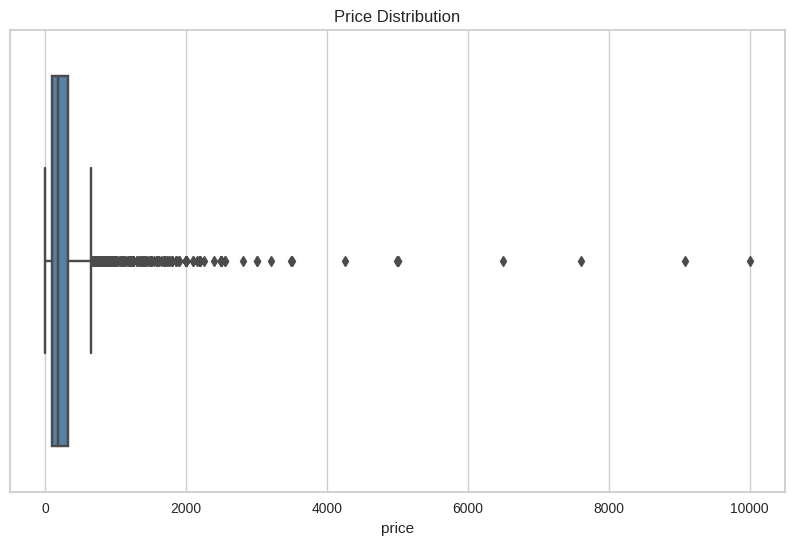

In [ ]:
#create a box plot to visualize the price distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,
            x='price',
            color = 'steelblue')
plt.title('Price Distribution')

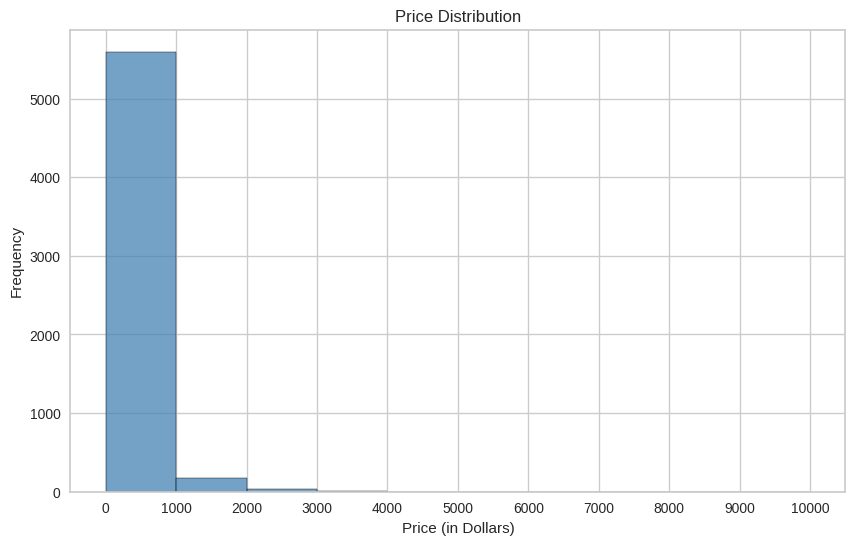

In [ ]:
#create a histogram to visualize the price distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', bins=range(0, int(df['price'].max()) + 1000, 1000), color='steelblue')
plt.title('Price Distribution')
plt.xlabel('Price (in Dollars)')
plt.ylabel('Frequency')

# x-axis labels at every $1000
plt.xticks(range(0, int(df['price'].max()) + 1000, 1000))

plt.show()

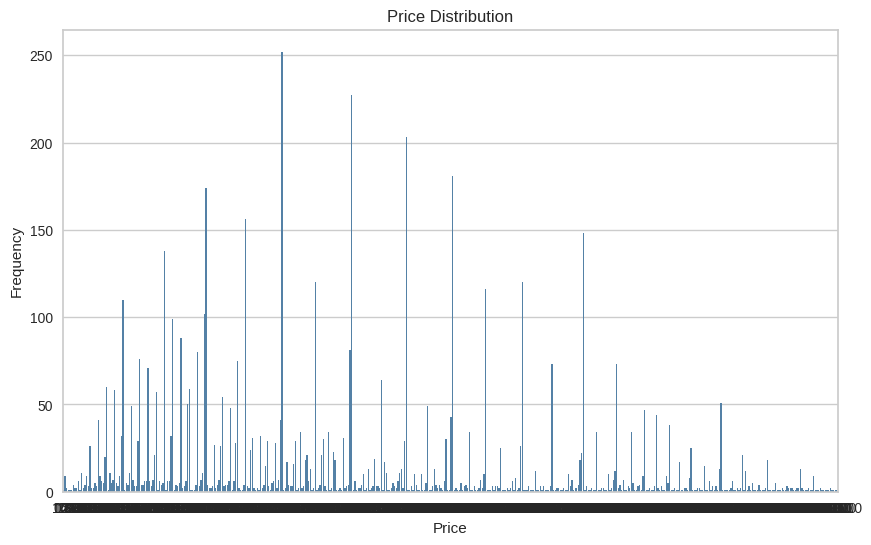

In [ ]:
#create a column chart to visualize the price distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df,
              x='price',
              color = 'steelblue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

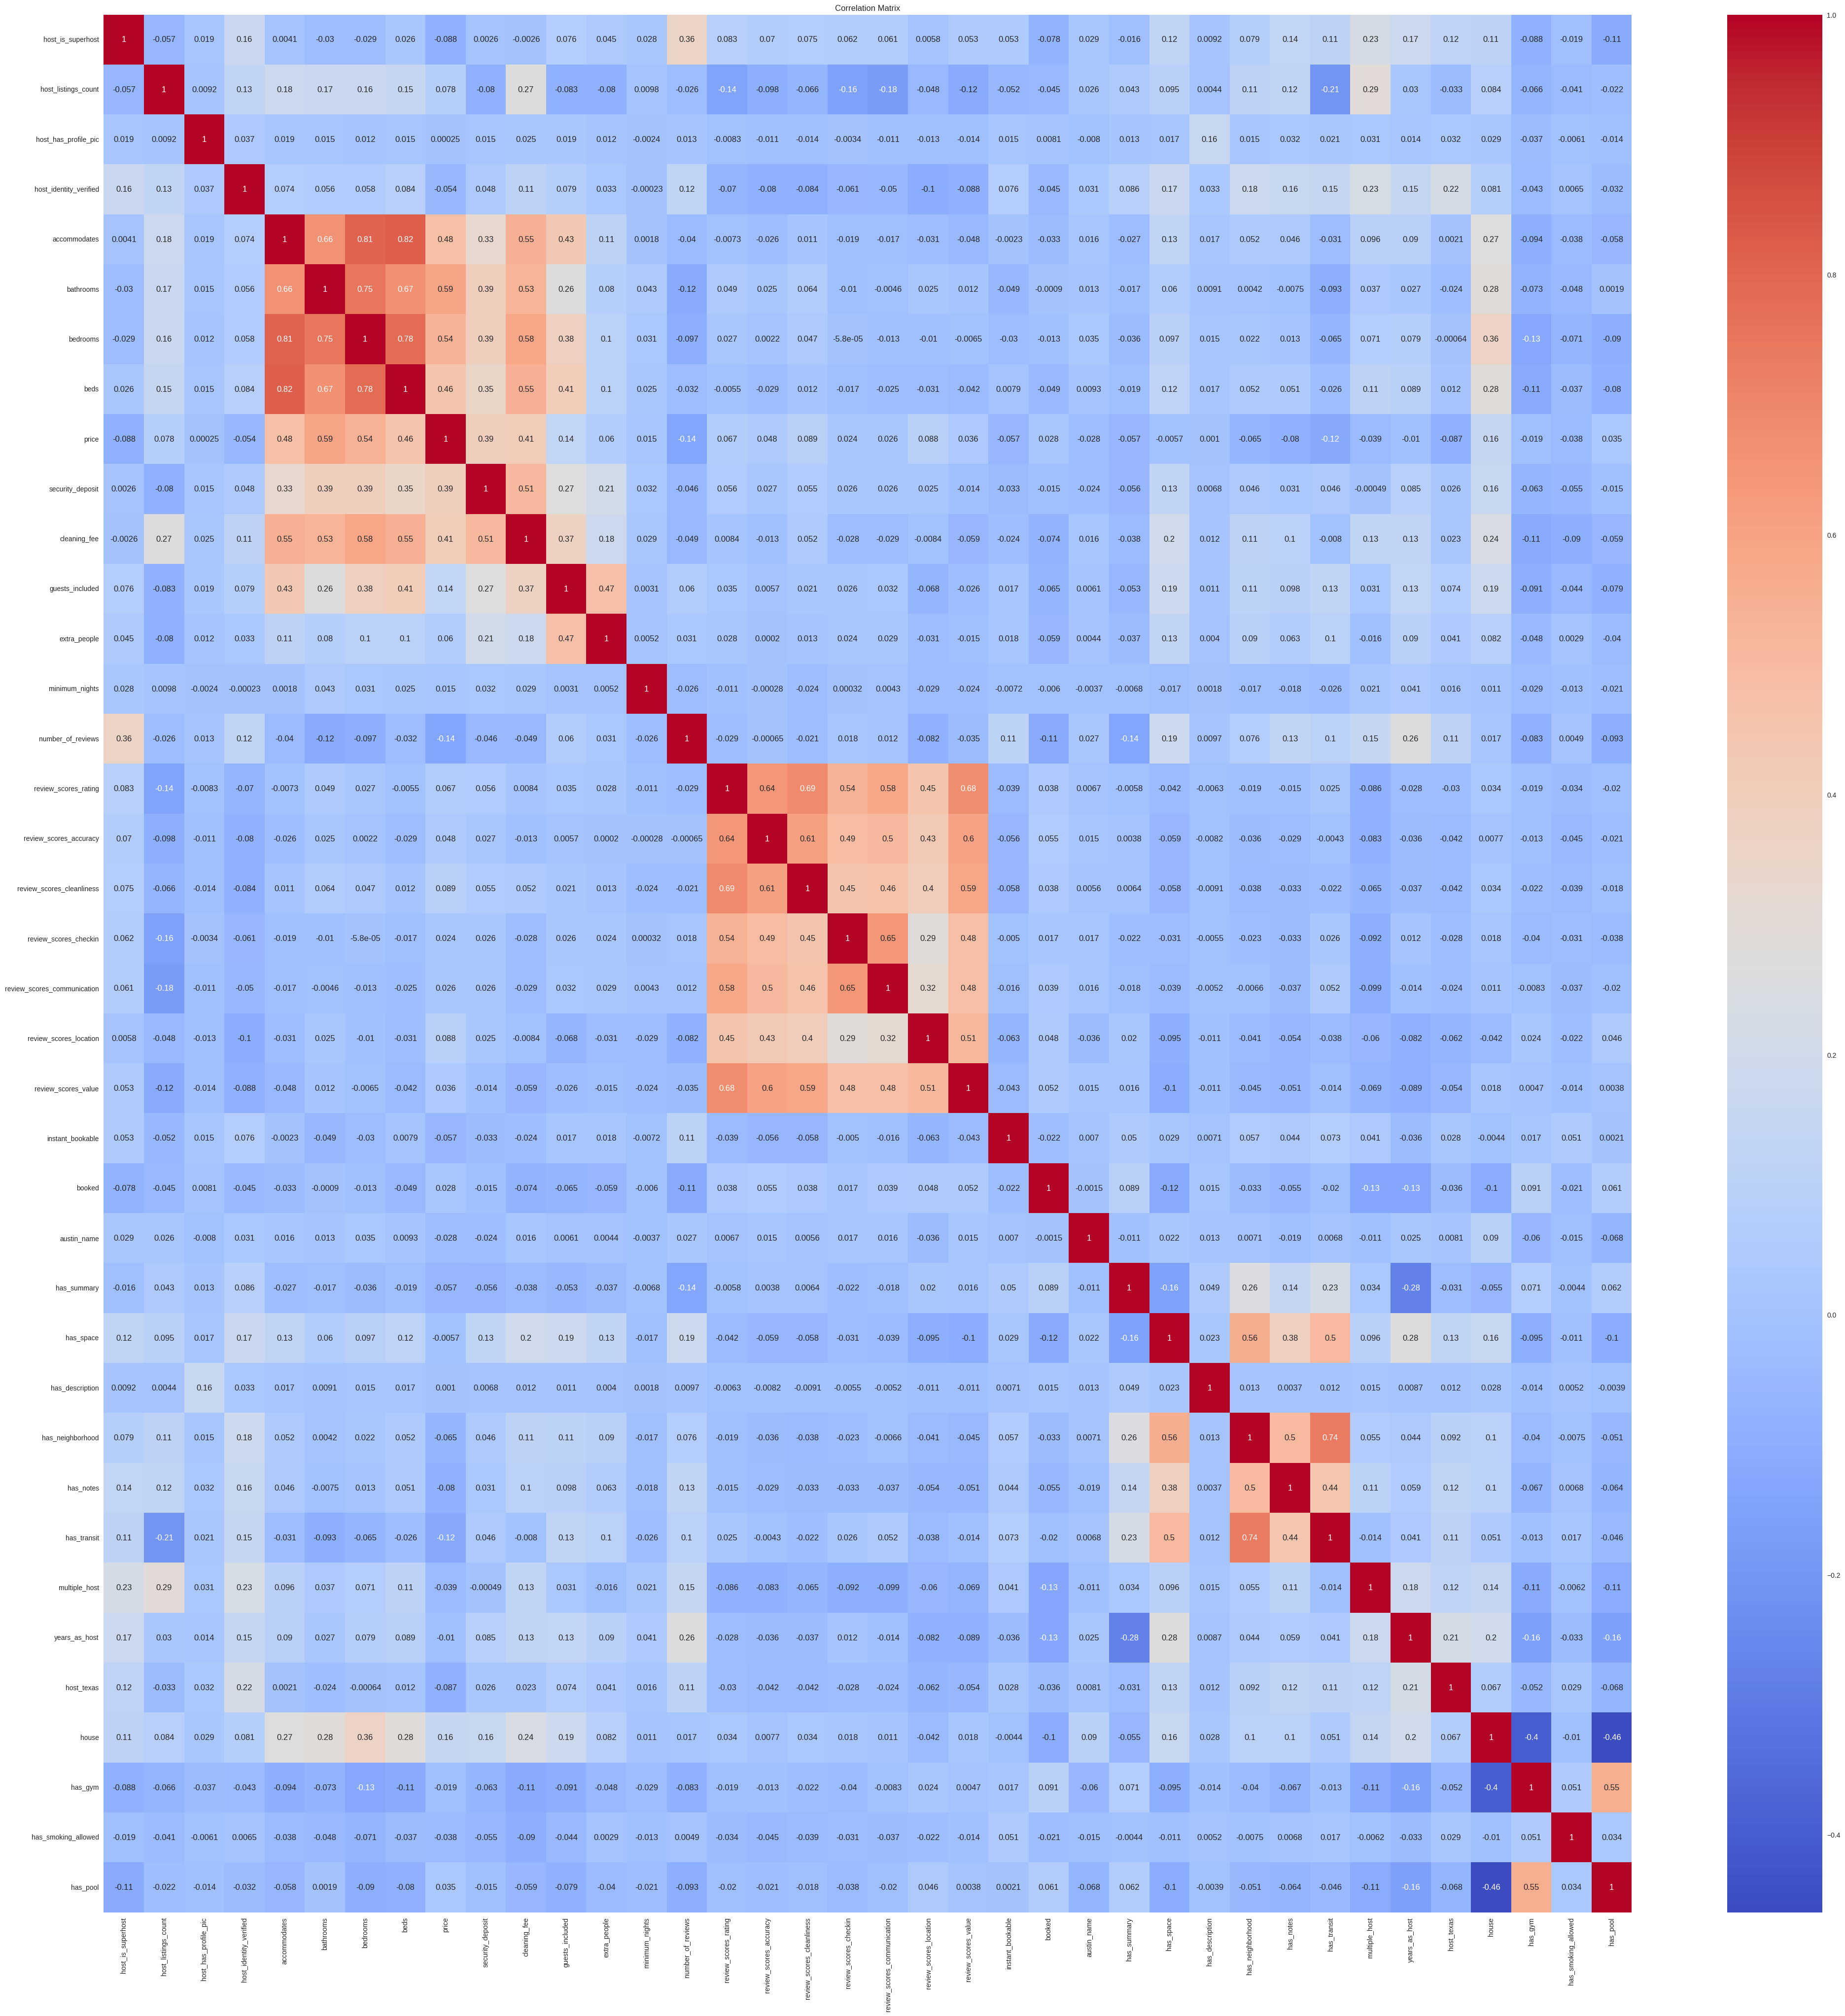

In [ ]:
#create a correlation matrix
plt.figure(figsize=(50, 50))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#see how variables are correlated with price
#calculate the correlation with the 'price' column
correlation_with_price = df.corr()['price'].sort_values(ascending=False)

#convert to df
price_cor_df = correlation_with_price.reset_index()
price_cor_df.columns = ['Variable', 'Correlation_with_Price']
price_cor_df

Variable  Correlation_with_Price
0                         price                1.000000
1                     bathrooms                0.593329
2                      bedrooms                0.541364
3                  accommodates                0.475998
4                          beds                0.456554
5                  cleaning_fee                0.411423
6              security_deposit                0.394952
7                         house                0.155151
8               guests_included                0.136708
9     review_scores_cleanliness                0.089011
10       review_scores_location                0.087792
11          host_listings_count                0.077858
12         review_scores_rating                0.067246
13                 extra_people                0.059993
14       review_scores_accuracy                0.048103
15          review_scores_value                0.036390
16                     has_pool                0.035173
17                       booked                0.027790
18  review_scores_communication                0.025539
19        review_scores_checkin                0.023844
20               minimum_nights                0.015080
21              has_description                0.001013
22         host_has_profile_pic                0.000246
23                    has_space               -0.005653
24                years_as_host               -0.010134
25                      has_gym               -0.019181
26                  austin_name               -0.027674
27          has_smoking_allowed               -0.037965
28                multiple_host               -0.038890
29       host_identity_verified               -0.053545
30             instant_bookable               -0.056712
31                  has_summary               -0.056938
32             has_neighborhood               -0.065013
33                    has_notes               -0.079640
34                   host_texas               -0.087250
35            host_is_superhost               -0.088174
36                  has_transit               -0.120748
37            number_of_reviews               -0.136936

##Linear Regression

In [ ]:
#regress with all variables
X = df.drop('price', axis=1)
y = df['price']
#X = sm.add_constant(X)
price_reg = sm.OLS(y, X).fit()

print(price_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.624
Model:                            OLS   Adj. R-squared (uncentered):              0.622
Method:                 Least Squares   F-statistic:                              259.9
Date:                Thu, 14 Dec 2023   Prob (F-statistic):                        0.00
Time:                        04:27:21   Log-Likelihood:                         -41517.
No. Observations:                5820   AIC:                                  8.311e+04
Df Residuals:                    5783   BIC:                                  8.335e+04
Df Model:                          37                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [ ]:
#regression with variables having absolute correlation value > 0.1
list1 = ['bathrooms', 'bedrooms', 'accommodates', 'beds', 'cleaning_fee', 'security_deposit', 'house', 'guests_included', 'has_transit', 'number_of_reviews']

X = df[list1]
y = df['price']
#X = sm.add_constant(X)
price_reg2 = sm.OLS(y, X).fit()

print(price_reg2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.608
Model:                            OLS   Adj. R-squared (uncentered):              0.607
Method:                 Least Squares   F-statistic:                              901.7
Date:                Thu, 14 Dec 2023   Prob (F-statistic):                        0.00
Time:                        04:27:21   Log-Likelihood:                         -41641.
No. Observations:                5820   AIC:                                  8.330e+04
Df Residuals:                    5810   BIC:                                  8.337e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [ ]:
#regression adding and removing variables until good
list1 = ['bathrooms', 'bedrooms', 'accommodates', 'cleaning_fee', 'security_deposit', 'house', 'guests_included', 'has_transit', 'number_of_reviews', 'review_scores_cleanliness']

X = df[list1]
y = df['price']
#X = sm.add_constant(X)
price_reg3 = sm.OLS(y, X).fit()

print(price_reg3.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.611
Model:                            OLS   Adj. R-squared (uncentered):              0.610
Method:                 Least Squares   F-statistic:                              912.0
Date:                Thu, 14 Dec 2023   Prob (F-statistic):                        0.00
Time:                        04:27:21   Log-Likelihood:                         -41620.
No. Observations:                5820   AIC:                                  8.326e+04
Df Residuals:                    5810   BIC:                                  8.333e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

##K Means Clustering

In [ ]:
#Standardize Data
dfcolumns = df.columns.values.tolist()

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=dfcolumns)


df_scaled.head()

host_is_superhost  host_listings_count  host_has_profile_pic  \
0          -0.407266            -0.195220              0.047315   
1          -0.407266            -0.195220              0.047315   
2          -0.407266            -0.177089              0.047315   
3          -0.407266            -0.177089              0.047315   
4          -0.407266             5.244168              0.047315   

   host_identity_verified  accommodates  bathrooms  bedrooms      beds  \
0               -1.438617      0.598434   1.324165 -0.649074  0.478390   
1                0.695112     -0.888232  -1.909029 -0.649074 -0.735046   
2                0.695112     -0.888232   0.030888 -0.649074 -0.735046   
3                0.695112     -0.888232   0.030888 -0.649074 -0.735046   
4                0.695112      0.598434   0.677526  1.110000  0.478390   

      price  security_deposit  ...  has_neighborhood  has_notes  has_transit  \
0  0.033879         -0.522164  ...          0.795323  -0.839491     0.818251   
1 -0.464160          2.127474  ...          0.795323  -0.839491     0.818251   
2 -0.461683         -0.522164  ...         -1.257351  -0.839491    -1.222118   
3 -0.461683         -0.522164  ...         -1.257351  -0.839491    -1.222118   
4  0.774743         -0.522164  ...          0.795323  -0.839491    -1.222118   

   multiple_host  years_as_host  host_texas     house   has_gym  \
0      -0.660551       1.802101    0.414407  0.802249 -0.379596   
1      -0.660551      -0.983888    0.414407 -1.246496 -0.379596   
2       1.513887      -1.428059    0.414407  0.802249 -0.379596   
3       1.513887      -1.428059    0.414407  0.802249 -0.379596   
4       1.513887      -1.087843   -2.413085  0.802249 -0.379596   

   has_smoking_allowed  has_pool  
0            -0.226915 -0.588991  
1            -0.226915 -0.588991  
2            -0.226915  1.697819  
3            -0.226915  1.697819  
4            -0.226915 -0.588991  

[5 rows x 38 columns]

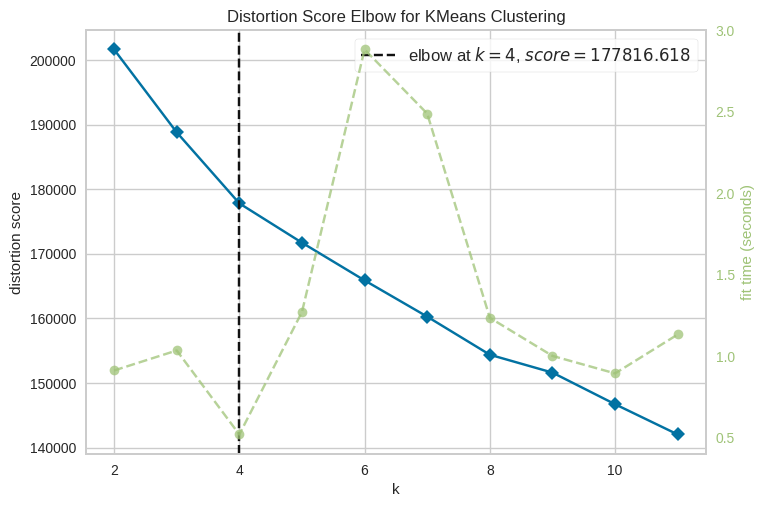

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# set the model type to k-means
model = KMeans()

# generate an elbow plot for k = 2 to 12 clusters using the scaled data
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(df_scaled)
visualizer.show()

In [ ]:
# Create an instance of KMeans with the desired value of k and fit to the scaled data
kmeans = KMeans(n_clusters=4, random_state=904) #choosing 4 clusters based on elbow
kmclus=kmeans.fit(df_scaled)

clusters = kmeans.fit_predict(df_scaled)

#append cluster to original data
cluster_df= df
cluster_df['cluster']=clusters

cluster_df.info()

# Evaluate cluster sizes to insure that they are similar
print(cluster_df['cluster'].value_counts())

# Examine the means of each variable by cluster
df_desc = cluster_df.groupby('cluster').mean()
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
     print(df_desc)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 5820 entries, 0 to 5834
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            5820 non-null   int64  
 1   host_listings_count          5820 non-null   float64
 2   host_has_profile_pic         5820 non-null   int64  
 3   host_identity_verified       5820 non-null   int64  
 4   accommodates                 5820 non-null   int64  
 5   bathrooms                    5820 non-null   float64
 6   bedrooms                     5820 non-null   float64
 7   beds                         5820 non-null   float64
 8   price                        5820 non-null   float64
 9   security_deposit             5820 non-null   float64
 10  cleaning_fee                 5820 non-null   float64
 11  guests_included              5820 non-null   int64  
 12  extra_people                 5820 non-null   float64
 13  minimum_nights    

In [ ]:
cluster_df.columns

Index(['host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'booked', 'austin_name',
       'has_summary', 'has_space', 'has_description', 'has_neighborhood',
       'has_notes', 'has_transit', 'multiple_host', 'years_as_host',
       'host_texas', 'house', 'has_gym', 'has_smoking_allowed', 'has_pool',
       'cluster'],
      dtype='object')

price


<Figure size 800x400 with 0 Axes>

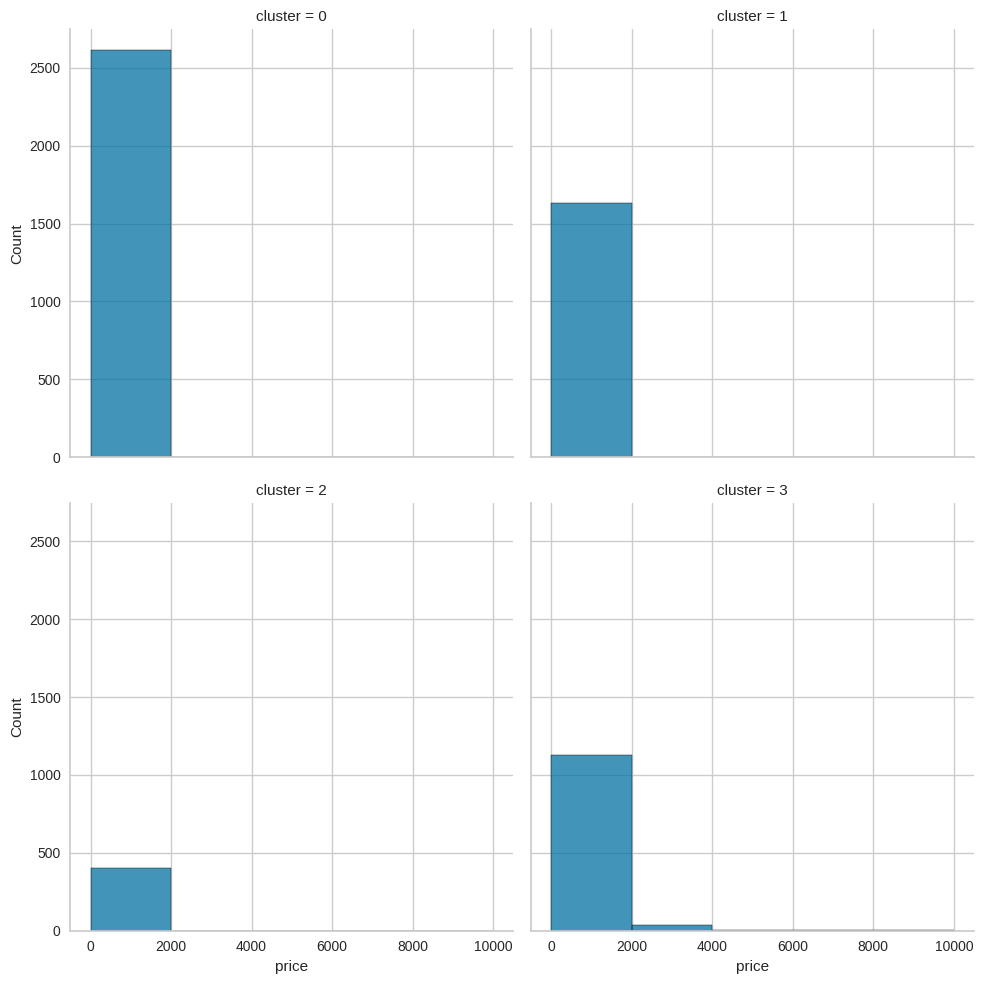

host_is_superhost


<Figure size 800x400 with 0 Axes>

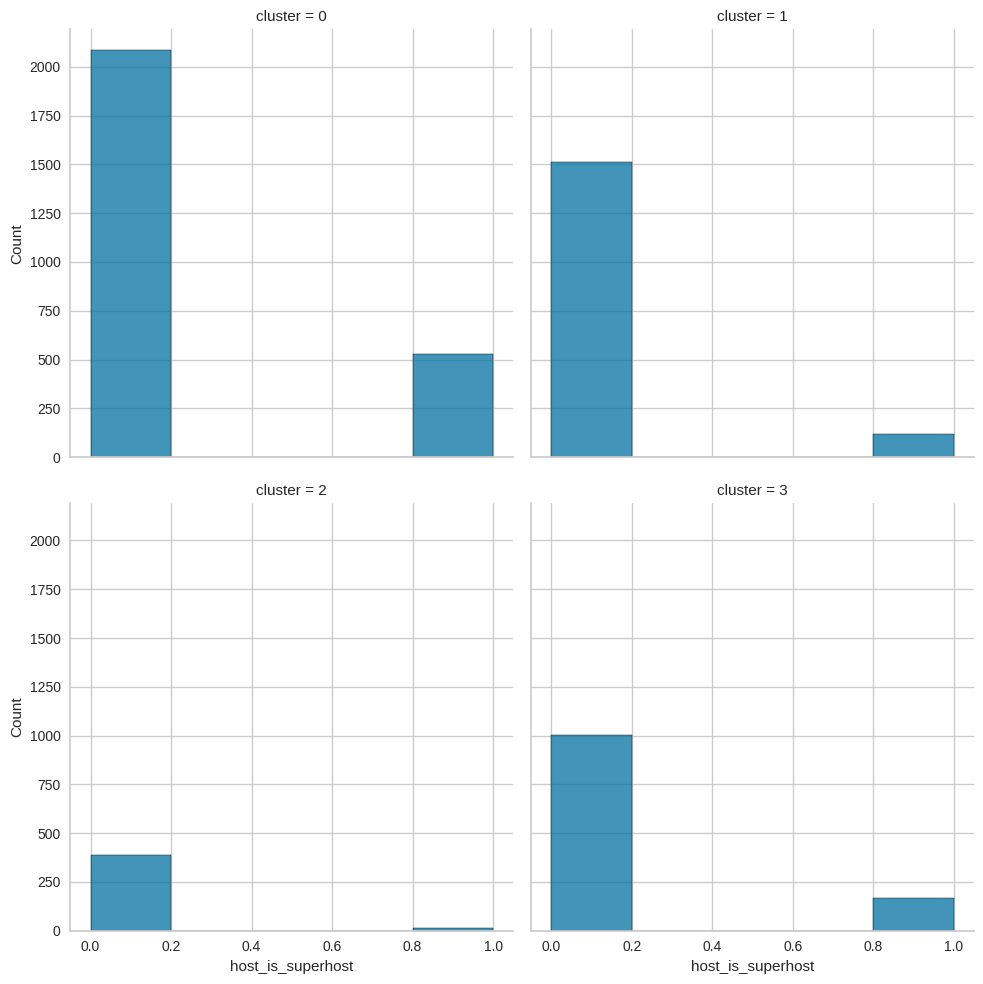

host_listings_count


<Figure size 800x400 with 0 Axes>

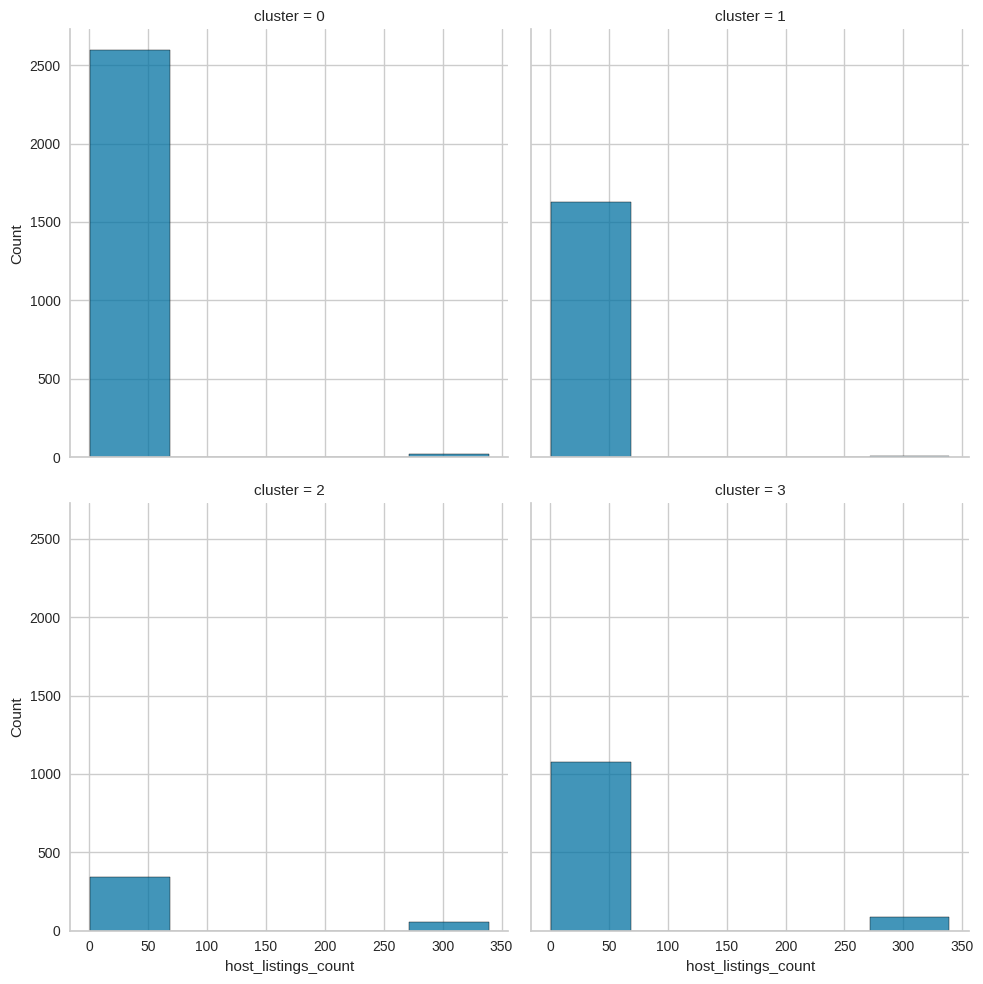

host_has_profile_pic


<Figure size 800x400 with 0 Axes>

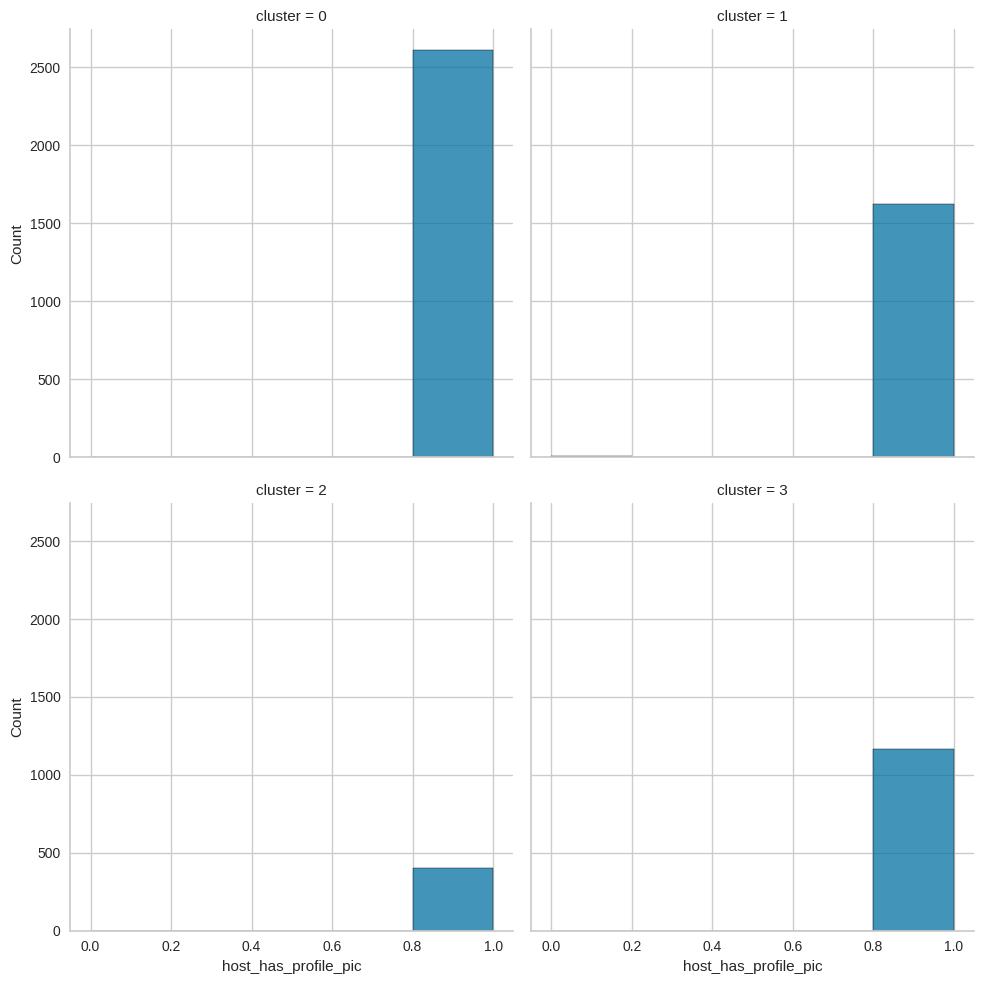

host_identity_verified


<Figure size 800x400 with 0 Axes>

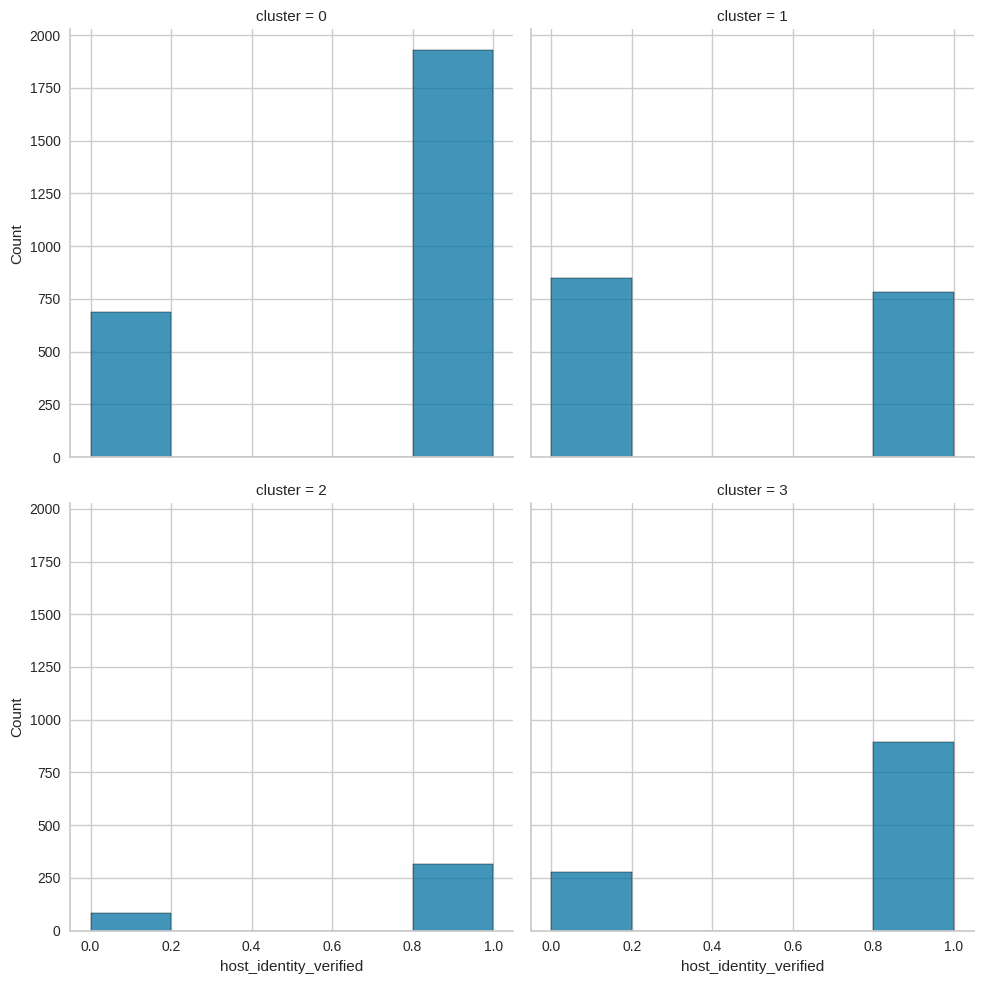

accommodates


<Figure size 800x400 with 0 Axes>

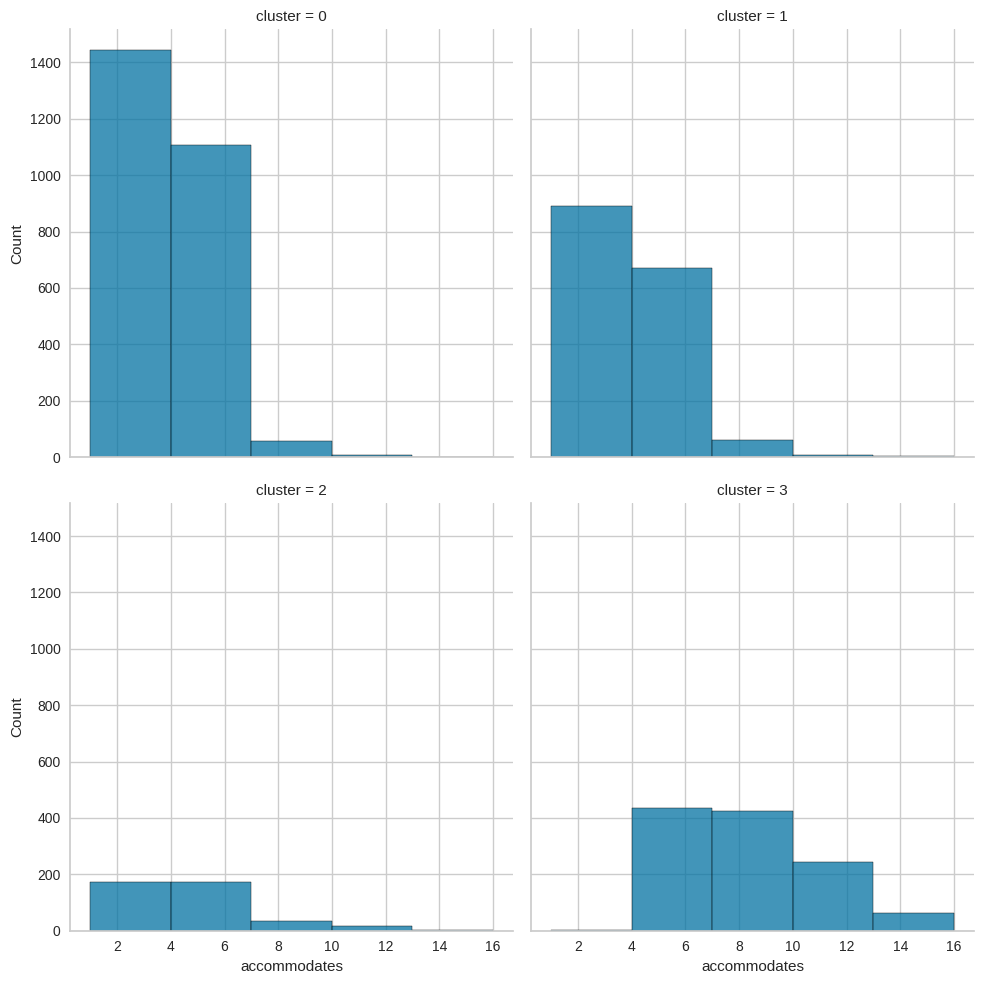

bathrooms


<Figure size 800x400 with 0 Axes>

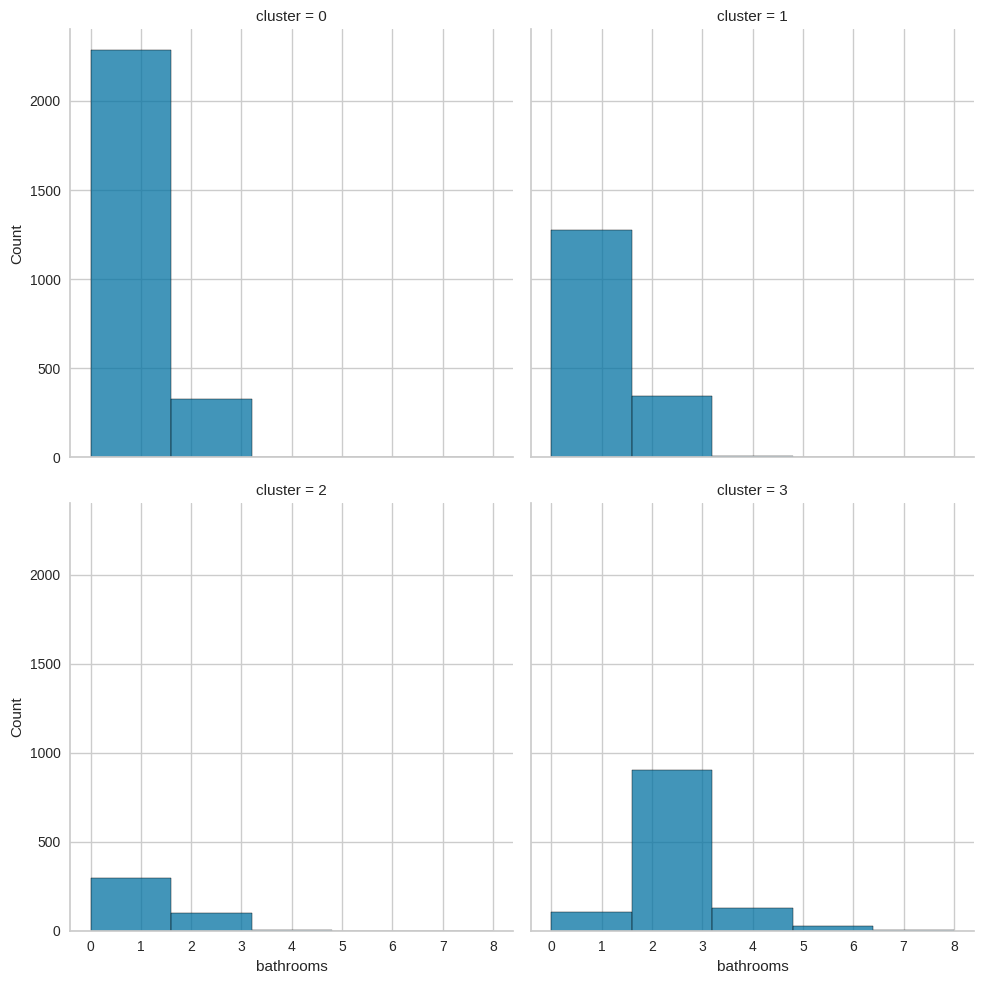

bedrooms


<Figure size 800x400 with 0 Axes>

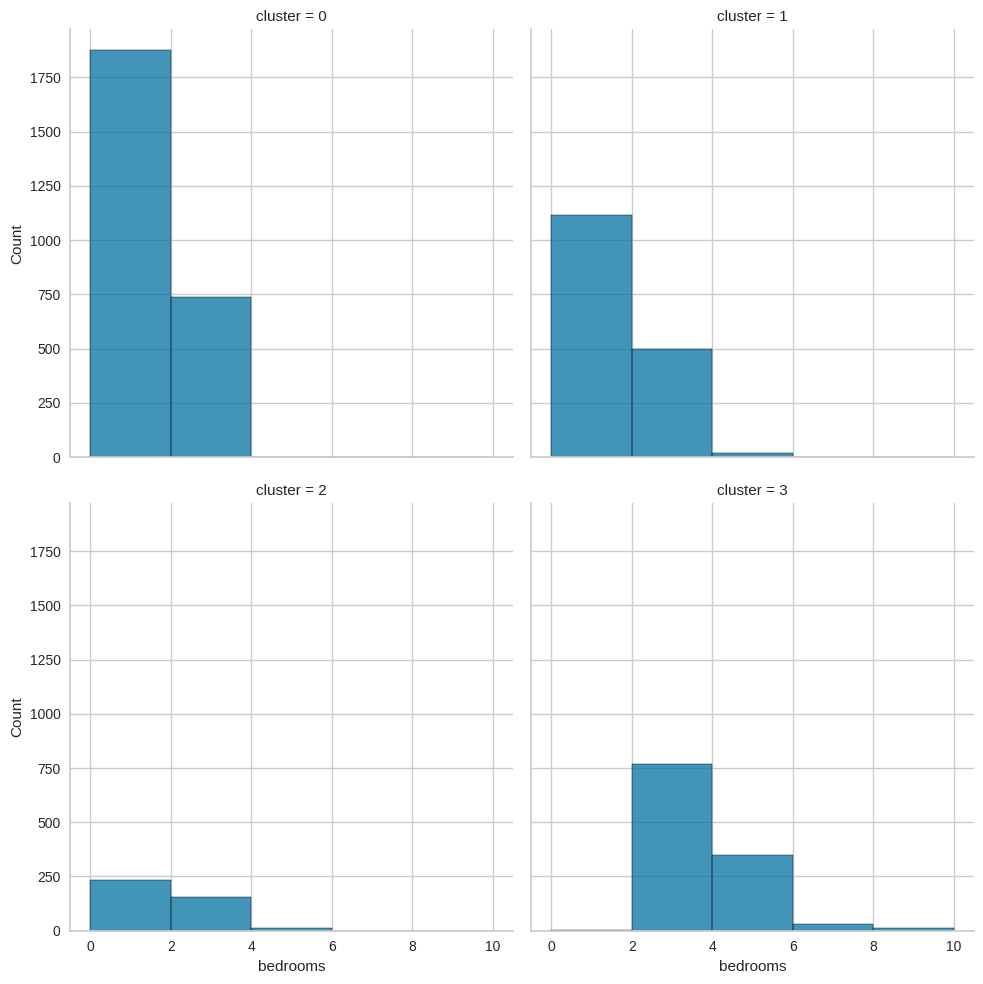

beds


<Figure size 800x400 with 0 Axes>

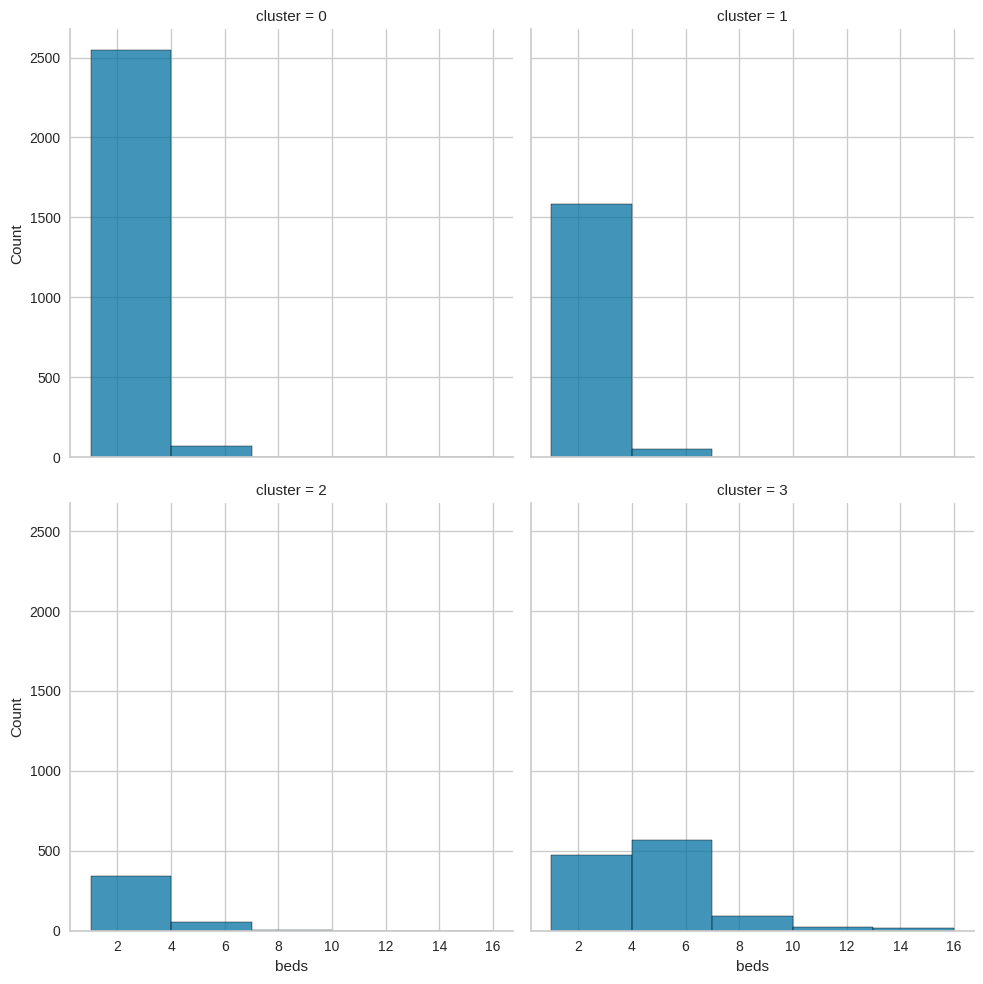

security_deposit


<Figure size 800x400 with 0 Axes>

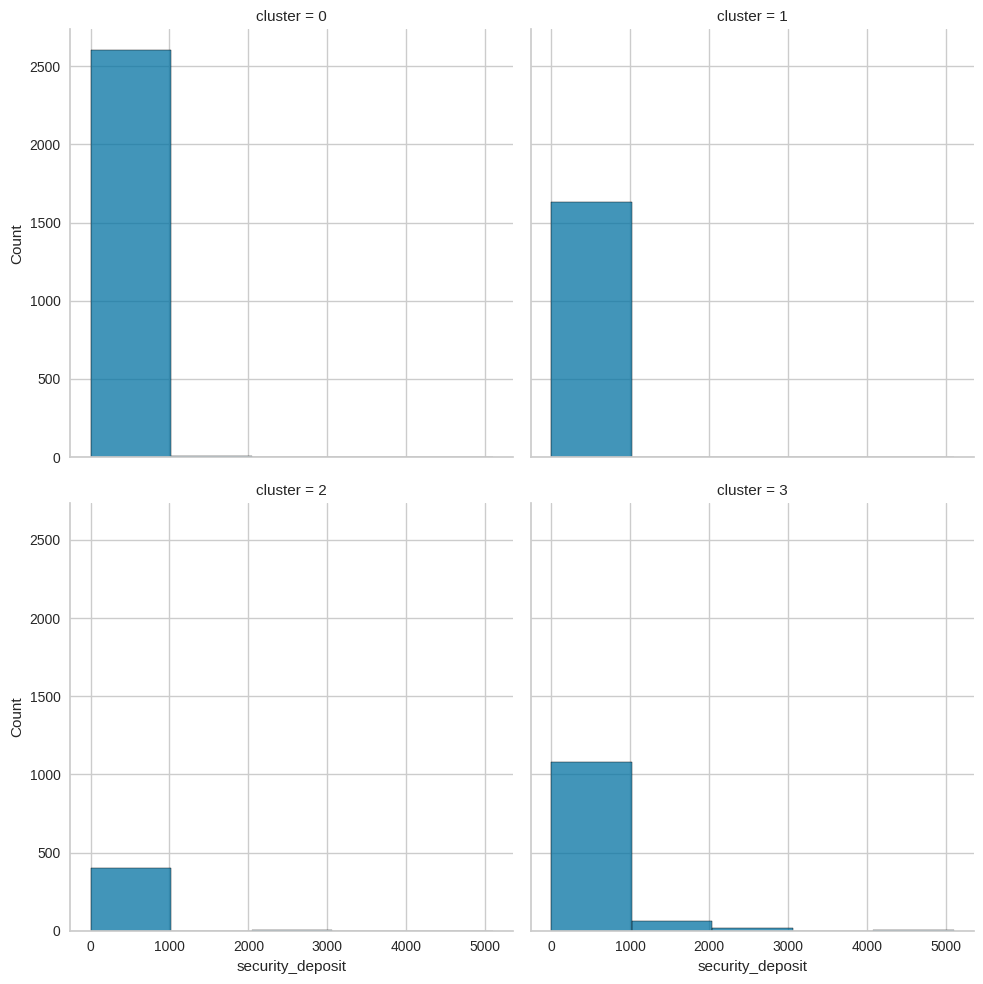

cleaning_fee


<Figure size 800x400 with 0 Axes>

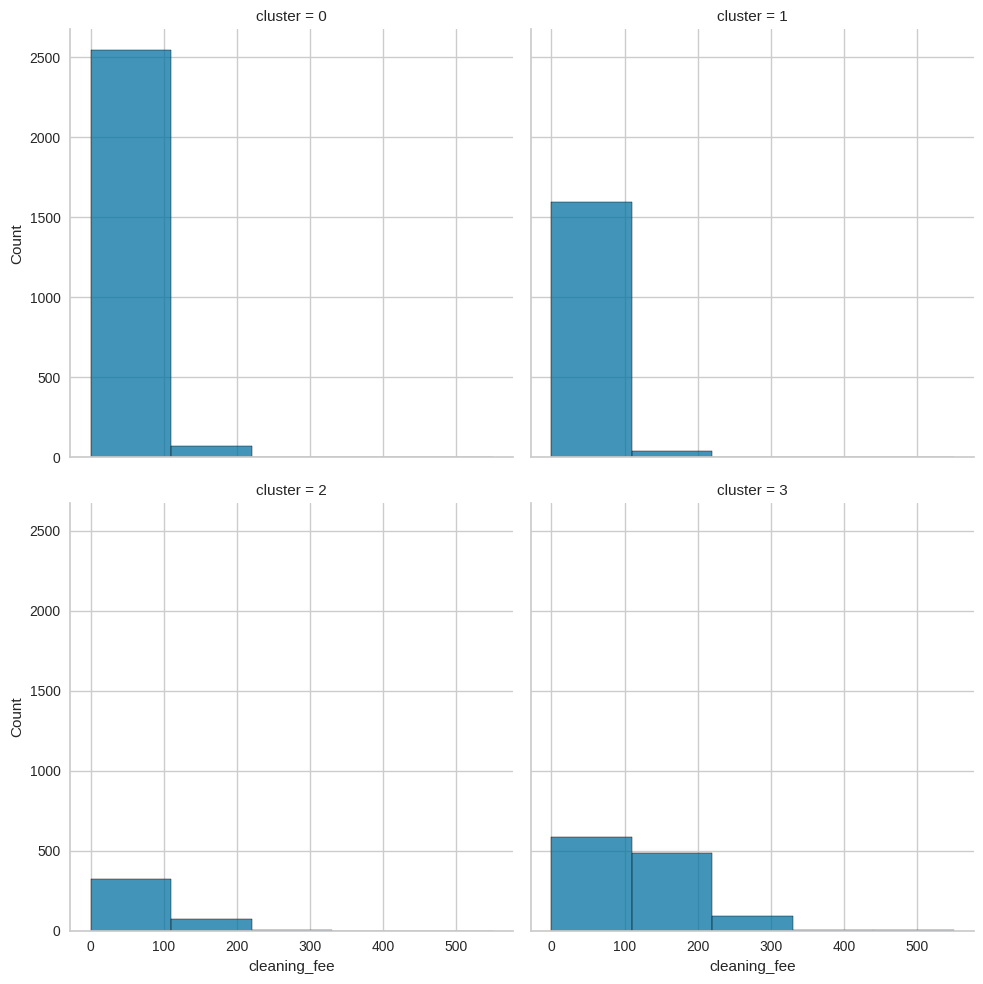

guests_included


<Figure size 800x400 with 0 Axes>

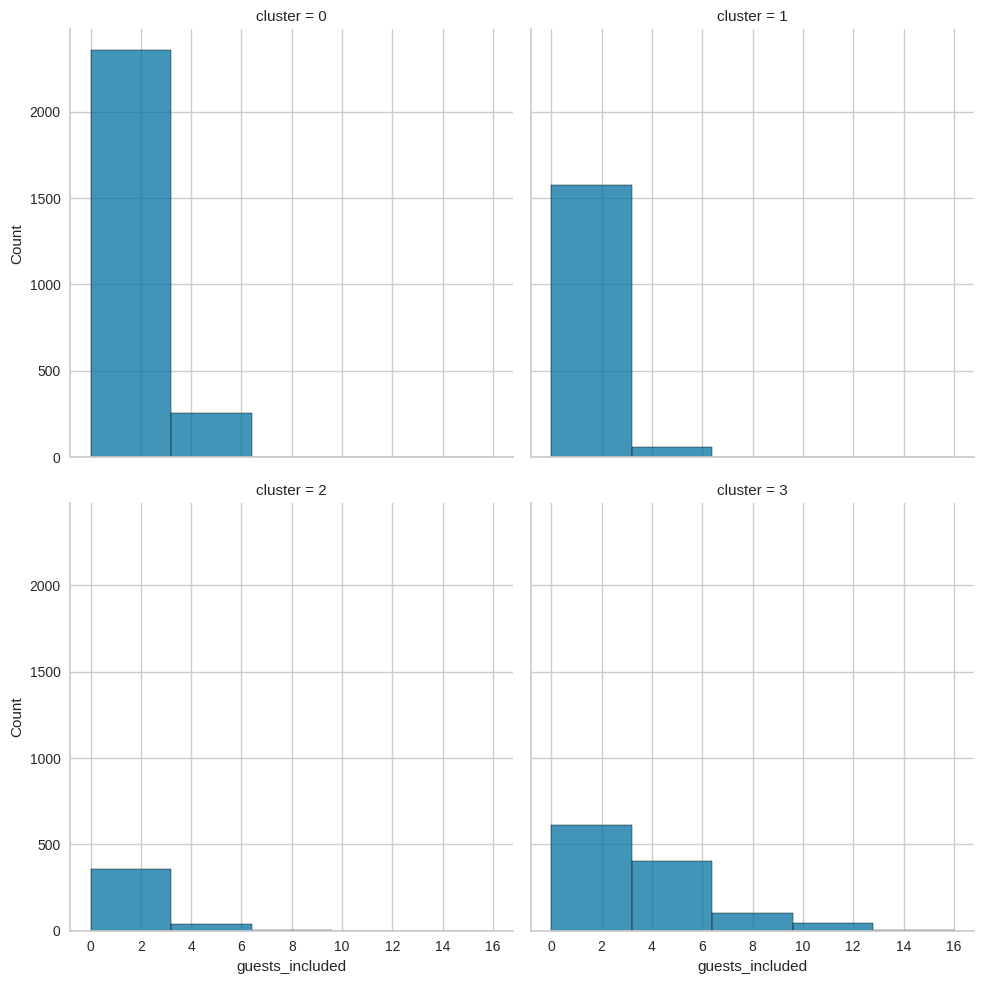

extra_people


<Figure size 800x400 with 0 Axes>

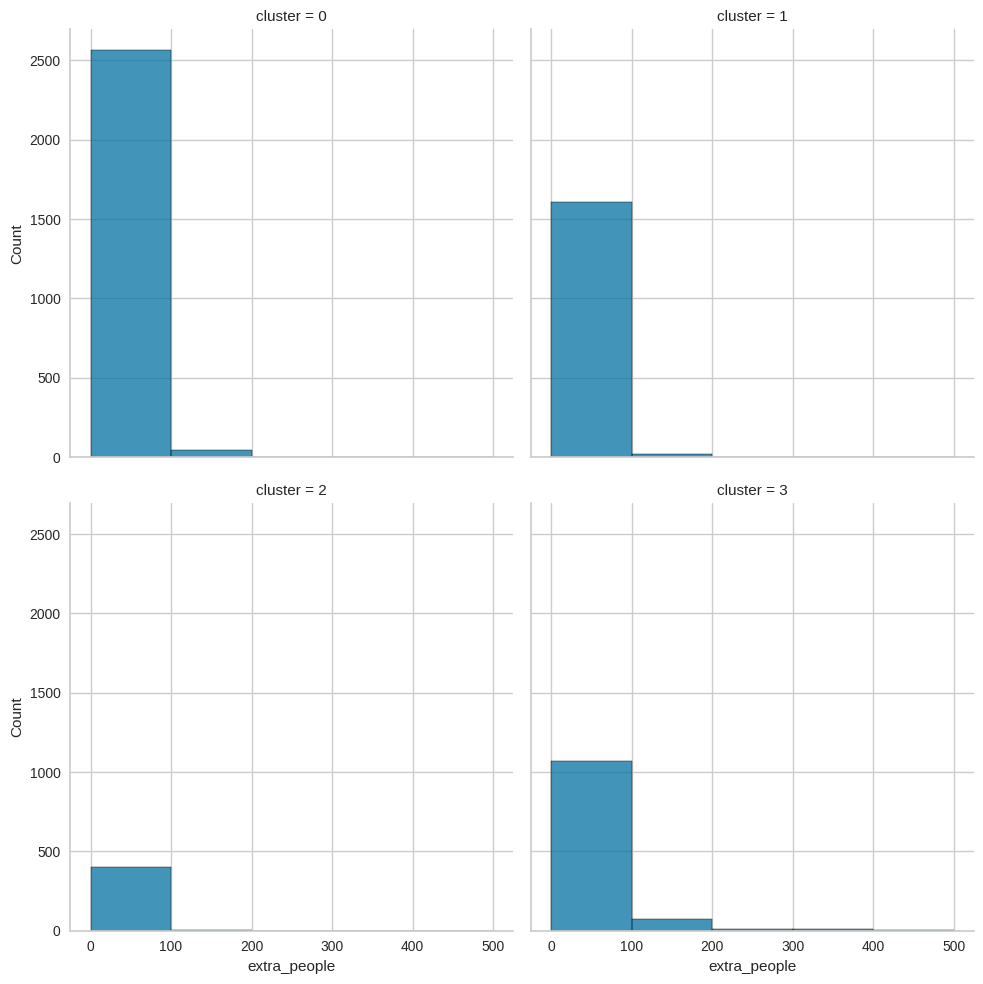

minimum_nights


<Figure size 800x400 with 0 Axes>

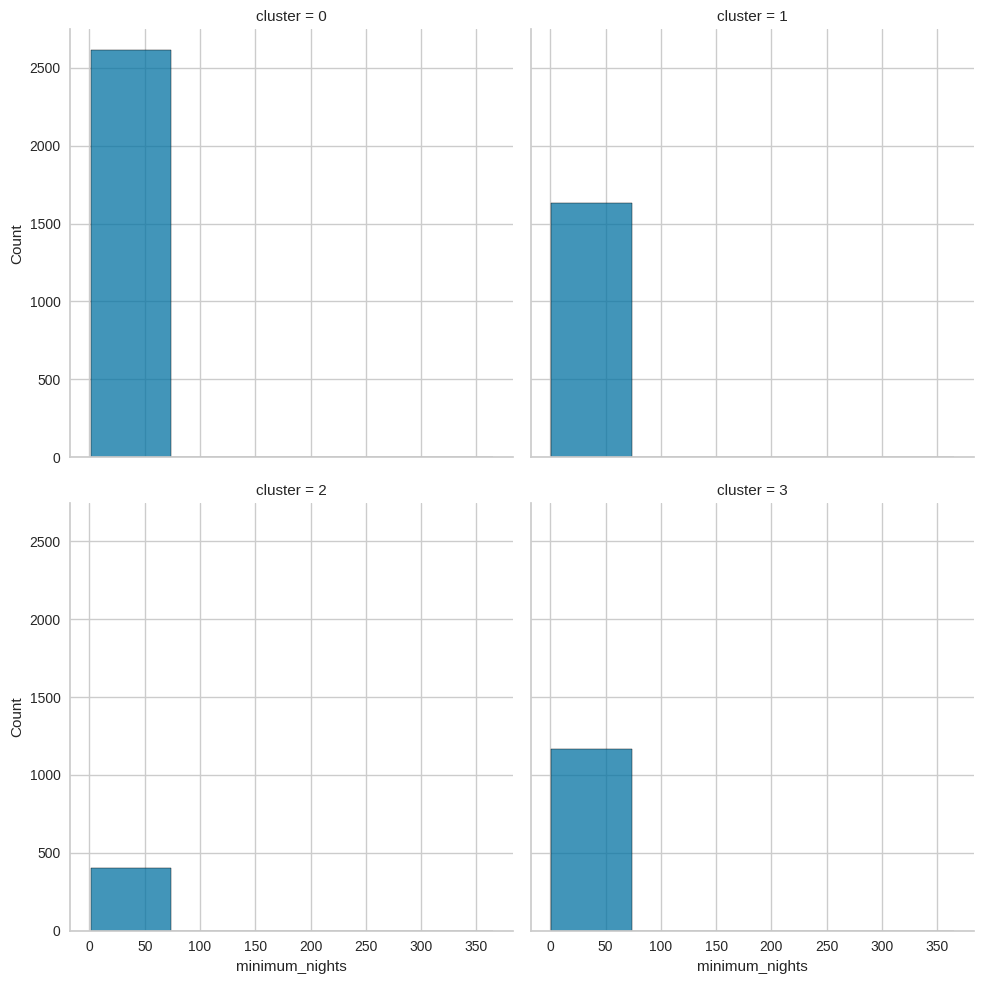

number_of_reviews


<Figure size 800x400 with 0 Axes>

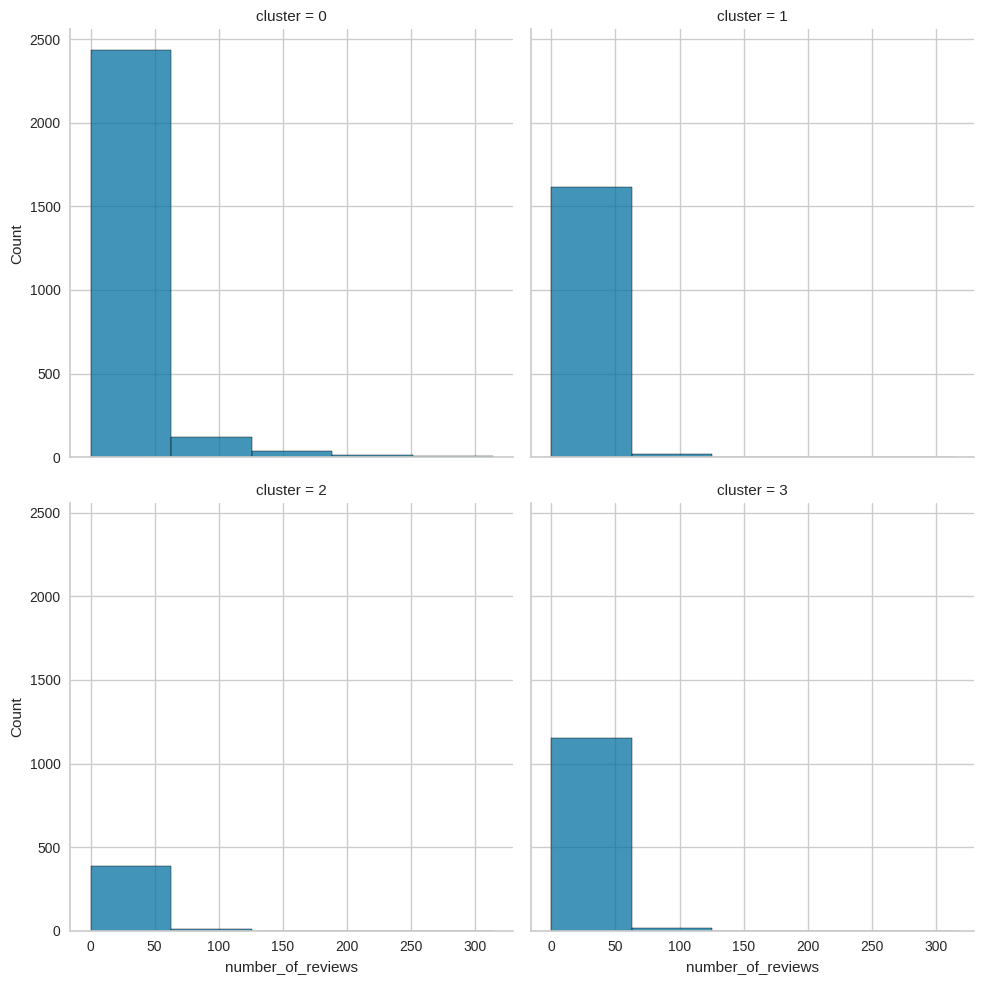

review_scores_rating


<Figure size 800x400 with 0 Axes>

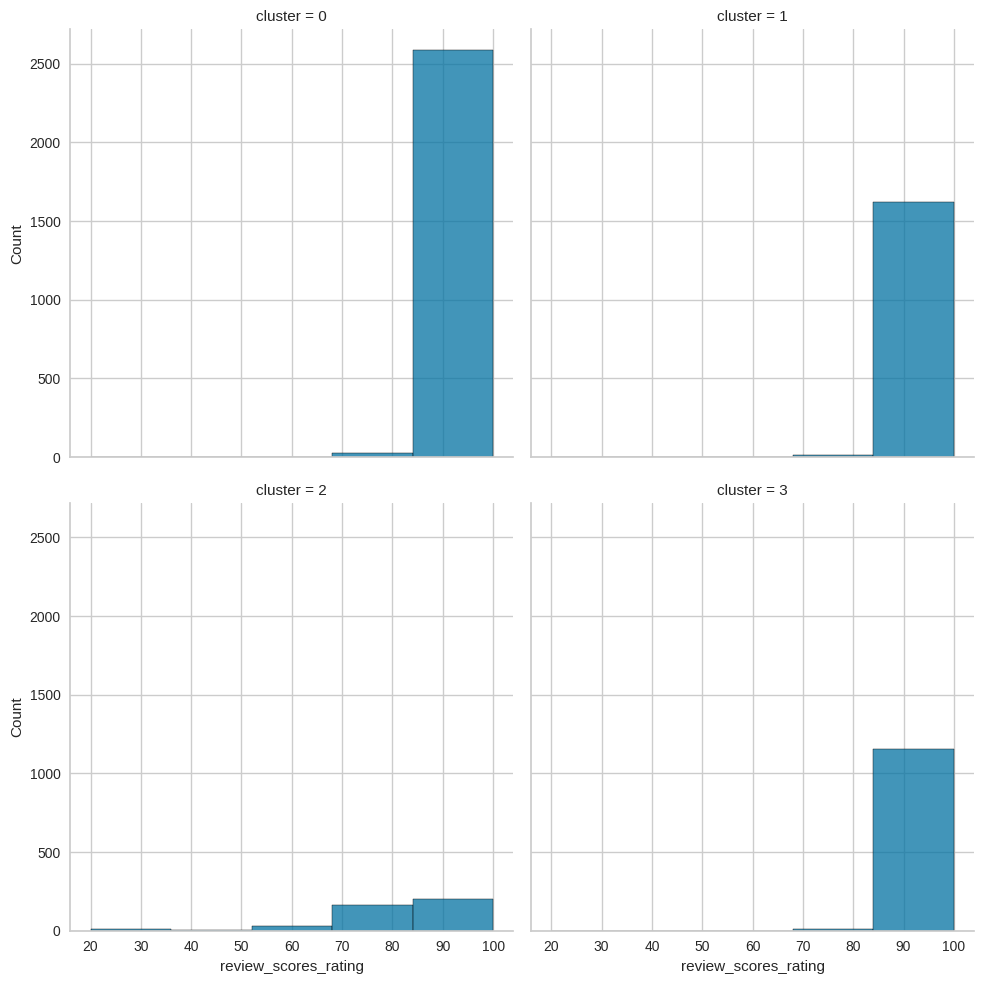

review_scores_accuracy


<Figure size 800x400 with 0 Axes>

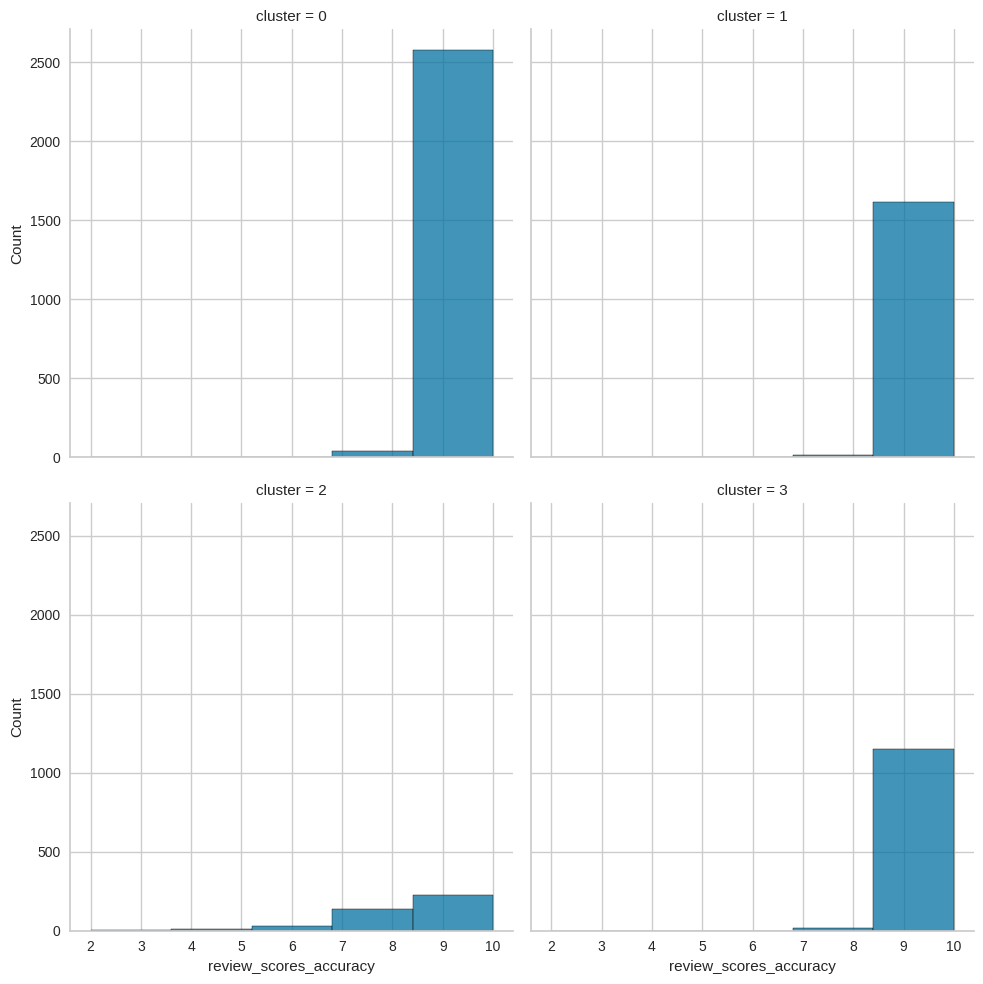

review_scores_cleanliness


<Figure size 800x400 with 0 Axes>

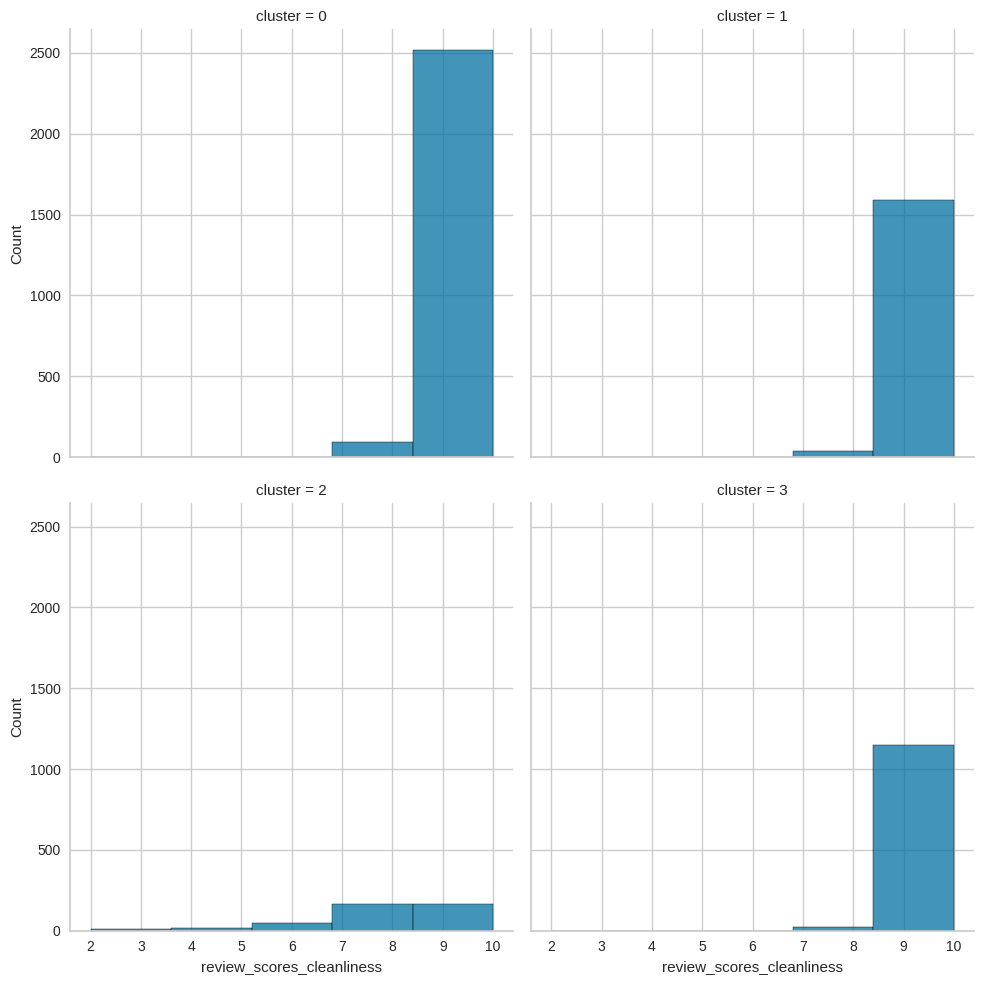

review_scores_checkin


<Figure size 800x400 with 0 Axes>

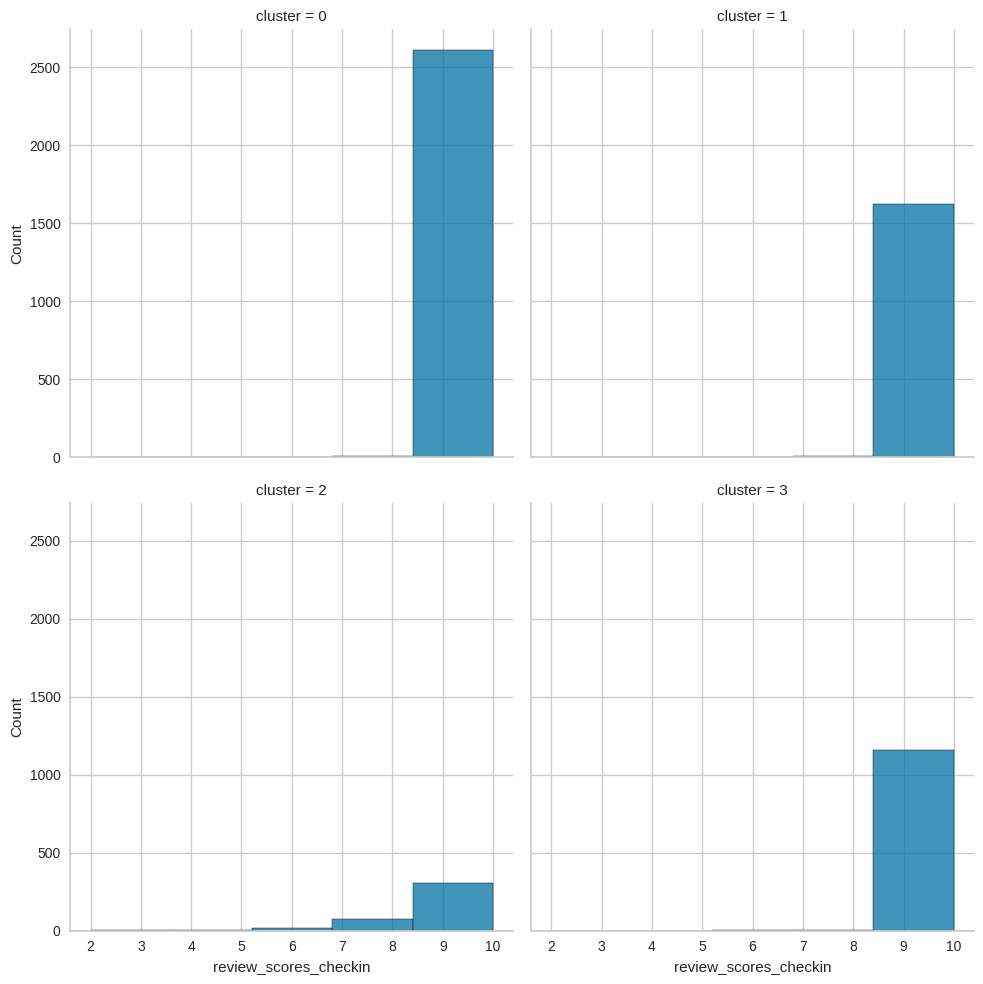

review_scores_communication


<Figure size 800x400 with 0 Axes>

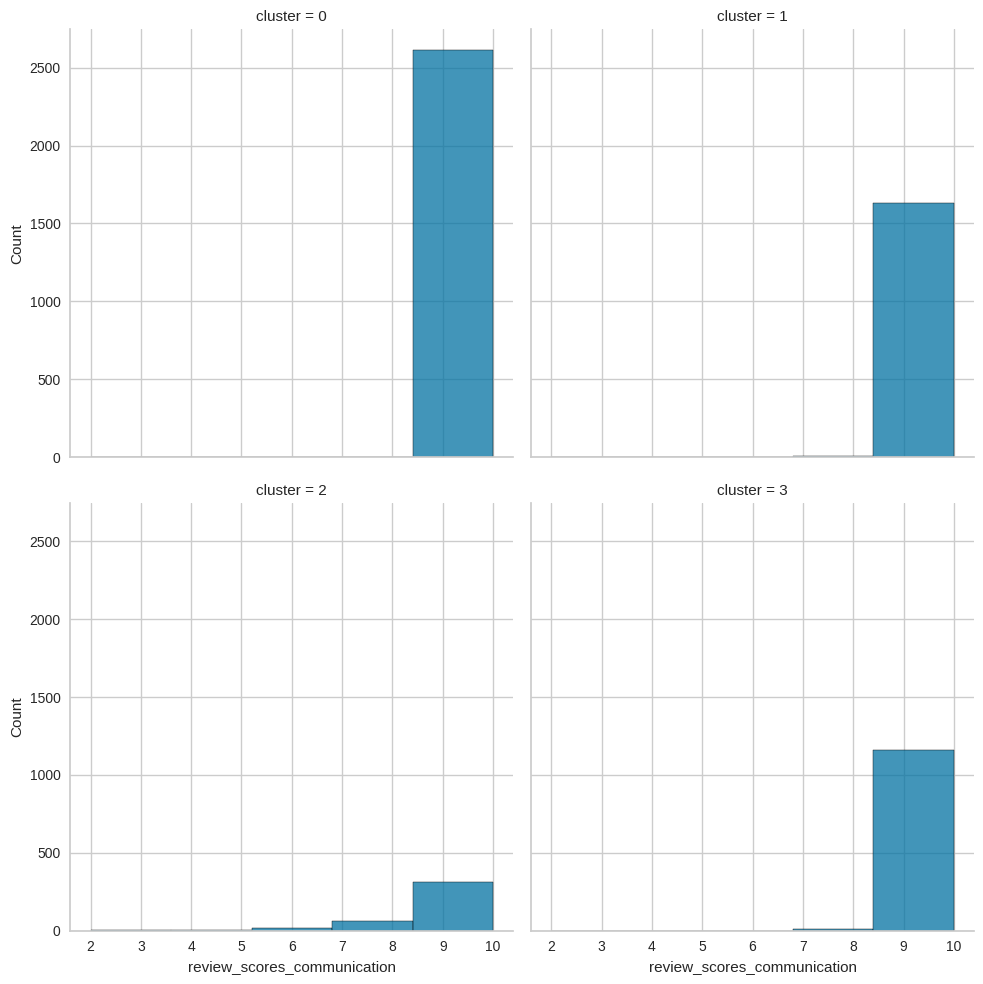

review_scores_location


<Figure size 800x400 with 0 Axes>

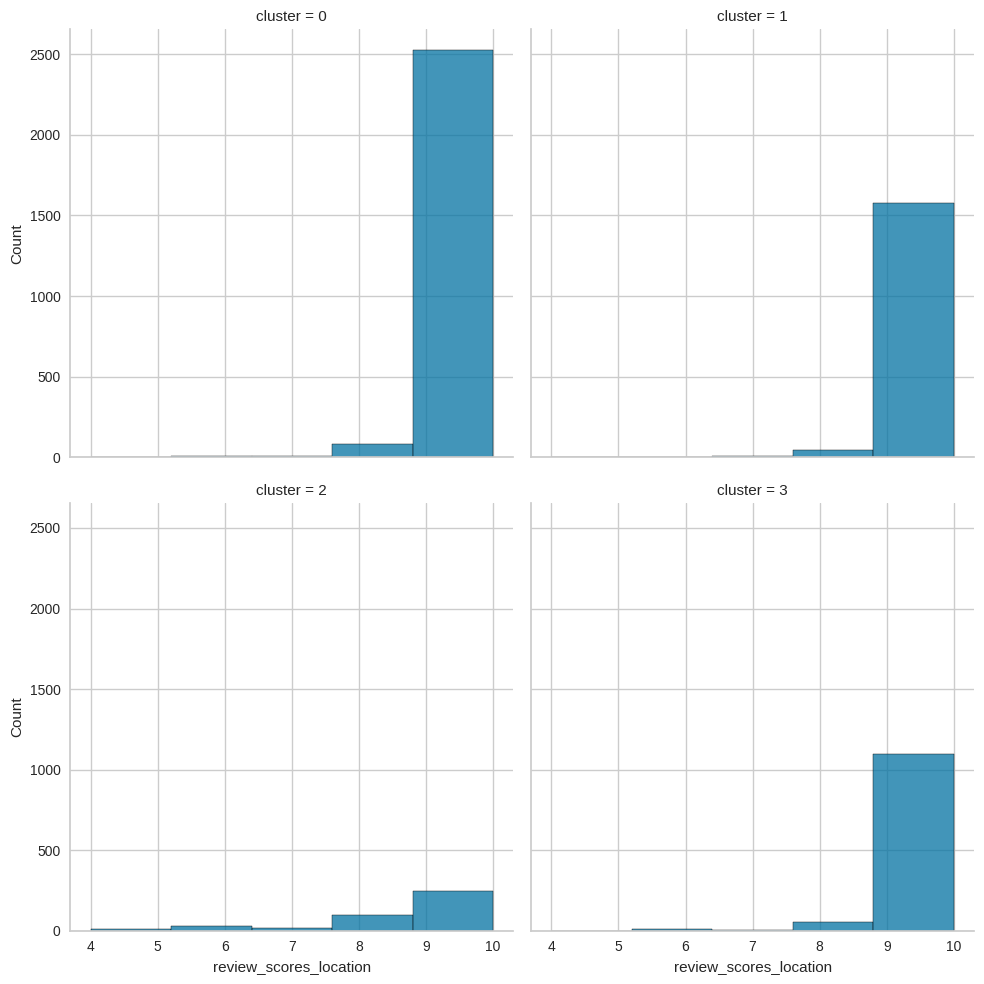

review_scores_value


<Figure size 800x400 with 0 Axes>

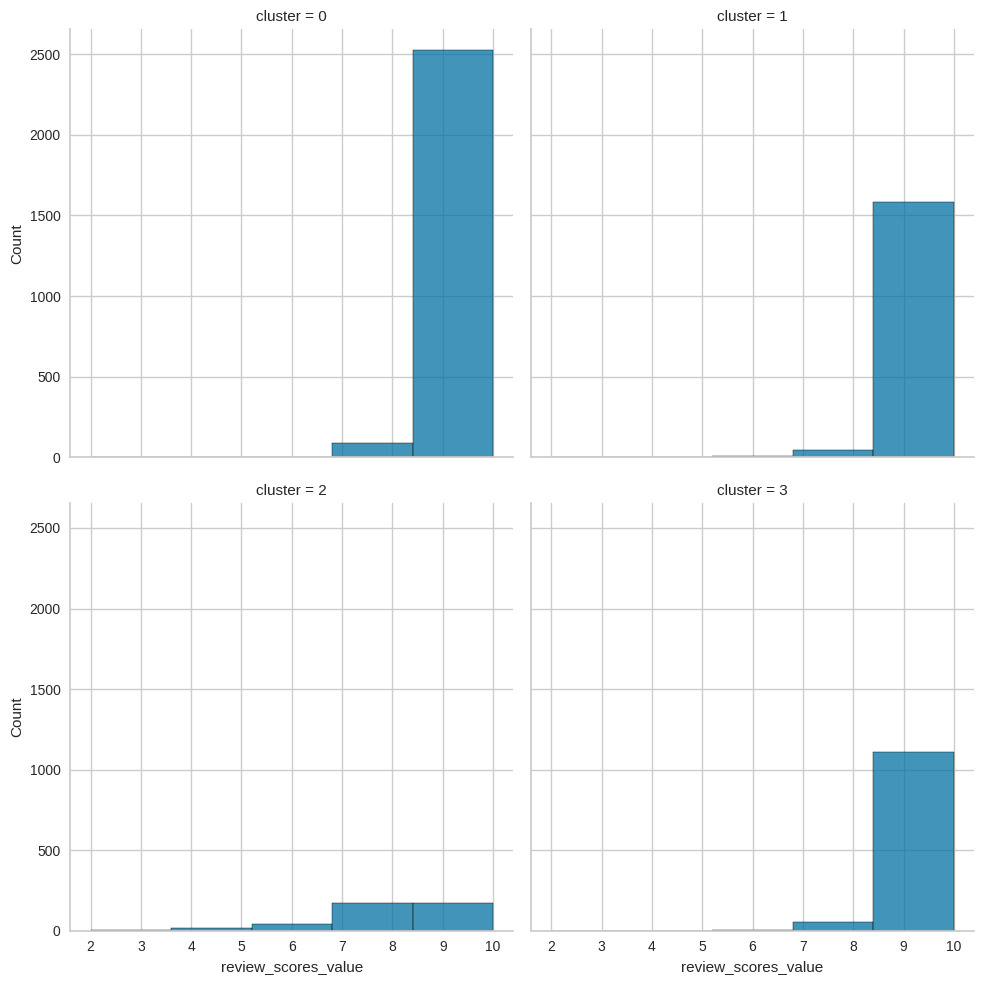

instant_bookable


<Figure size 800x400 with 0 Axes>

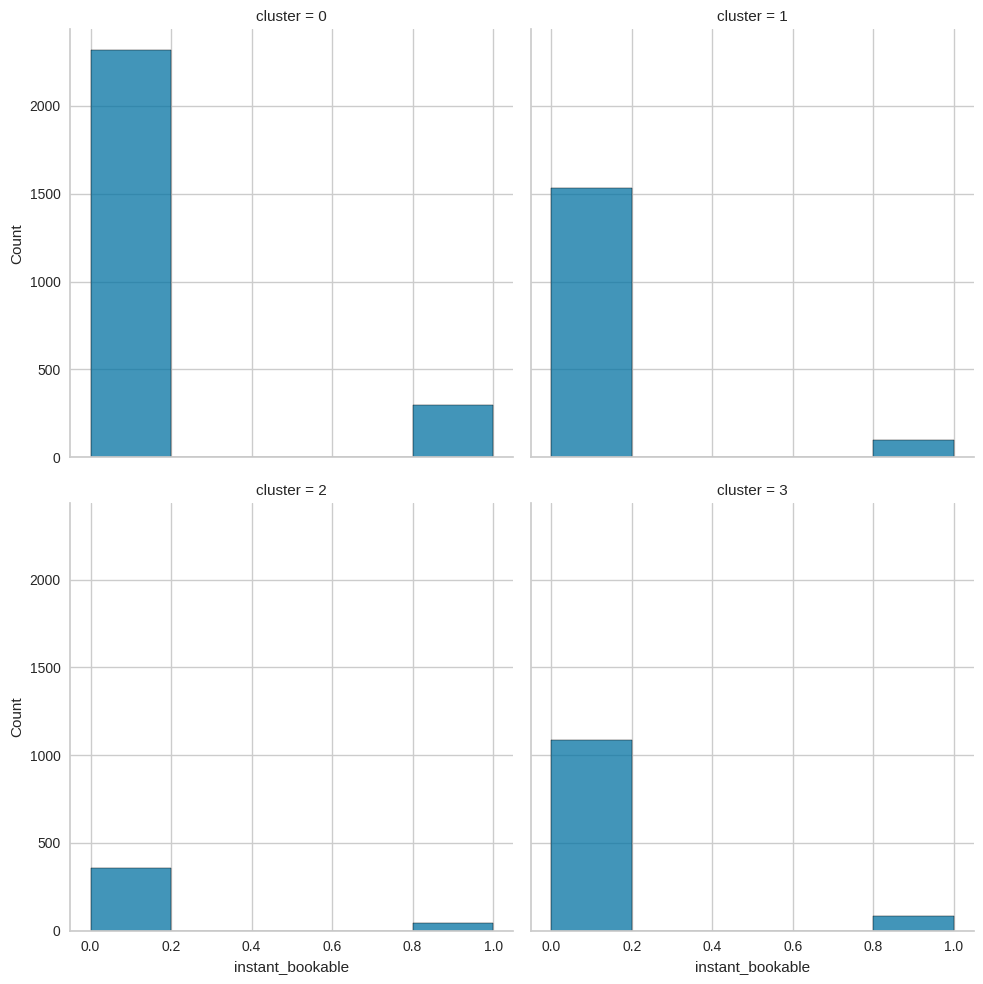

booked


<Figure size 800x400 with 0 Axes>

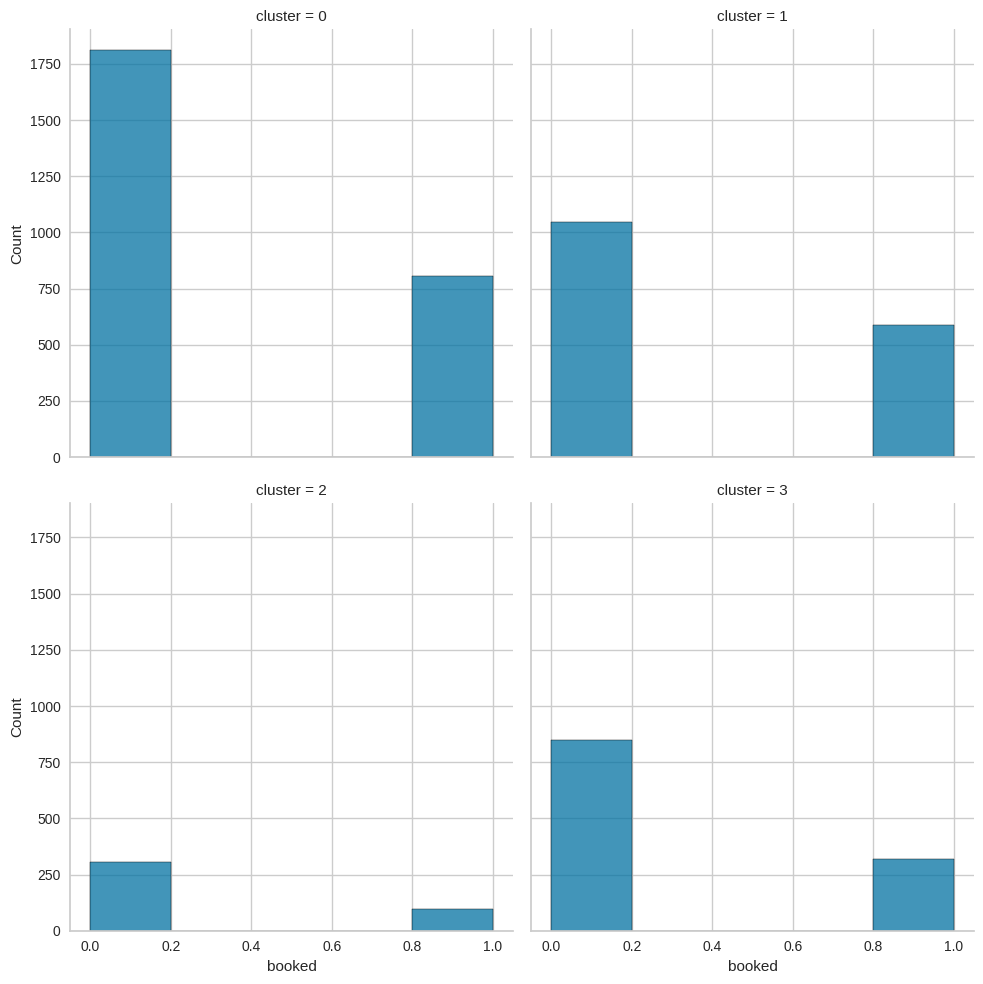

austin_name


<Figure size 800x400 with 0 Axes>

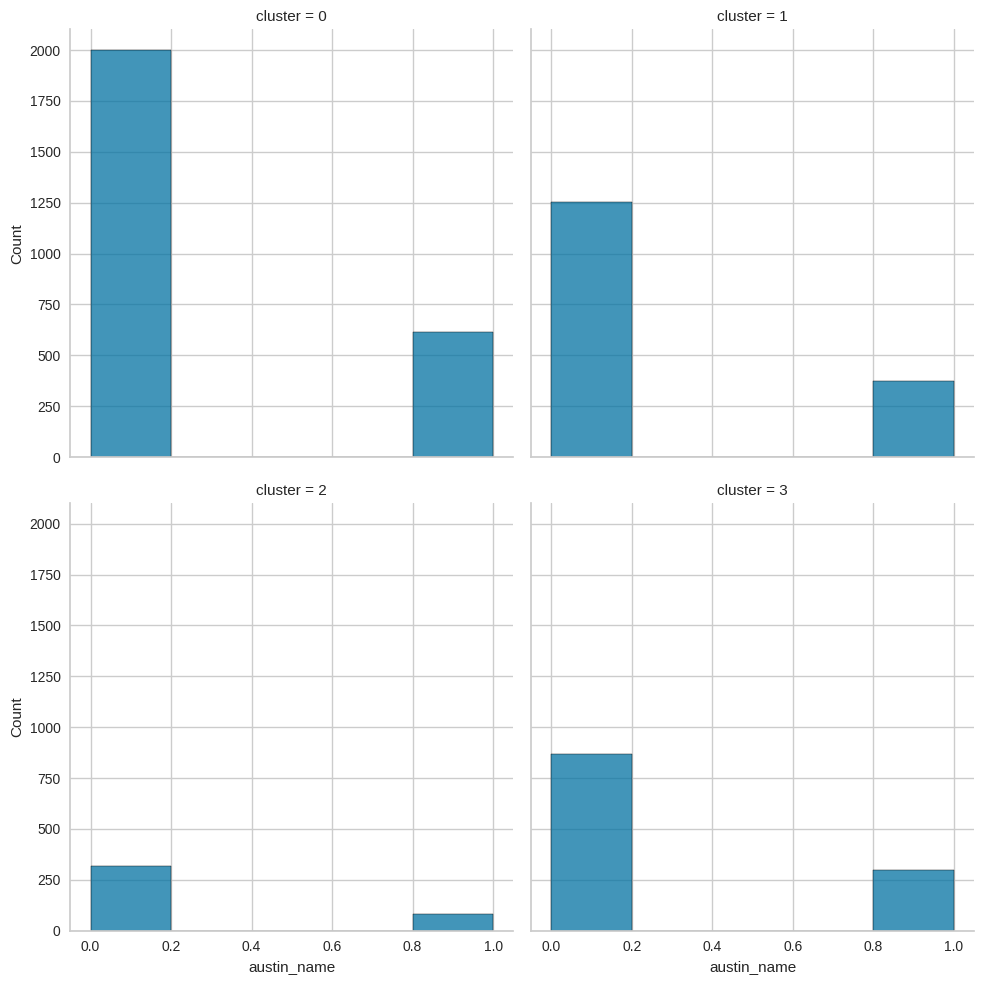

has_summary


<Figure size 800x400 with 0 Axes>

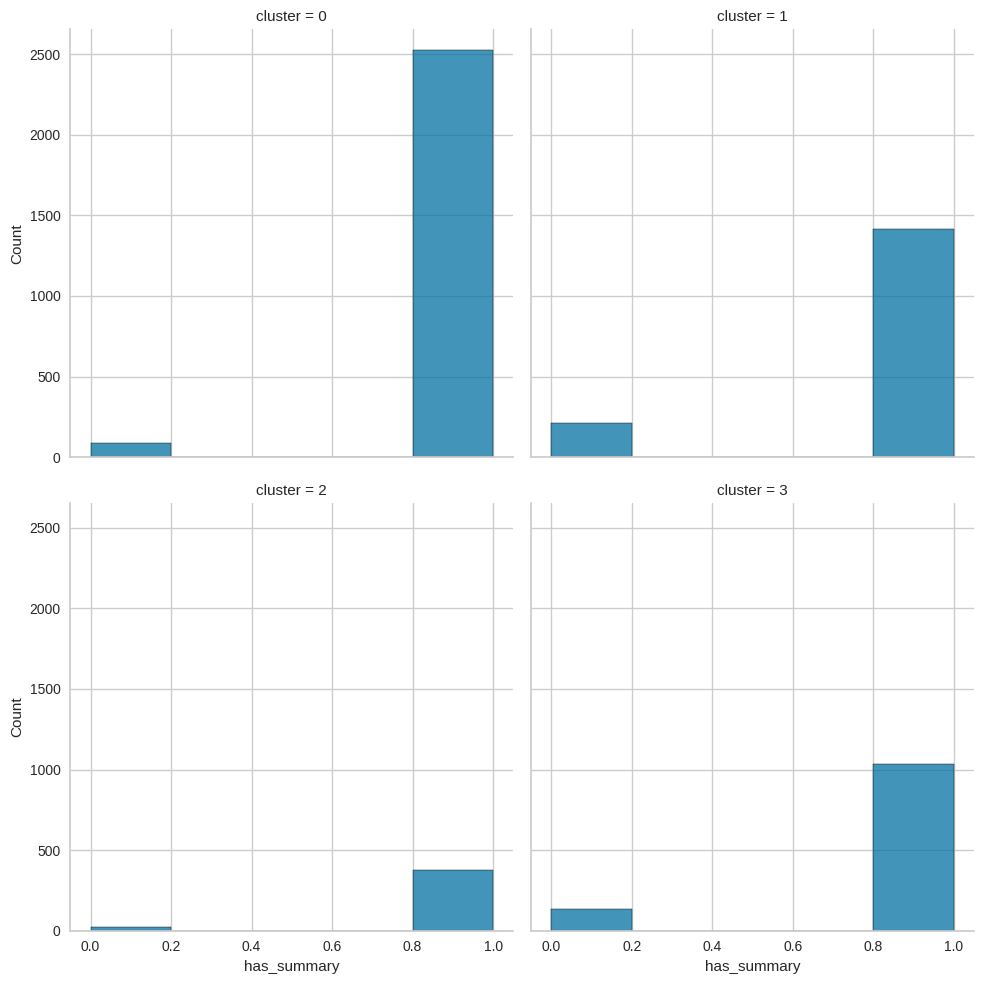

has_space


<Figure size 800x400 with 0 Axes>

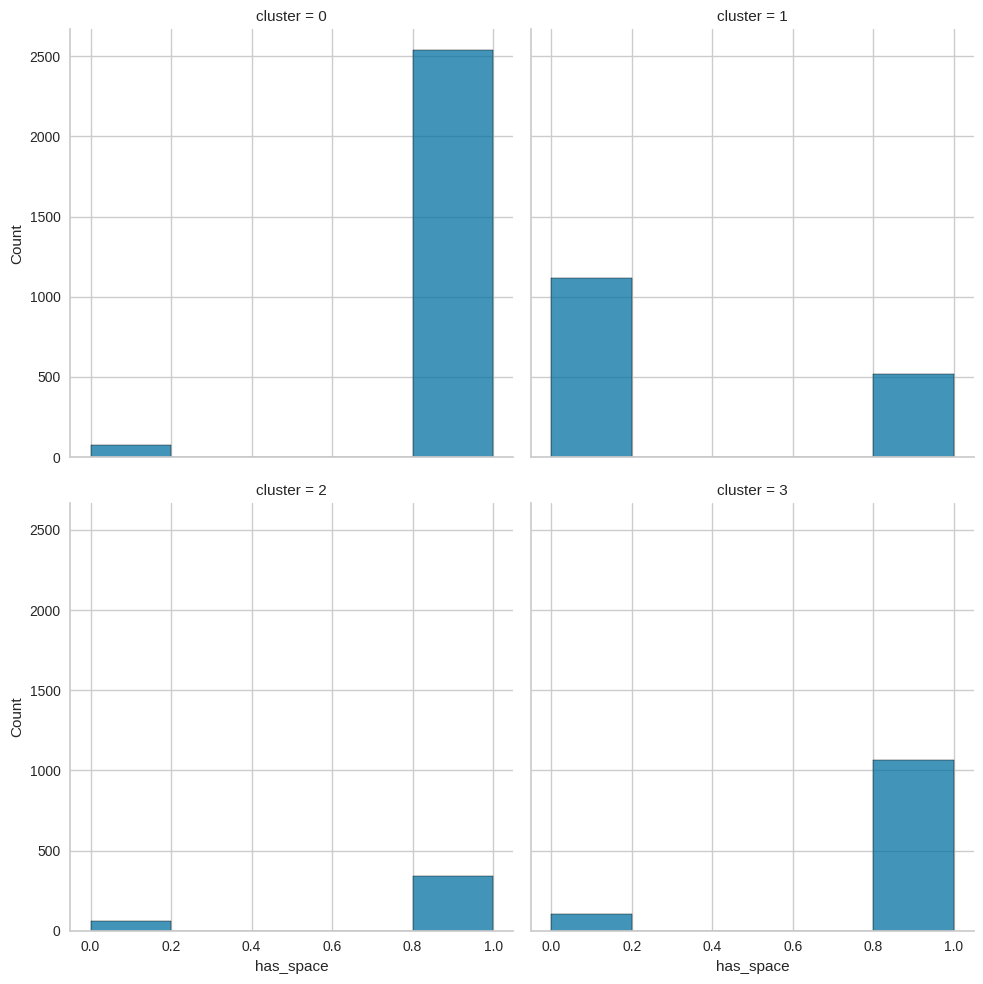

has_description


<Figure size 800x400 with 0 Axes>

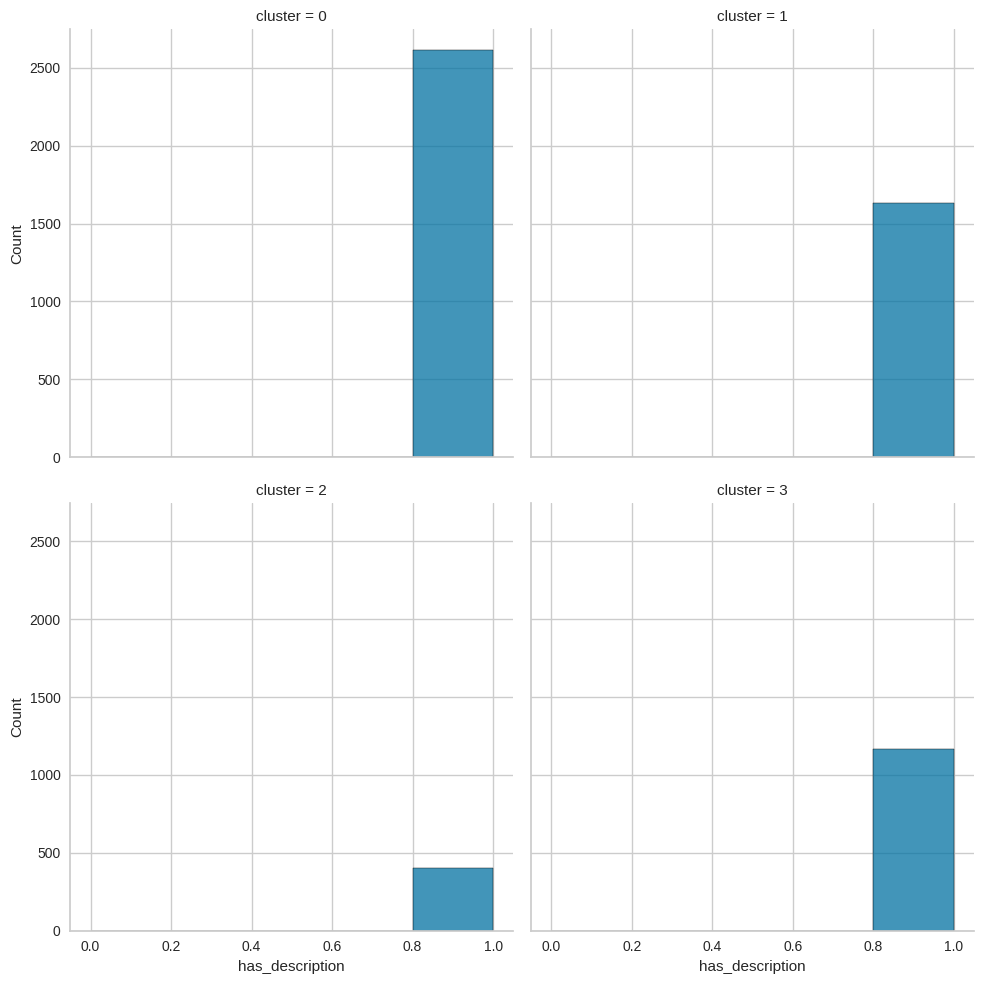

has_neighborhood


<Figure size 800x400 with 0 Axes>

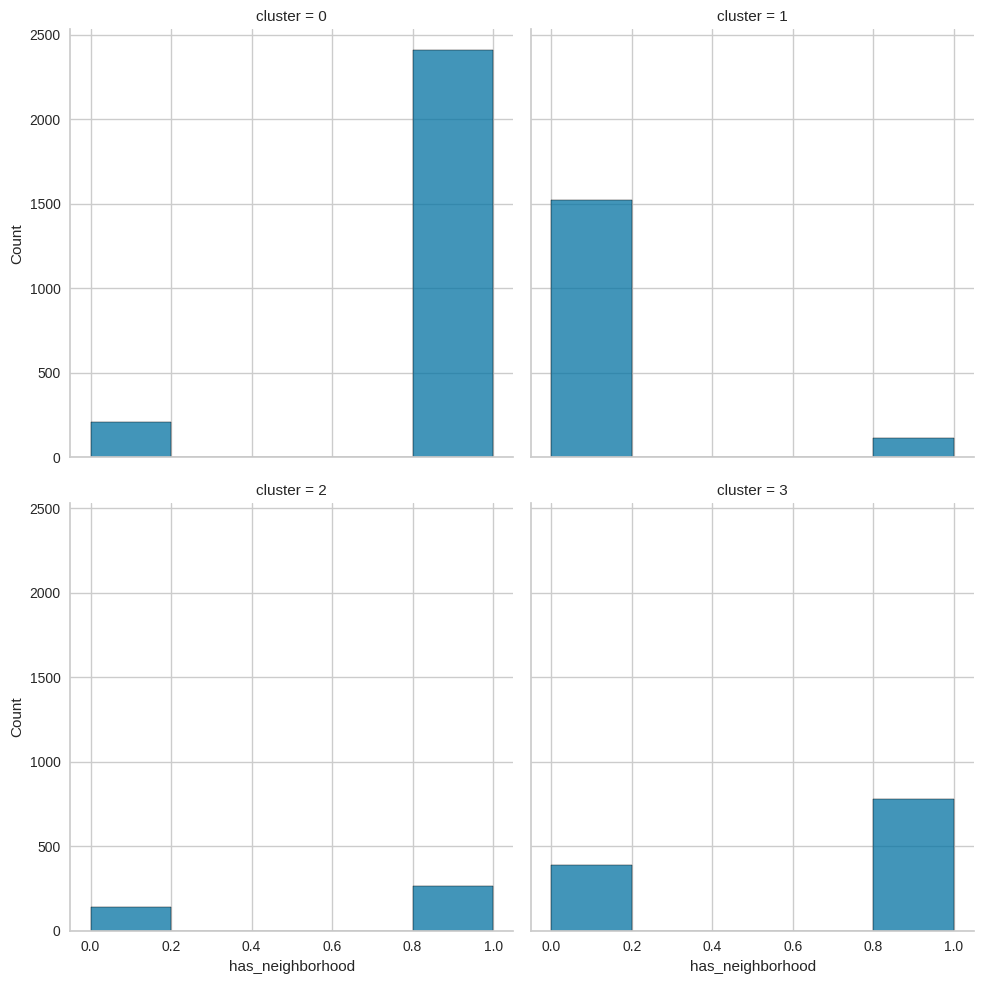

has_notes


<Figure size 800x400 with 0 Axes>

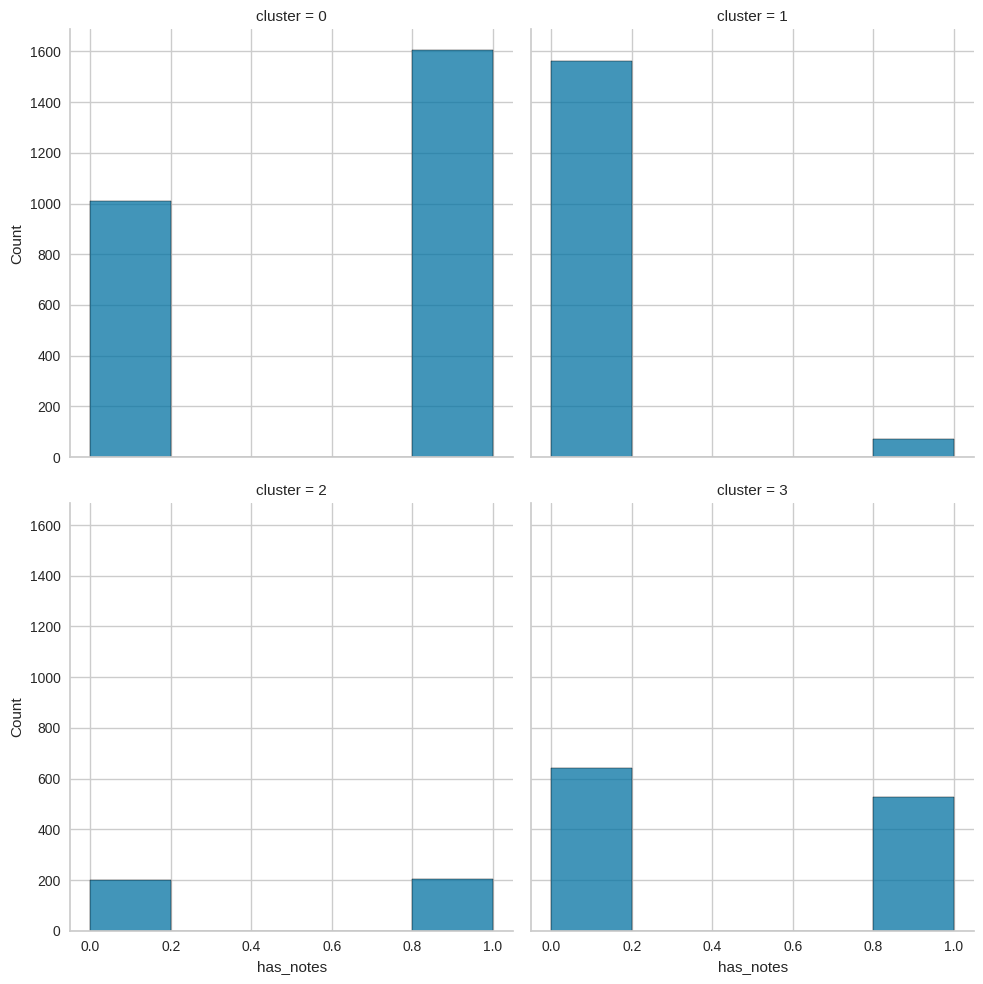

has_transit


<Figure size 800x400 with 0 Axes>

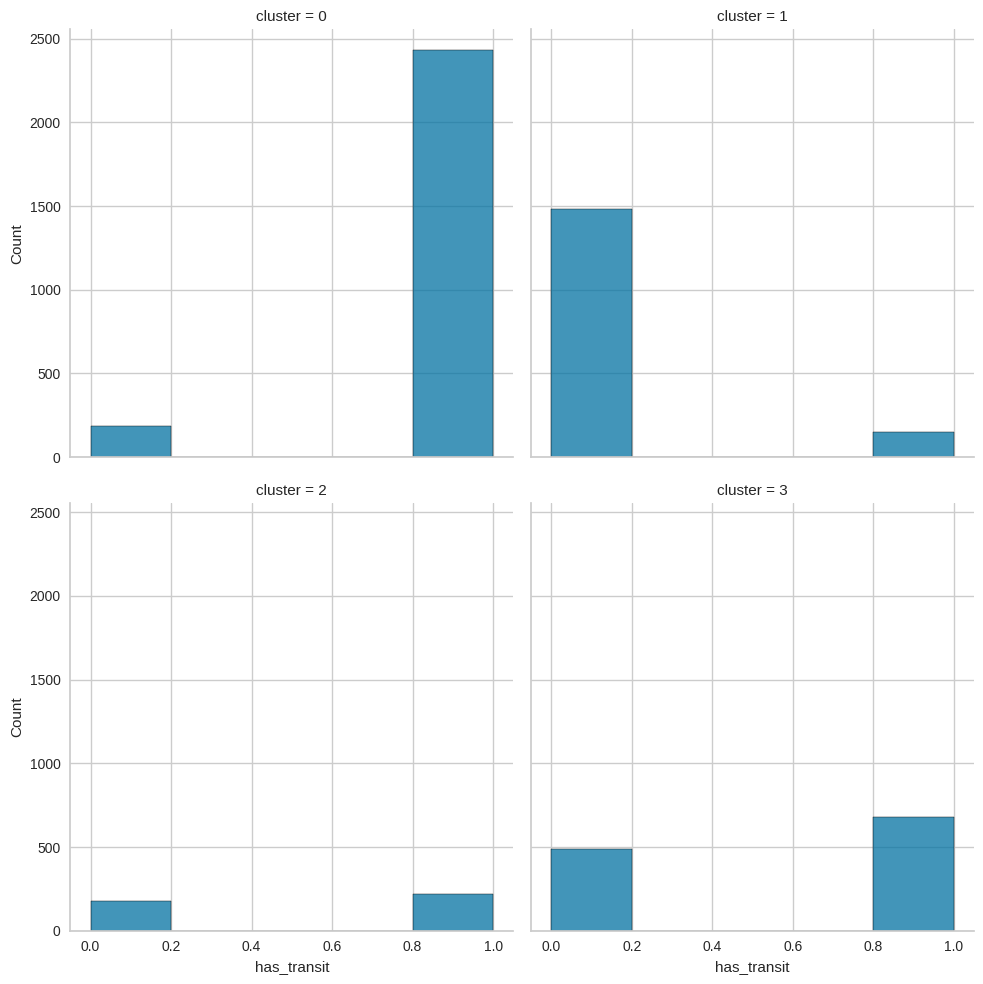

multiple_host


<Figure size 800x400 with 0 Axes>

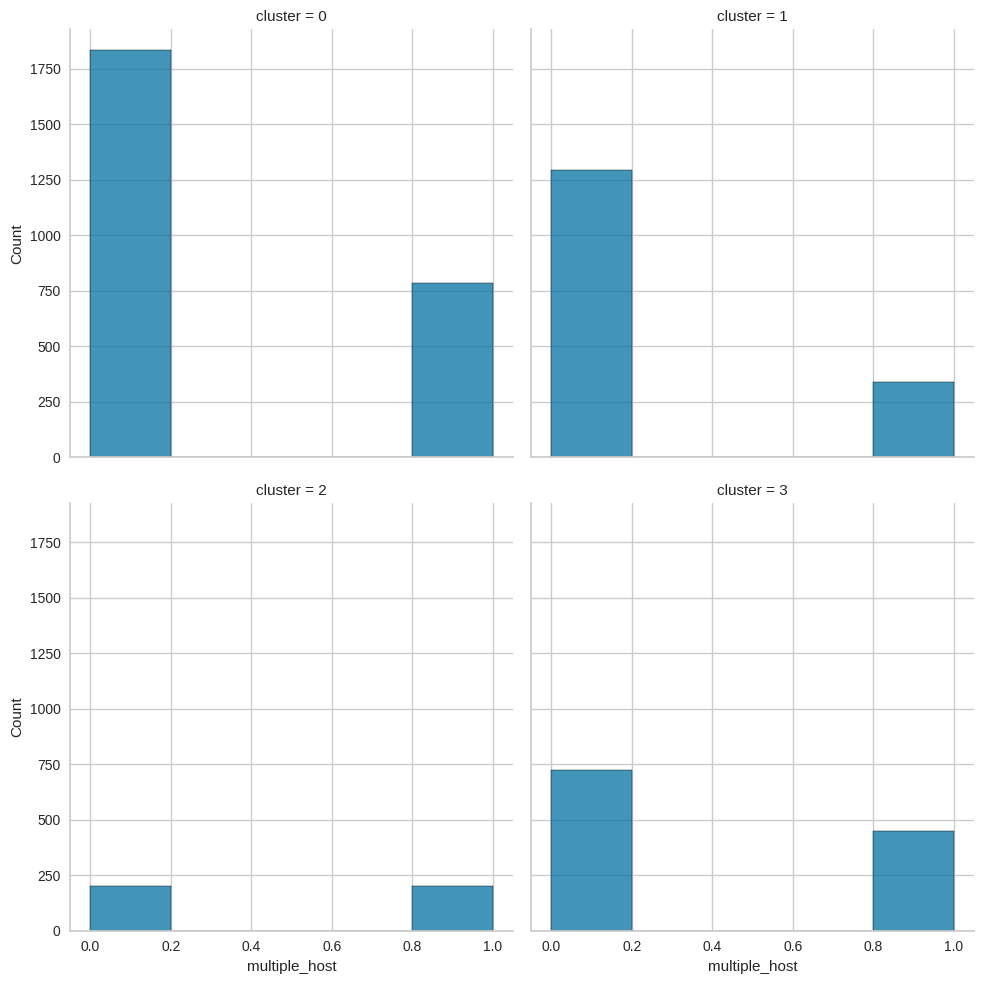

years_as_host


<Figure size 800x400 with 0 Axes>

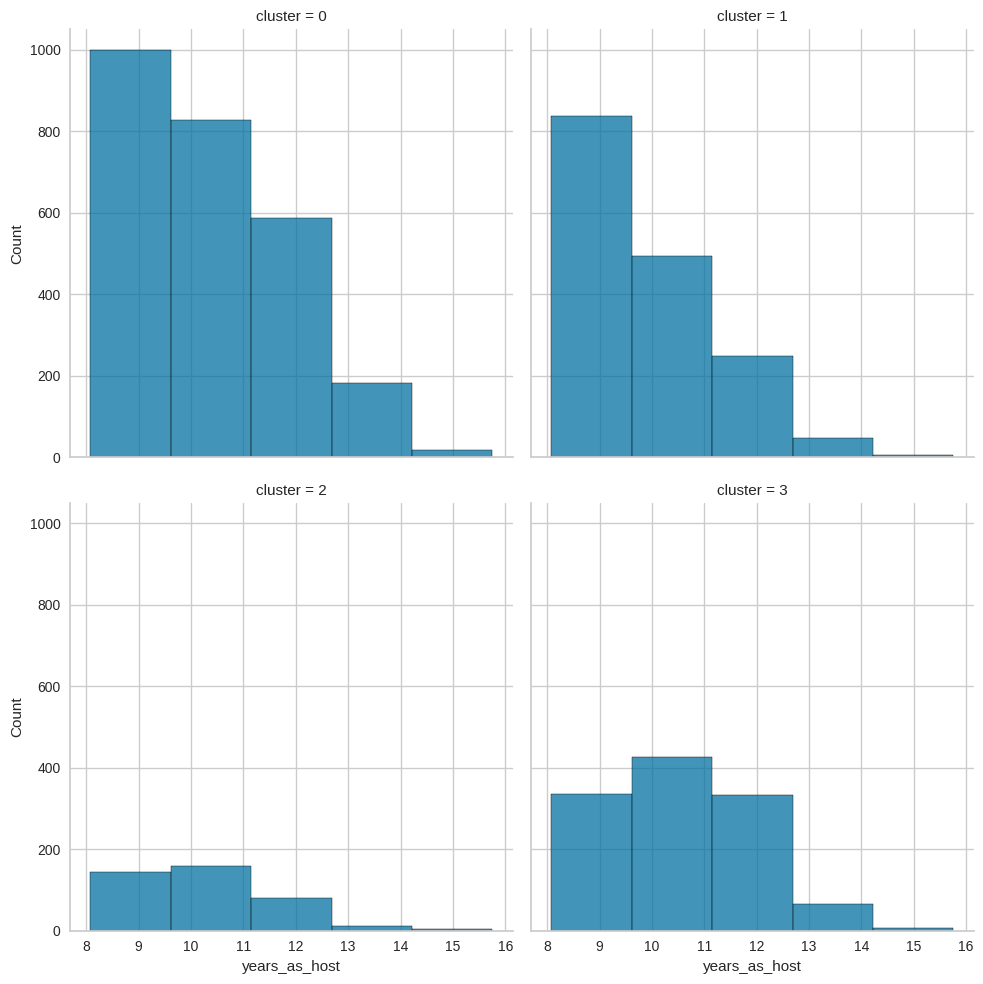

host_texas


<Figure size 800x400 with 0 Axes>

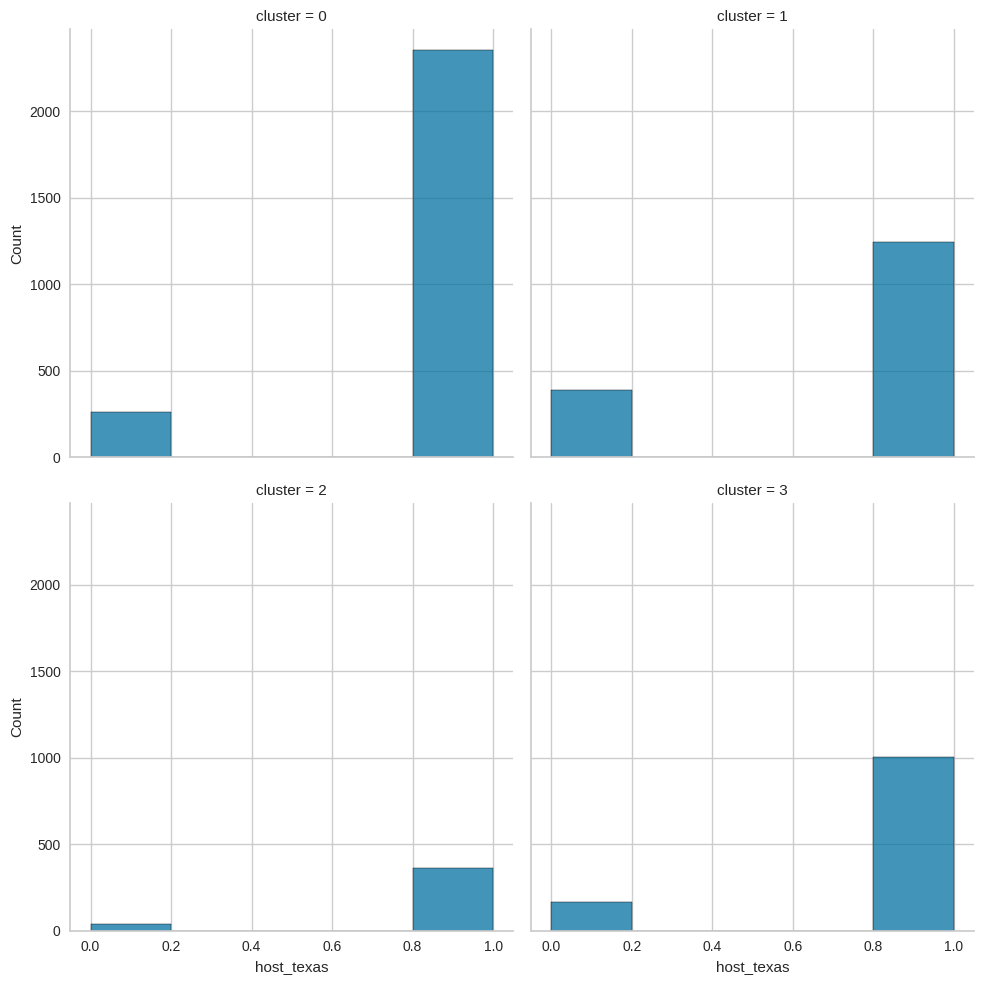

house


<Figure size 800x400 with 0 Axes>

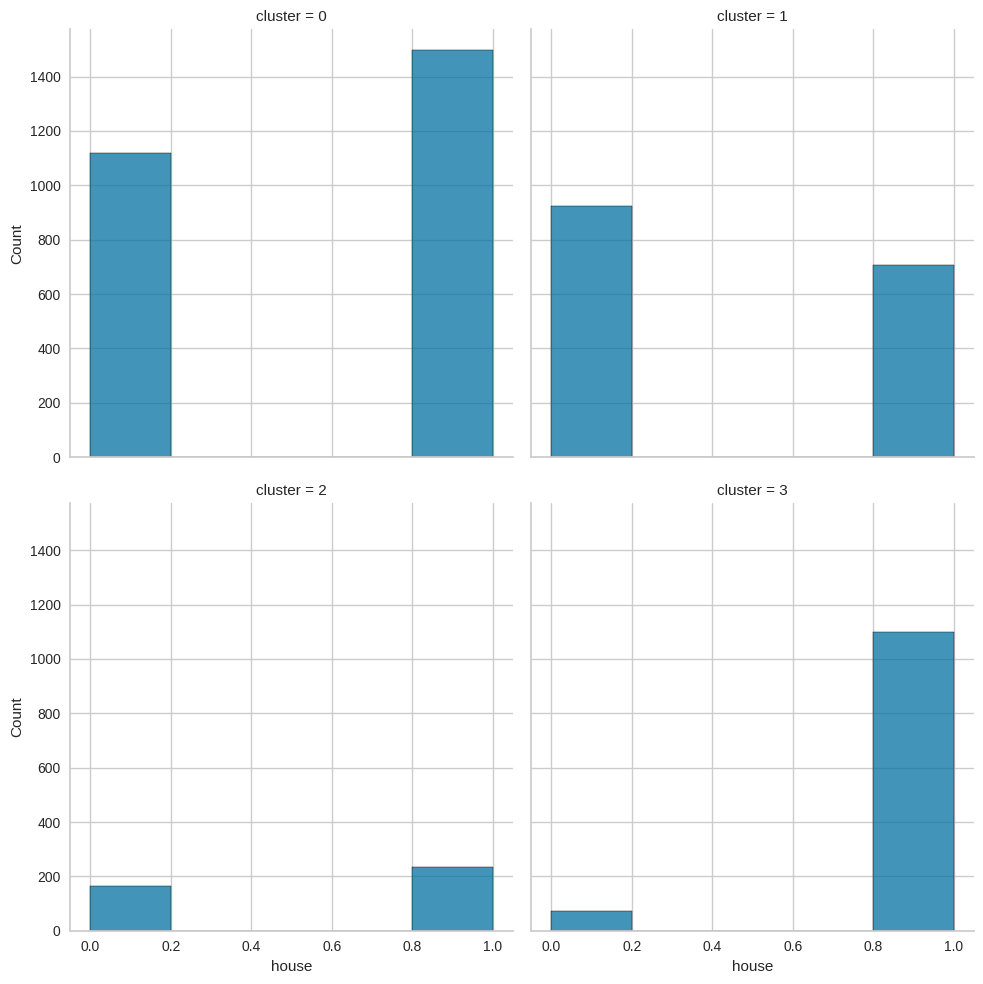

has_gym


<Figure size 800x400 with 0 Axes>

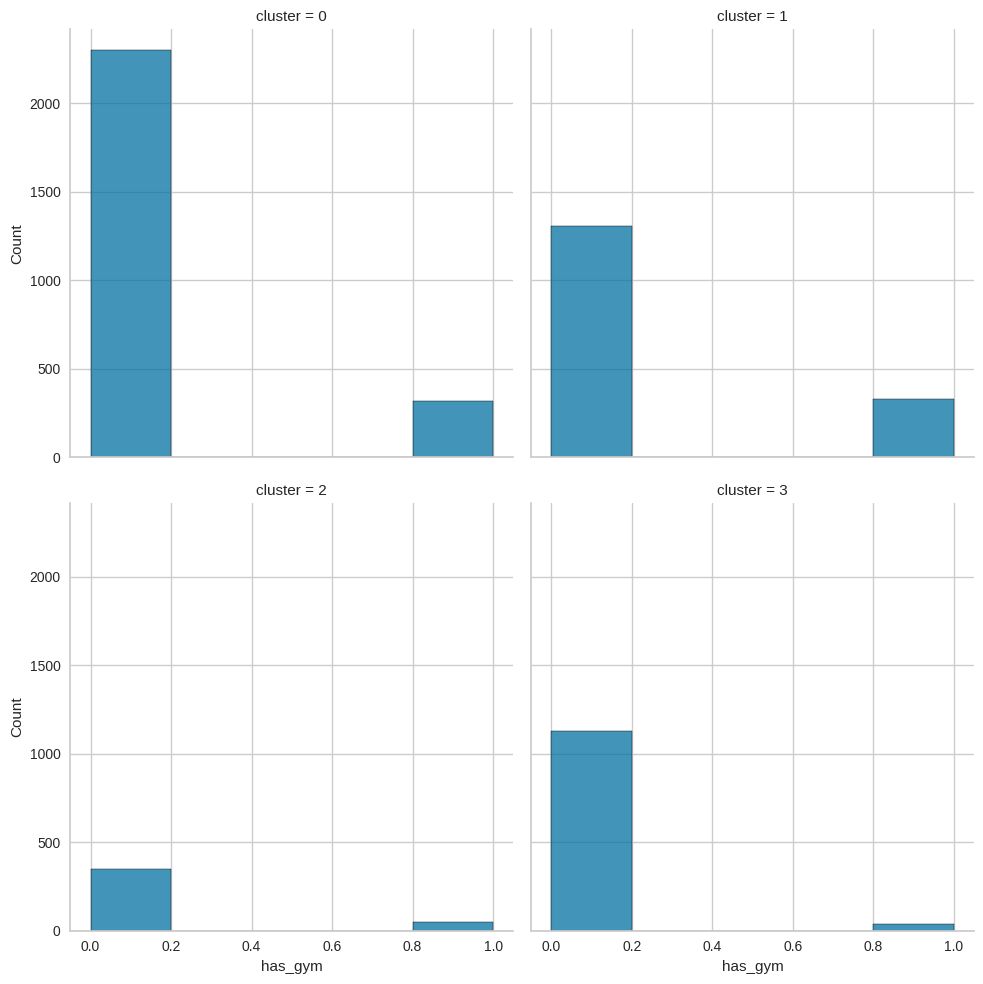

has_smoking_allowed


<Figure size 800x400 with 0 Axes>

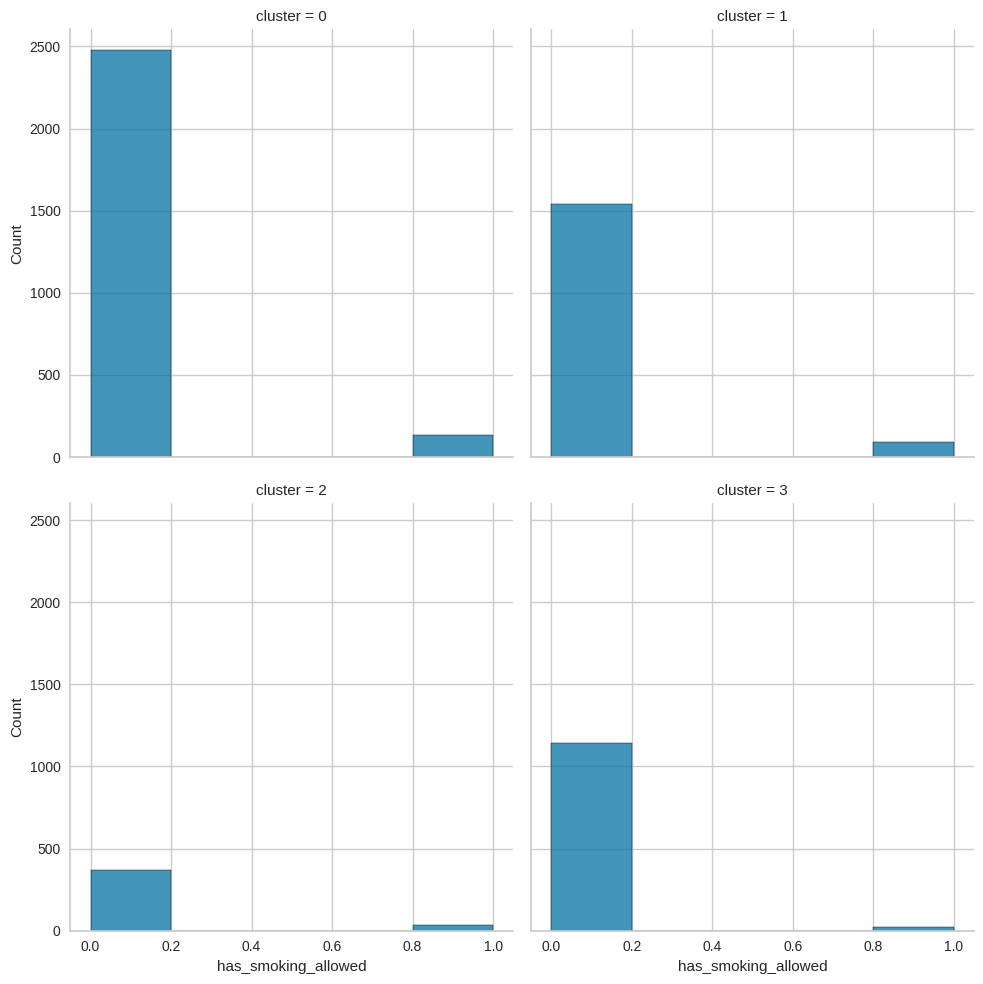

has_pool


<Figure size 800x400 with 0 Axes>

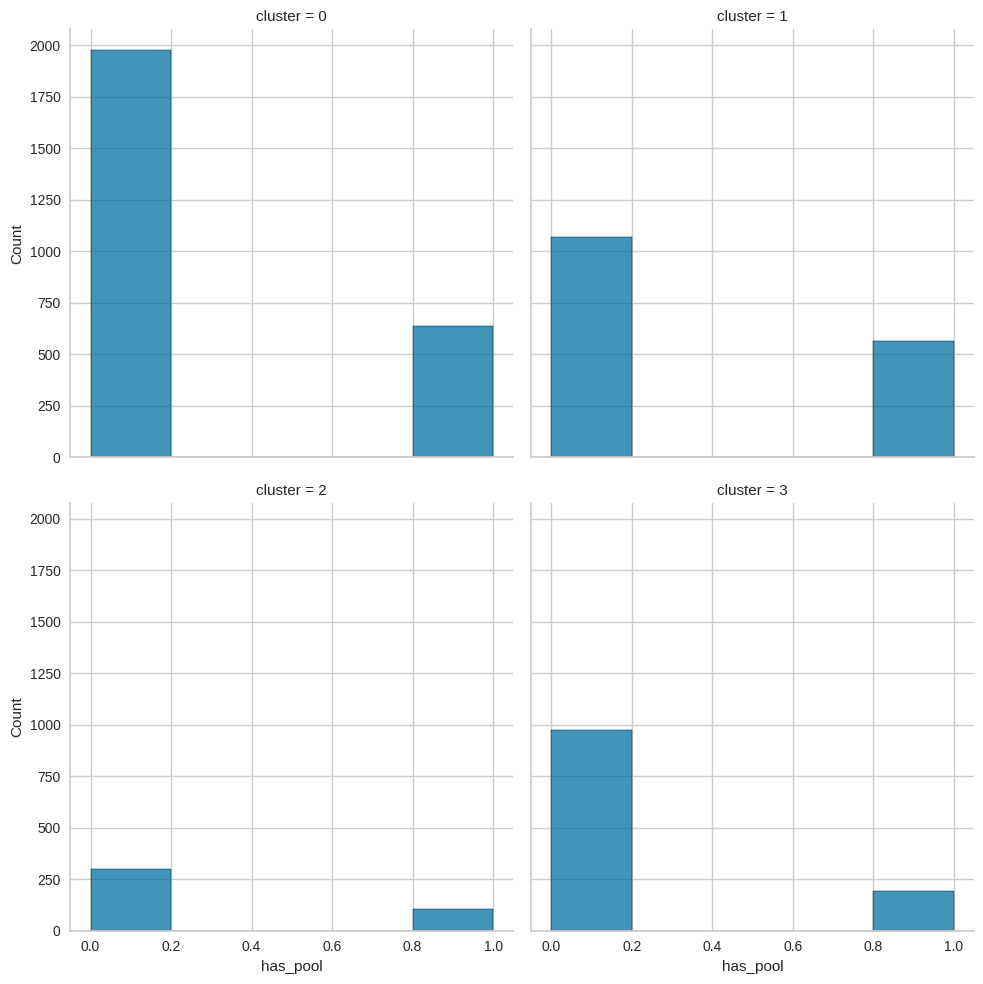

cluster


<Figure size 800x400 with 0 Axes>

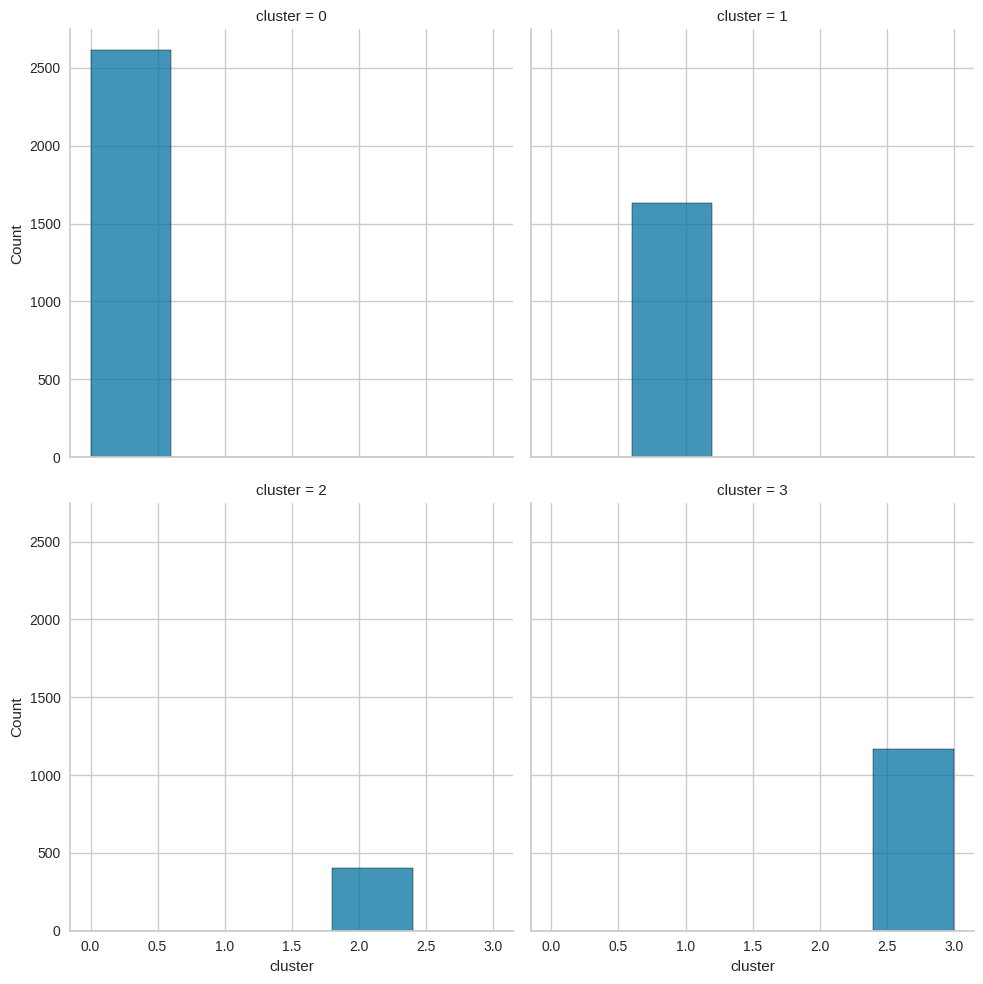

In [ ]:
cluster_col = ['price', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'booked', 'austin_name',
       'has_summary', 'has_space', 'has_description', 'has_neighborhood',
       'has_notes', 'has_transit', 'multiple_host', 'years_as_host',
       'host_texas', 'house', 'has_gym', 'has_smoking_allowed', 'has_pool',
       'cluster']

#Romantic Movies
for col in cluster_col:
  plt.figure(figsize=(8,4))
  print(f"{col}")
  sns.displot(data=cluster_df, x= col, bins=5, col='cluster', col_wrap=2, common_bins=True)
  plt.show()

In [ ]:
#find the mean values of price in each column by cluster
cluster_means = cluster_df.groupby('cluster').mean()
cluster_means

host_is_superhost  host_listings_count  host_has_profile_pic  \
cluster                                                                 
0                 0.202140             4.353458              0.998854   
1                 0.072917             2.825368              0.993873   
2                 0.032338            50.378109              1.000000   
3                 0.142857            27.568862              1.000000   

         host_identity_verified  accommodates  bathrooms  bedrooms      beds  \
cluster                                                                        
0                      0.737868      3.372946   1.168323  1.257929  1.630875   
1                      0.480392      3.429534   1.270527  1.363971  1.604167   
2                      0.786070      4.300995   1.347015  1.604478  2.097015   
3                      0.763901      8.037639   2.496578  3.380667  4.398631   

              price  security_deposit  ...  has_neighborhood  has_notes  \
cluster                                ...                                
0        164.497516        138.294612  ...          0.921666   0.614062   
1        244.472426         85.202819  ...          0.068015   0.042892   
2        195.805970        126.524876  ...          0.654229   0.504975   
3        648.623610        509.081266  ...          0.666382   0.449957   

         has_transit  multiple_host  years_as_host  host_texas     house  \
cluster                                                                    
0           0.930073       0.298815      10.320554    0.900267  0.572793   
1           0.093137       0.206495       9.783113    0.761029  0.433824   
2           0.552239       0.502488      10.316077    0.907960  0.587065   
3           0.579983       0.382378      10.561566    0.858854  0.939264   

          has_gym  has_smoking_allowed  has_pool  
cluster                                           
0        0.120367              0.05235  0.243791  
1        0.200368              0.05576  0.344975  
2        0.129353              0.08209  0.258706  
3        0.033362              0.02053  0.165954  

[4 rows x 38 columns]

Note that here cluster 3 has the highest average price (~$650)

Other distinguishing factors about cluster 3:


*   Largest average bathrooms, beds, and bedrooms, and accommodates the most peoeple on average
*   List item



In [ ]:
cluster3_means = cluster_df.groupby('cluster').mean().loc[3]
print(cluster3_means)

host_is_superhost                0.142857
host_listings_count             27.568862
host_has_profile_pic             1.000000
host_identity_verified           0.763901
accommodates                     8.037639
bathrooms                        2.496578
bedrooms                         3.380667
beds                             4.398631
price                          648.623610
security_deposit               509.081266
cleaning_fee                   118.423439
guests_included                  3.483319
extra_people                    25.396920
minimum_nights                   2.340462
number_of_reviews                7.757057
review_scores_rating            97.508982
review_scores_accuracy           9.857143
review_scores_cleanliness        9.834902
review_scores_checkin            9.943541
review_scores_communication      9.940120
review_scores_location           9.666382
review_scores_value              9.674080
instant_bookable                 0.070145
booked                           0

##Make a new data frame that only includes entries with price <$500

In [ ]:
#make new price_df
price_df = df[df['price'] < 500]
price_df

host_is_superhost  host_listings_count  host_has_profile_pic  \
0                     0                  1.0                     1   
1                     0                  1.0                     1   
2                     0                  2.0                     1   
3                     0                  2.0                     1   
5                     0                  1.0                     1   
...                 ...                  ...                   ...   
5830                  1                 21.0                     1   
5831                  0                  4.0                     1   
5832                  0                  5.0                     1   
5833                  0                  2.0                     1   
5834                  0                  1.0                     1   

      host_identity_verified  accommodates  bathrooms  bedrooms  beds  price  \
0                          0             6        2.5       1.0   3.0  300.0   
1                          1             2        0.0       1.0   1.0   99.0   
2                          1             2        1.5       1.0   1.0  100.0   
3                          1             2        1.5       1.0   1.0  100.0   
5                          0             2        1.0       1.0   1.0  100.0   
...                      ...           ...        ...       ...   ...    ...   
5830                       1             4        1.0       1.0   2.0  179.0   
5831                       1             2        1.0       1.0   2.0   85.0   
5832                       0             2        1.0       0.0   1.0   66.0   
5833                       1             1        1.0       1.0   1.0   25.0   
5834                       1             2        1.0       1.0   1.0  120.0   

      security_deposit  ...  has_notes  has_transit  multiple_host  \
0                  0.0  ...          0            1              0   
1               1000.0  ...          0            1              0   
2                  0.0  ...          0            0              1   
3                  0.0  ...          0            0              1   
5                  0.0  ...          0            0              0   
...                ...  ...        ...          ...            ...   
5830             500.0  ...          1            1              1   
5831             500.0  ...          0            1              1   
5832               0.0  ...          1            1              0   
5833               0.0  ...          0            0              0   
5834             100.0  ...          1            1              0   

      years_as_host  host_texas  house  has_gym  has_smoking_allowed  \
0         12.830137           1      1        0                    0   
1          8.791781           1      0        0                    0   
2          8.147945           1      1        0                    0   
3          8.147945           1      1        0                    0   
5          8.194521           1      1        0                    0   
...             ...         ...    ...      ...                  ...   
5830      10.835616           1      0        0                    0   
5831       8.216438           0      0        0                    0   
5832       9.597260           0      1        0                    1   
5833       8.263014           1      0        0                    0   
5834       9.271233           1      0        0                    0   

      has_pool  cluster  
0            0        0  
1            0        0  
2            1        1  
3            1        1  
5            0        1  
...        ...      ...  
5830         1        0  
5831         1        0  
5832         0        0  
5833         0        1  
5834         1        0  

[4936 rows x 39 columns]

Text(0.5, 1.0, 'Price Distribution')

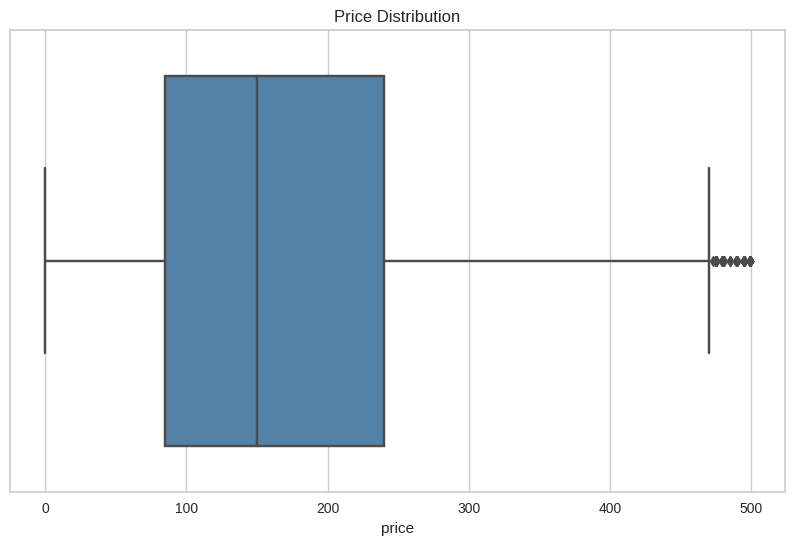

In [ ]:
#create a box plot to visualize the price distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=price_df,
            x='price',
            color = 'steelblue')
plt.title('Price Distribution')

##Linear Regression - price_df

In [ ]:
#see how variables are correlated with price
#calculate the correlation with the 'price' column
correlation_with_price2 = price_df.corr()['price'].sort_values(ascending=False)

#convert to df
price2_cor_df = correlation_with_price2.reset_index()
price2_cor_df.columns = ['Variable', 'Correlation_with_Price']
price2_cor_df

Variable  Correlation_with_Price
0                         price                1.000000
1                      bedrooms                0.525436
2                  accommodates                0.508538
3                     bathrooms                0.454169
4                          beds                0.435790
5                  cleaning_fee                0.405876
6                       cluster                0.391261
7              security_deposit                0.265238
8               guests_included                0.249093
9           host_listings_count                0.106180
10    review_scores_cleanliness                0.103812
11       review_scores_location                0.090409
12                 extra_people                0.072290
13                        house                0.071230
14         review_scores_rating                0.069357
15       review_scores_accuracy                0.052542
16                       booked                0.038995
17  review_scores_communication                0.033208
18        review_scores_checkin                0.026259
19                years_as_host                0.018680
20          review_scores_value                0.008958
21               minimum_nights               -0.002366
22                      has_gym               -0.002574
23         host_has_profile_pic               -0.002888
24                    has_space               -0.007846
25                     has_pool               -0.008047
26              has_description               -0.021298
27             has_neighborhood               -0.031773
28                  austin_name               -0.032473
29                  has_summary               -0.050961
30                    has_notes               -0.059809
31                   host_texas               -0.072197
32             instant_bookable               -0.075813
33          has_smoking_allowed               -0.084992
34                multiple_host               -0.095322
35                  has_transit               -0.104293
36       host_identity_verified               -0.106901
37            host_is_superhost               -0.108374
38            number_of_reviews               -0.170200

In [ ]:
#regress with all variables
X = price_df.drop('price', axis=1)
y = price_df['price']
X = sm.add_constant(X)
price_reg4 = sm.OLS(y, X).fit()

print(price_reg4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     98.53
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        04:28:46   Log-Likelihood:                -28853.
No. Observations:                4936   AIC:                         5.778e+04
Df Residuals:                    4897   BIC:                         5.804e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [ ]:
#regression with variables having absolute correlation value > 0.1
list3 = ['bathrooms', 'bedrooms', 'accommodates', 'beds', 'cleaning_fee', 'security_deposit', 'guests_included', 'house', 'review_scores_cleanliness', 'host_identity_verified', 'host_is_superhost', 'has_transit', 'number_of_reviews']

X = df[list3]
y = df['price']
X = sm.add_constant(X)
price_reg5 = sm.OLS(y, X).fit()

print(price_reg5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     330.7
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        04:28:46   Log-Likelihood:                -41568.
No. Observations:                5820   AIC:                         8.316e+04
Df Residuals:                    5806   BIC:                         8.326e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
#adding and removing values until good model reached
list3 = ['bathrooms', 'bedrooms', 'accommodates', 'guests_included', 'house', 'review_scores_cleanliness', 'host_identity_verified', 'host_is_superhost', 'has_transit', 'number_of_reviews']

X = df[list3]
y = df['price']
X = sm.add_constant(X)
price_reg6 = sm.OLS(y, X).fit()

print(price_reg6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     380.0
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        04:28:46   Log-Likelihood:                -41716.
No. Observations:                5820   AIC:                         8.345e+04
Df Residuals:                    5809   BIC:                         8.353e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

##K-Means Clustering - price_df

In [ ]:
#Standardize Data
dfcolumns2 = price_df.columns.values.tolist()

scaler2 = StandardScaler()

df_scaled2 = scaler2.fit_transform(price_df.to_numpy())
df_scaled2 = pd.DataFrame(df_scaled2, columns=dfcolumns2)


df_scaled2.head()

host_is_superhost  host_listings_count  host_has_profile_pic  \
0          -0.429256            -0.184420              0.045056   
1          -0.429256            -0.184420              0.045056   
2          -0.429256            -0.164973              0.045056   
3          -0.429256            -0.164973              0.045056   
4          -0.429256            -0.184420              0.045056   

   host_identity_verified  accommodates  bathrooms  bedrooms      beds  \
0               -1.482890      0.922943   2.133045 -0.545686  0.821284   
1                0.674359     -0.820679  -2.351074 -0.545686 -0.703296   
2                0.674359     -0.820679   0.339398 -0.545686 -0.703296   
3                0.674359     -0.820679   0.339398 -0.545686 -0.703296   
4               -1.482890     -0.820679  -0.557426 -0.545686 -0.703296   

      price  security_deposit  ...  has_notes  has_transit  multiple_host  \
0  1.148648         -0.575015  ...  -0.869459     0.776271      -0.679450   
1 -0.660443          3.401376  ...  -0.869459     0.776271      -0.679450   
2 -0.651443         -0.575015  ...  -0.869459    -1.288209       1.471779   
3 -0.651443         -0.575015  ...  -0.869459    -1.288209       1.471779   
4 -0.651443         -0.575015  ...  -0.869459    -1.288209      -0.679450   

   years_as_host  host_texas     house  has_gym  has_smoking_allowed  \
0       1.775067    0.396987  0.864082 -0.38424            -0.231463   
1      -0.962597    0.396987 -1.157297 -0.38424            -0.231463   
2      -1.399063    0.396987  0.864082 -0.38424            -0.231463   
3      -1.399063    0.396987  0.864082 -0.38424            -0.231463   
4      -1.367489    0.396987  0.864082 -0.38424            -0.231463   

   has_pool   cluster  
0 -0.585772 -0.796587  
1 -0.585772 -0.796587  
2  1.707148  0.177392  
3  1.707148  0.177392  
4 -0.585772  0.177392  

[5 rows x 39 columns]

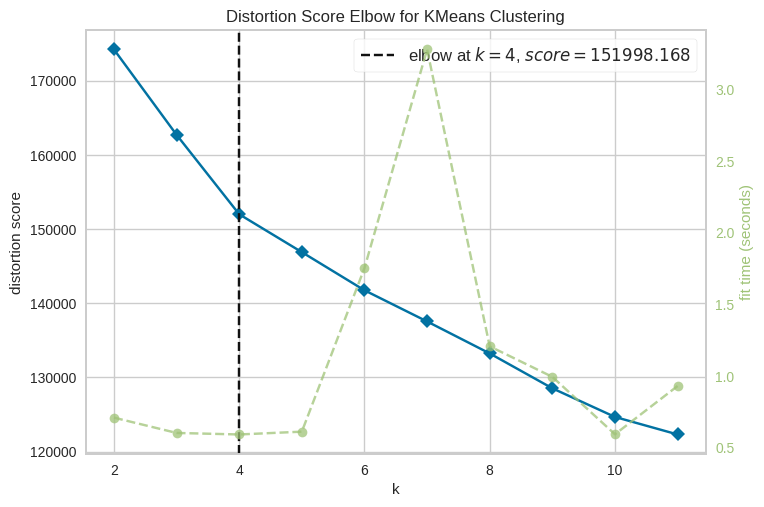

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# set the model type to k-means
model2 = KMeans()

# generate an elbow plot for k = 2 to 12 clusters using the scaled data
visualizer = KElbowVisualizer(model2, k=(2, 12))
visualizer.fit(df_scaled2)
visualizer.show()

In [ ]:
# Create an instance of KMeans with the desired value of k and fit to the scaled data
kmeans2 = KMeans(n_clusters=4, random_state=904) #choosing 4 clusters based on elbow
kmclus2=kmeans2.fit(df_scaled2)

clusters2 = kmeans2.fit_predict(df_scaled2)

#append cluster to original data
cluster_df2= price_df
cluster_df2['cluster']=clusters2

cluster_df.info()

# Evaluate cluster sizes to insure that they are similar
print(cluster_df2['cluster'].value_counts())

# Examine the means of each variable by cluster
df_desc2 = cluster_df2.groupby('cluster').mean()
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
     print(df_desc2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5820 entries, 0 to 5834
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            5820 non-null   int64  
 1   host_listings_count          5820 non-null   float64
 2   host_has_profile_pic         5820 non-null   int64  
 3   host_identity_verified       5820 non-null   int64  
 4   accommodates                 5820 non-null   int64  
 5   bathrooms                    5820 non-null   float64
 6   bedrooms                     5820 non-null   float64
 7   beds                         5820 non-null   float64
 8   price                        5820 non-null   float64
 9   security_deposit             5820 non-null   float64
 10  cleaning_fee                 5820 non-null   float64
 11  guests_included              5820 non-null   int64  
 12  extra_people                 5820 non-null   float64
 13  minimum_nights    

In [ ]:
cluster_df2

host_is_superhost  host_listings_count  host_has_profile_pic  \
0                     0                  1.0                     1   
1                     0                  1.0                     1   
2                     0                  2.0                     1   
3                     0                  2.0                     1   
5                     0                  1.0                     1   
...                 ...                  ...                   ...   
5830                  1                 21.0                     1   
5831                  0                  4.0                     1   
5832                  0                  5.0                     1   
5833                  0                  2.0                     1   
5834                  0                  1.0                     1   

      host_identity_verified  accommodates  bathrooms  bedrooms  beds  price  \
0                          0             6        2.5       1.0   3.0  300.0   
1                          1             2        0.0       1.0   1.0   99.0   
2                          1             2        1.5       1.0   1.0  100.0   
3                          1             2        1.5       1.0   1.0  100.0   
5                          0             2        1.0       1.0   1.0  100.0   
...                      ...           ...        ...       ...   ...    ...   
5830                       1             4        1.0       1.0   2.0  179.0   
5831                       1             2        1.0       1.0   2.0   85.0   
5832                       0             2        1.0       0.0   1.0   66.0   
5833                       1             1        1.0       1.0   1.0   25.0   
5834                       1             2        1.0       1.0   1.0  120.0   

      security_deposit  ...  has_notes  has_transit  multiple_host  \
0                  0.0  ...          0            1              0   
1               1000.0  ...          0            1              0   
2                  0.0  ...          0            0              1   
3                  0.0  ...          0            0              1   
5                  0.0  ...          0            0              0   
...                ...  ...        ...          ...            ...   
5830             500.0  ...          1            1              1   
5831             500.0  ...          0            1              1   
5832               0.0  ...          1            1              0   
5833               0.0  ...          0            0              0   
5834             100.0  ...          1            1              0   

      years_as_host  host_texas  house  has_gym  has_smoking_allowed  \
0         12.830137           1      1        0                    0   
1          8.791781           1      0        0                    0   
2          8.147945           1      1        0                    0   
3          8.147945           1      1        0                    0   
5          8.194521           1      1        0                    0   
...             ...         ...    ...      ...                  ...   
5830      10.835616           1      0        0                    0   
5831       8.216438           0      0        0                    0   
5832       9.597260           0      1        0                    1   
5833       8.263014           1      0        0                    0   
5834       9.271233           1      0        0                    0   

      has_pool  cluster  
0            0        2  
1            0        2  
2            1        3  
3            1        3  
5            0        3  
...        ...      ...  
5830         1        2  
5831         1        2  
5832         0        2  
5833         0        3  
5834         1        2  

[4936 rows x 39 columns]

price


<Figure size 800x400 with 0 Axes>

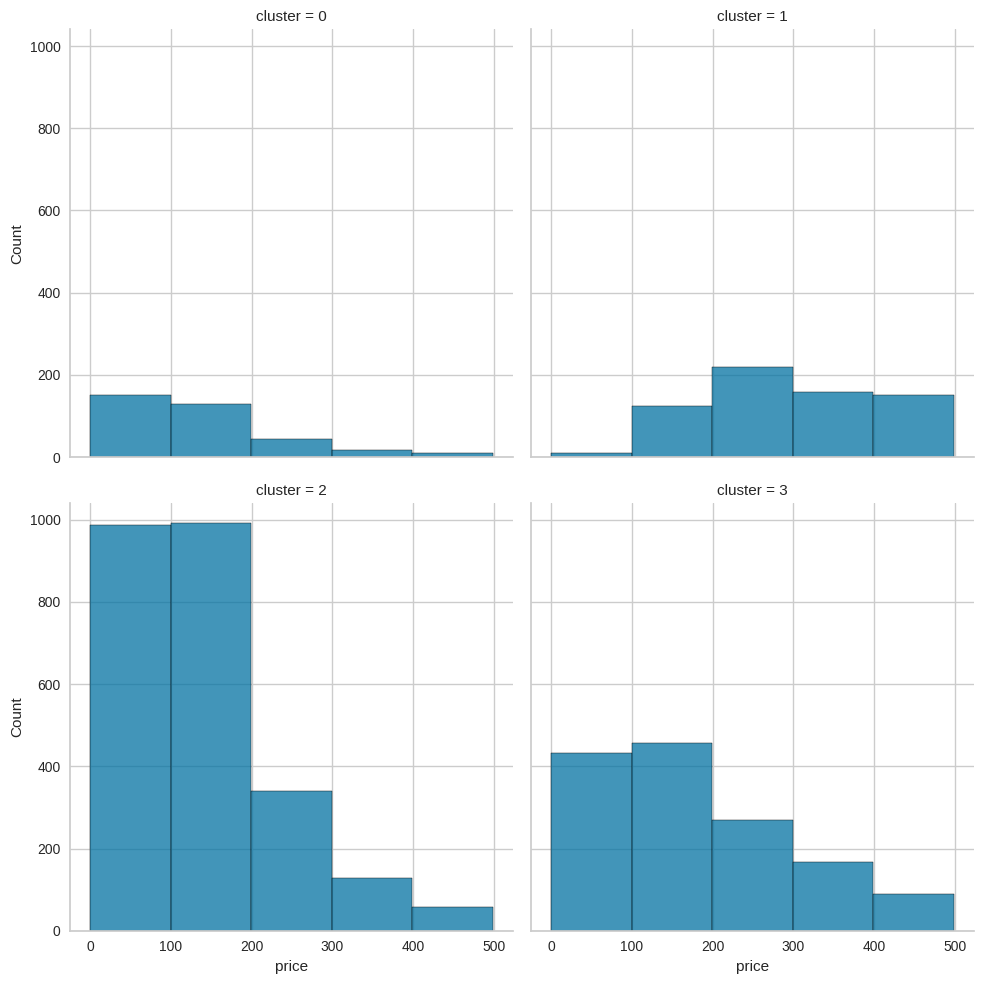

host_is_superhost


<Figure size 800x400 with 0 Axes>

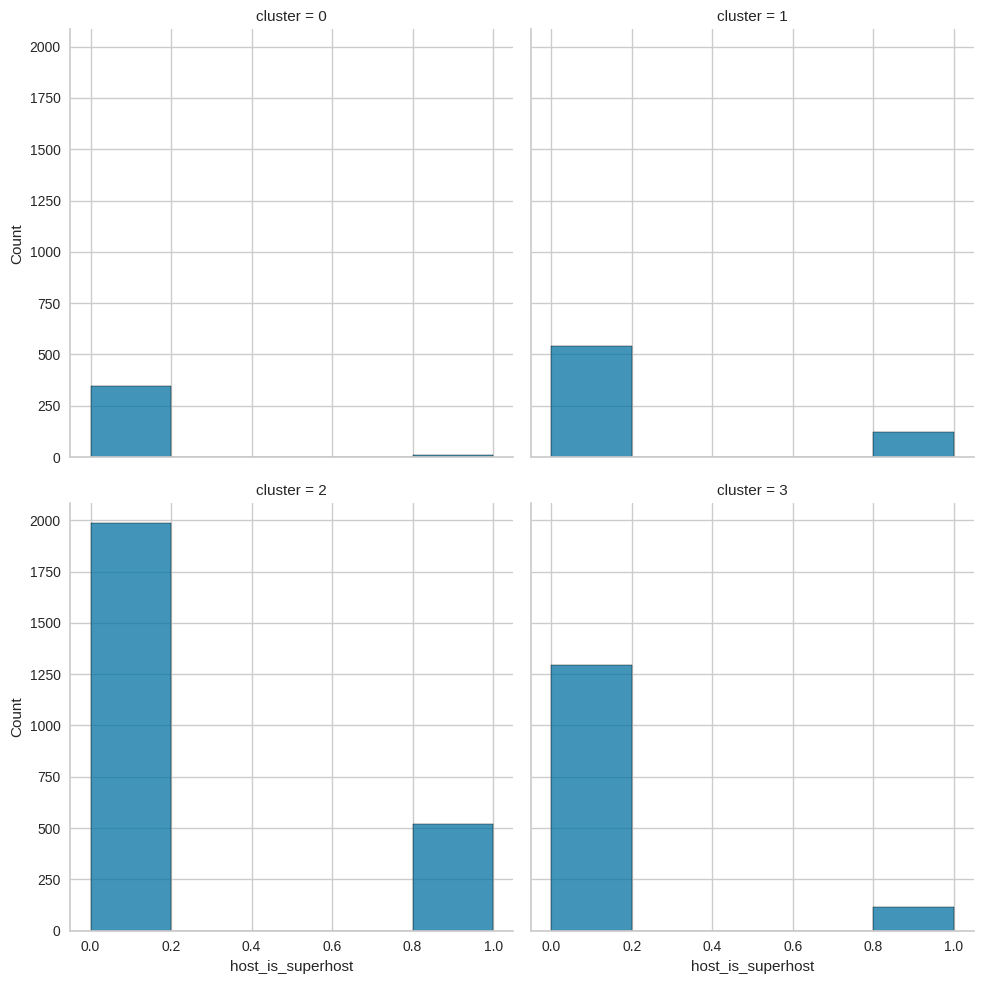

host_listings_count


<Figure size 800x400 with 0 Axes>

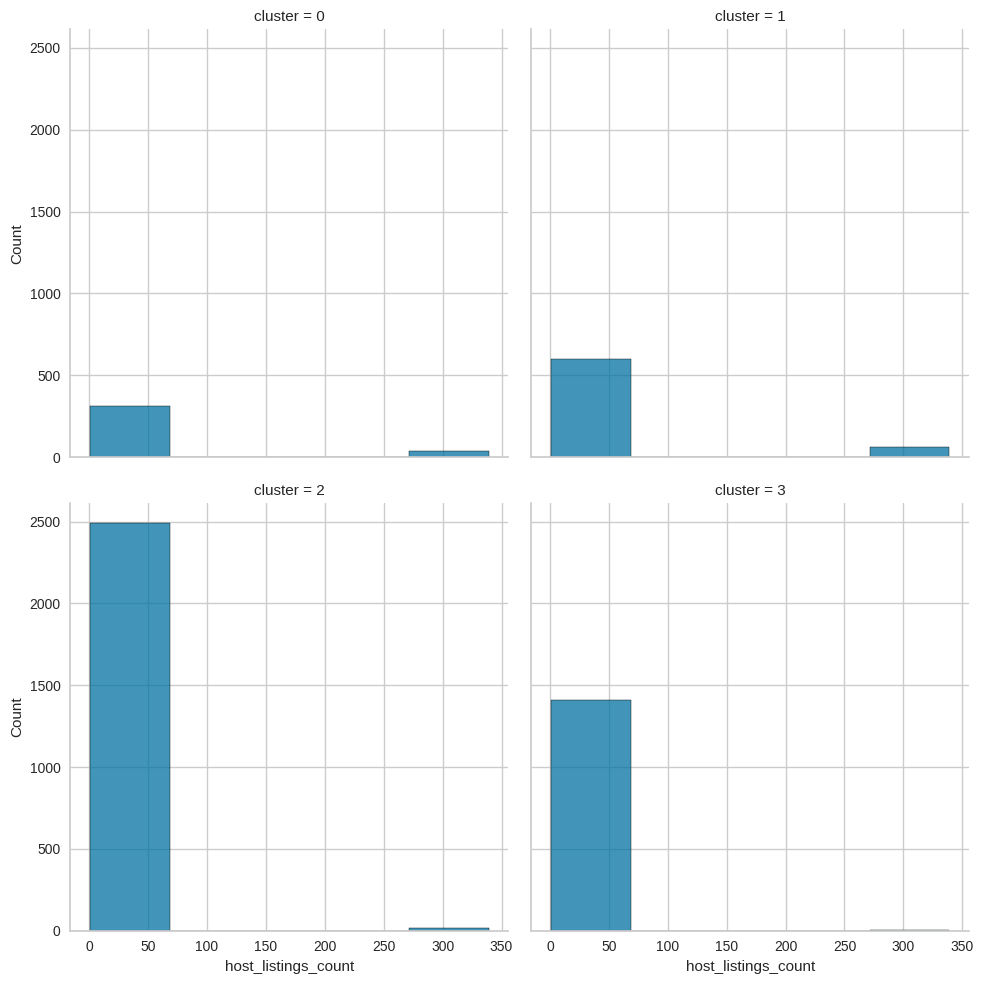

host_has_profile_pic


<Figure size 800x400 with 0 Axes>

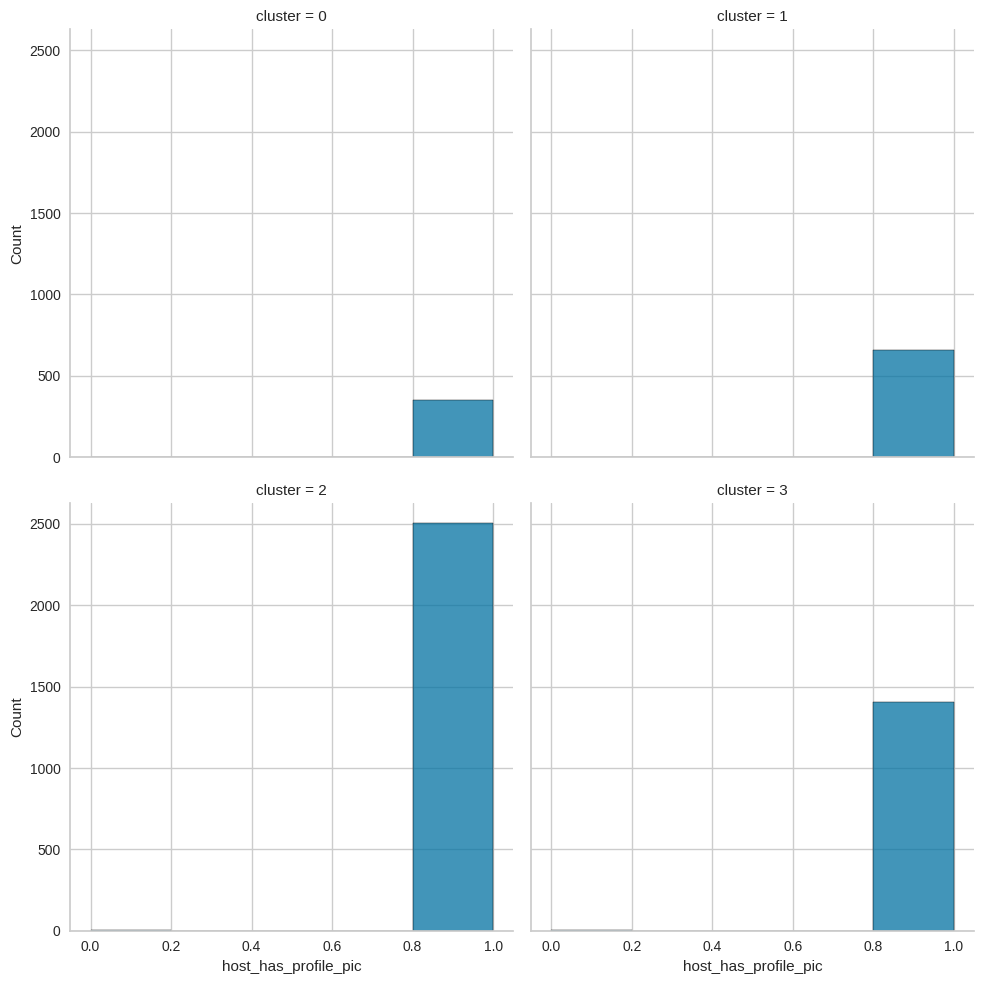

host_identity_verified


<Figure size 800x400 with 0 Axes>

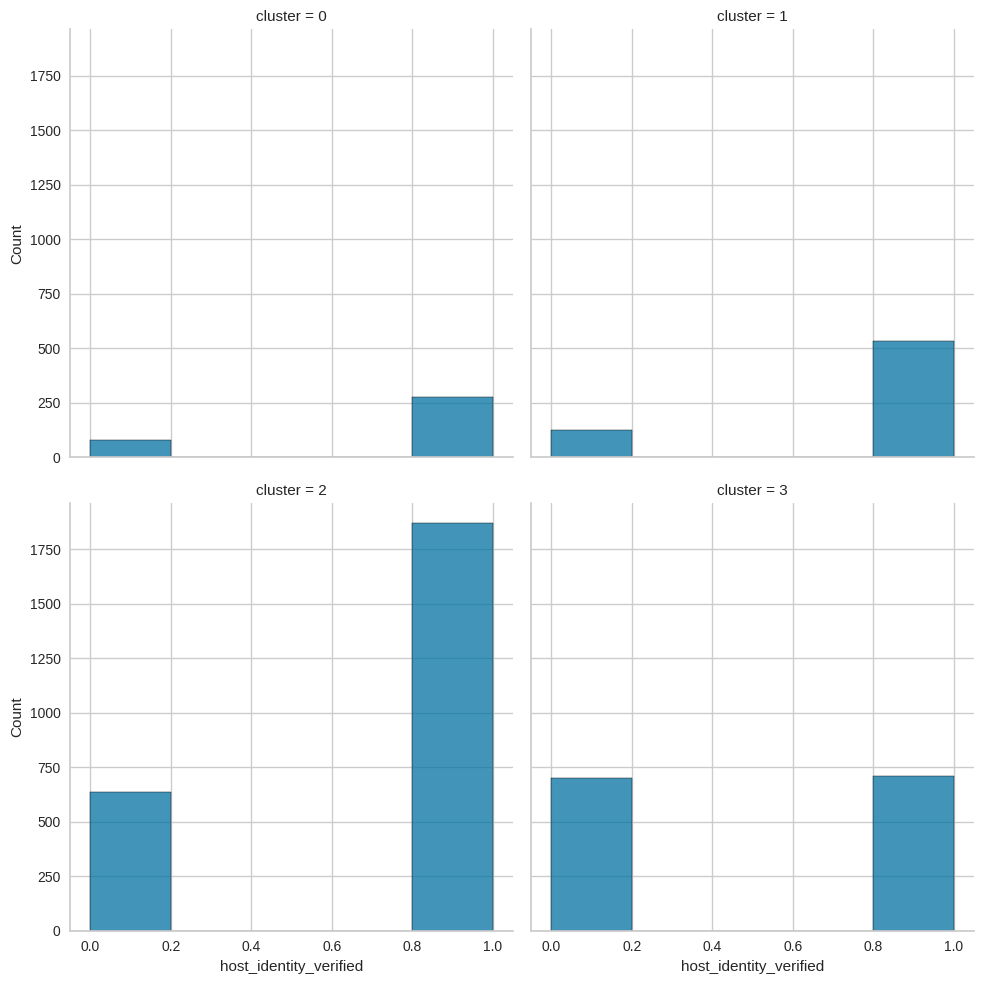

accommodates


<Figure size 800x400 with 0 Axes>

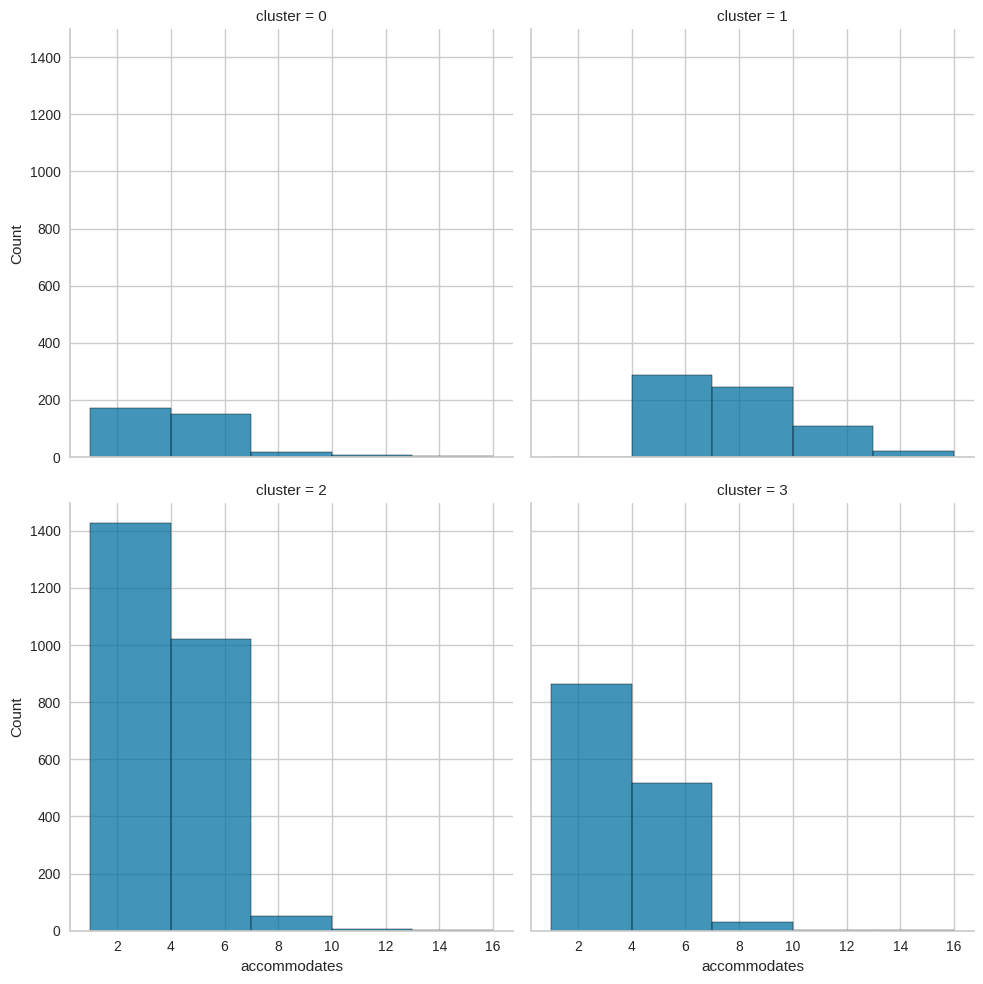

bathrooms


<Figure size 800x400 with 0 Axes>

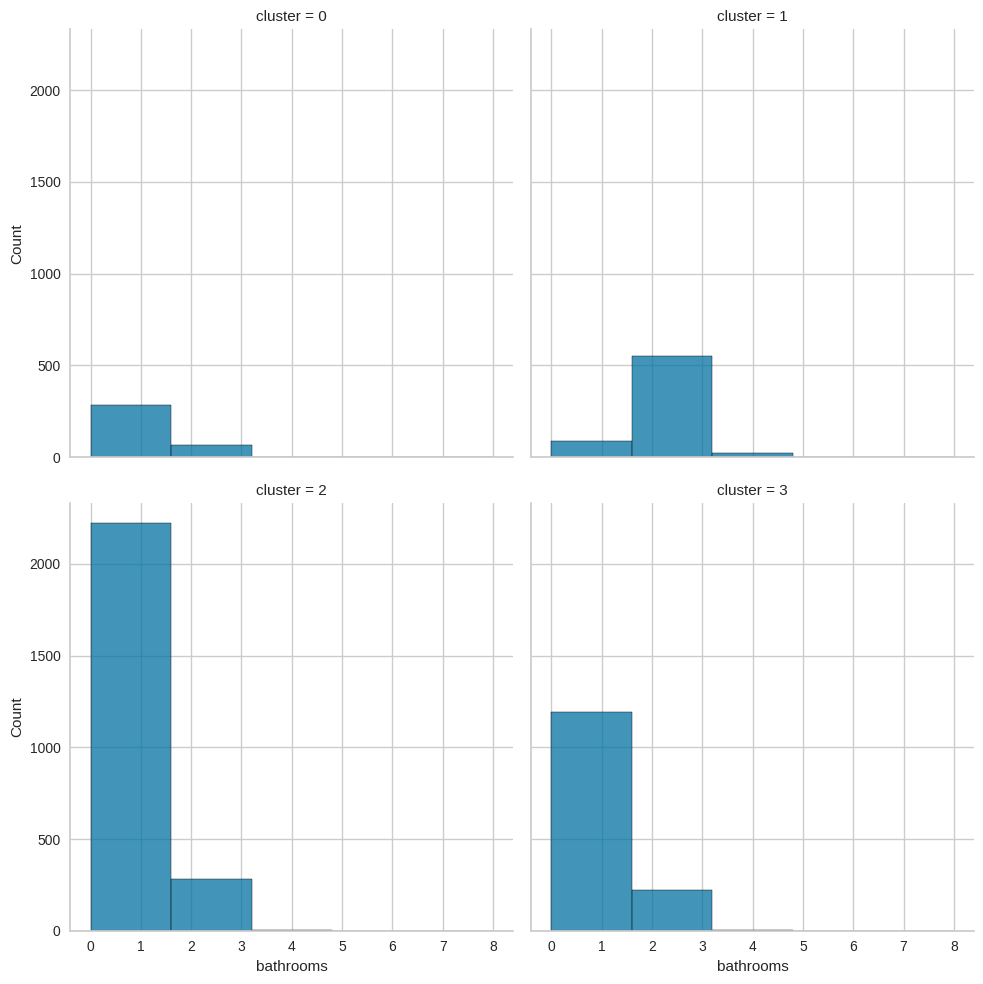

bedrooms


<Figure size 800x400 with 0 Axes>

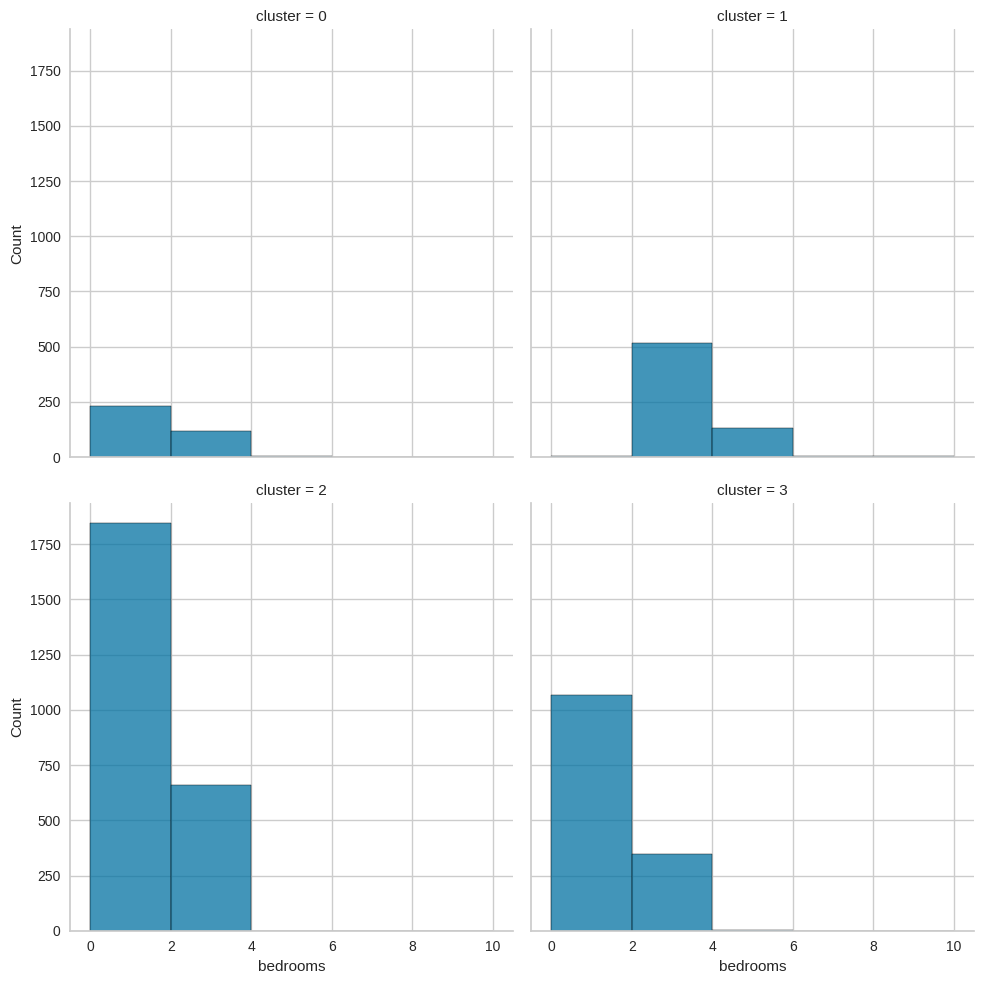

beds


<Figure size 800x400 with 0 Axes>

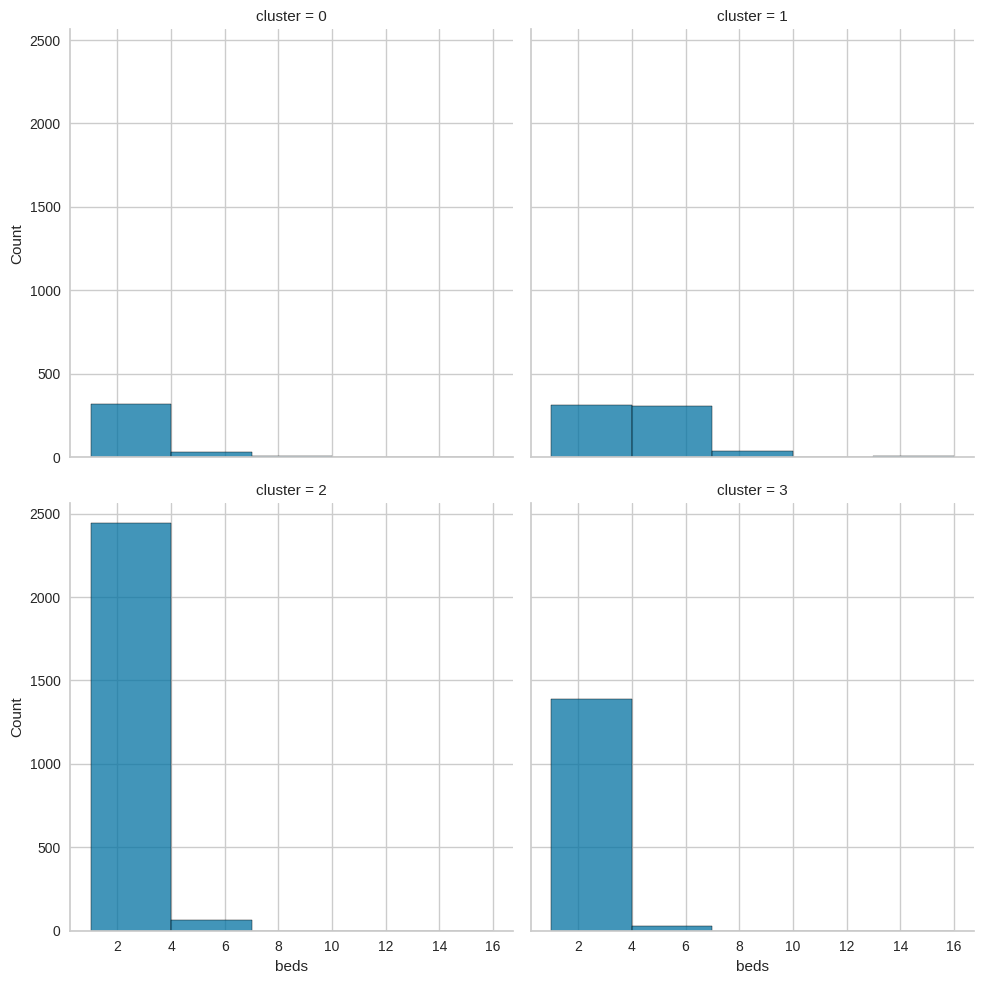

security_deposit


<Figure size 800x400 with 0 Axes>

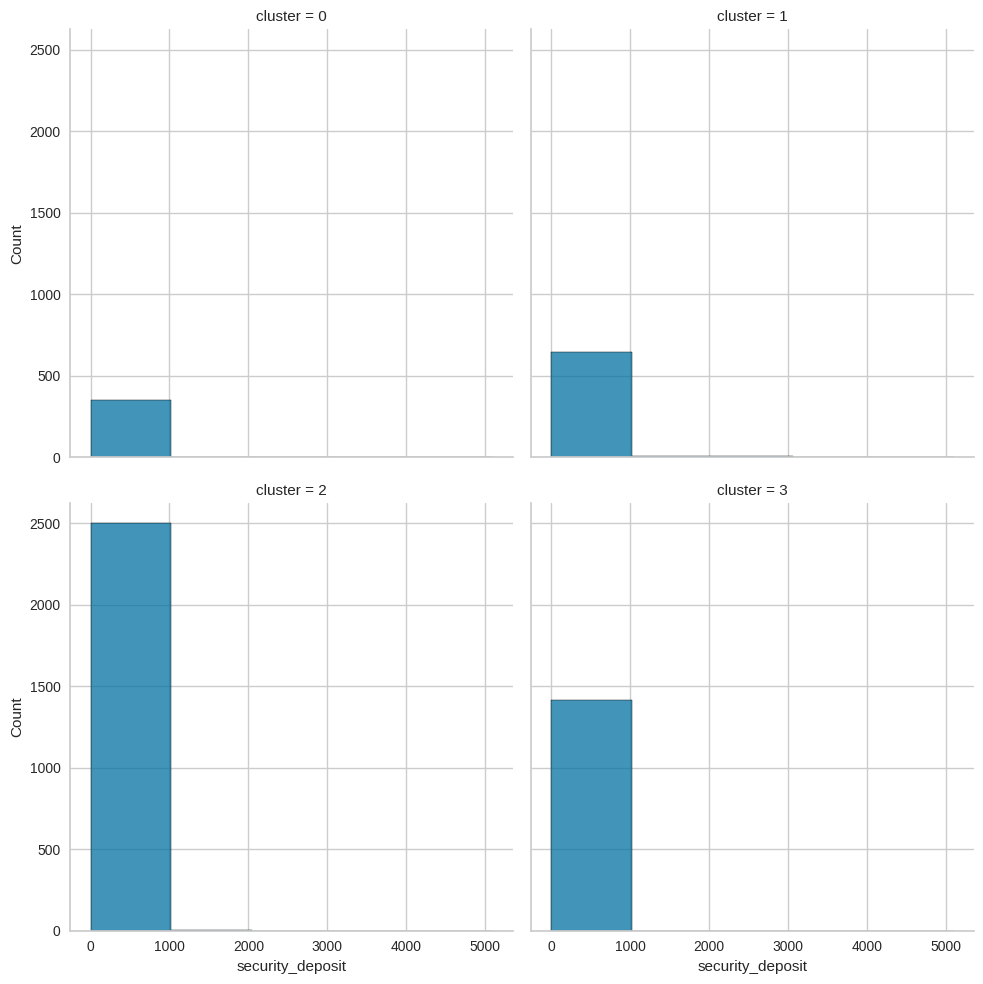

cleaning_fee


<Figure size 800x400 with 0 Axes>

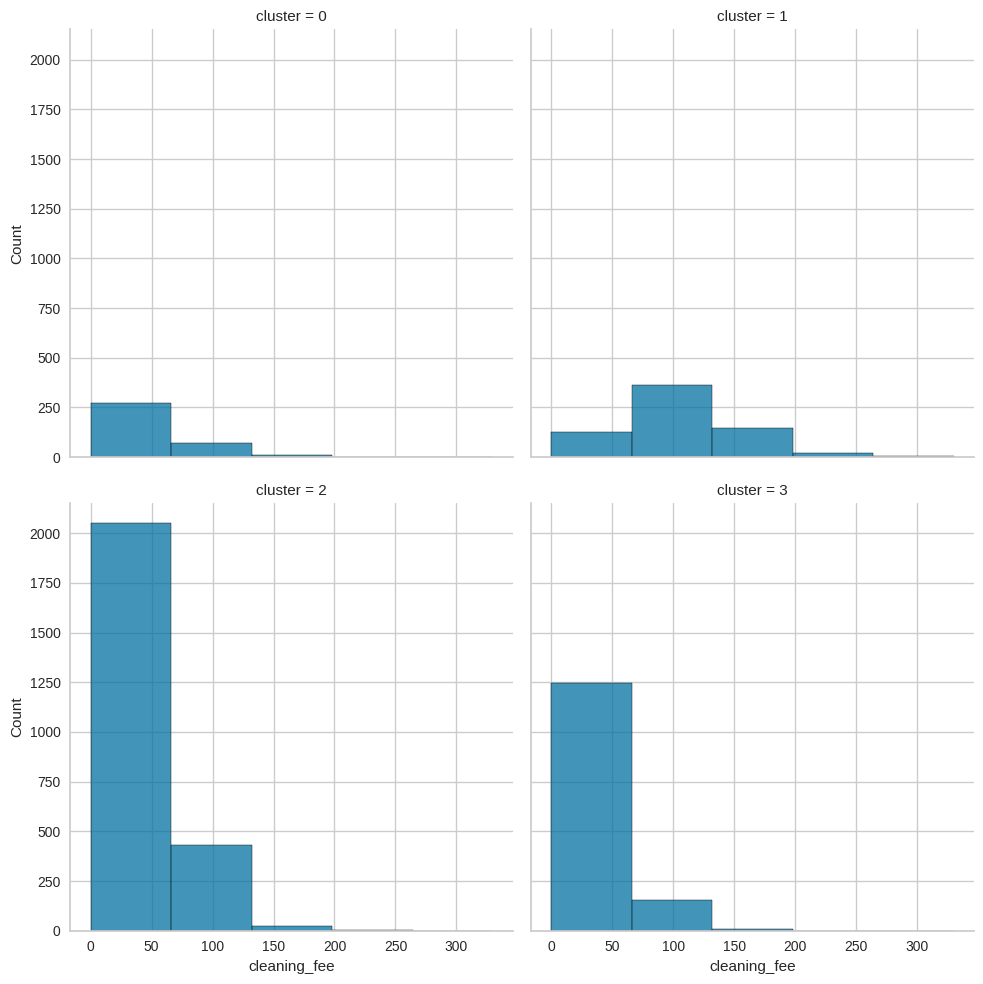

guests_included


<Figure size 800x400 with 0 Axes>

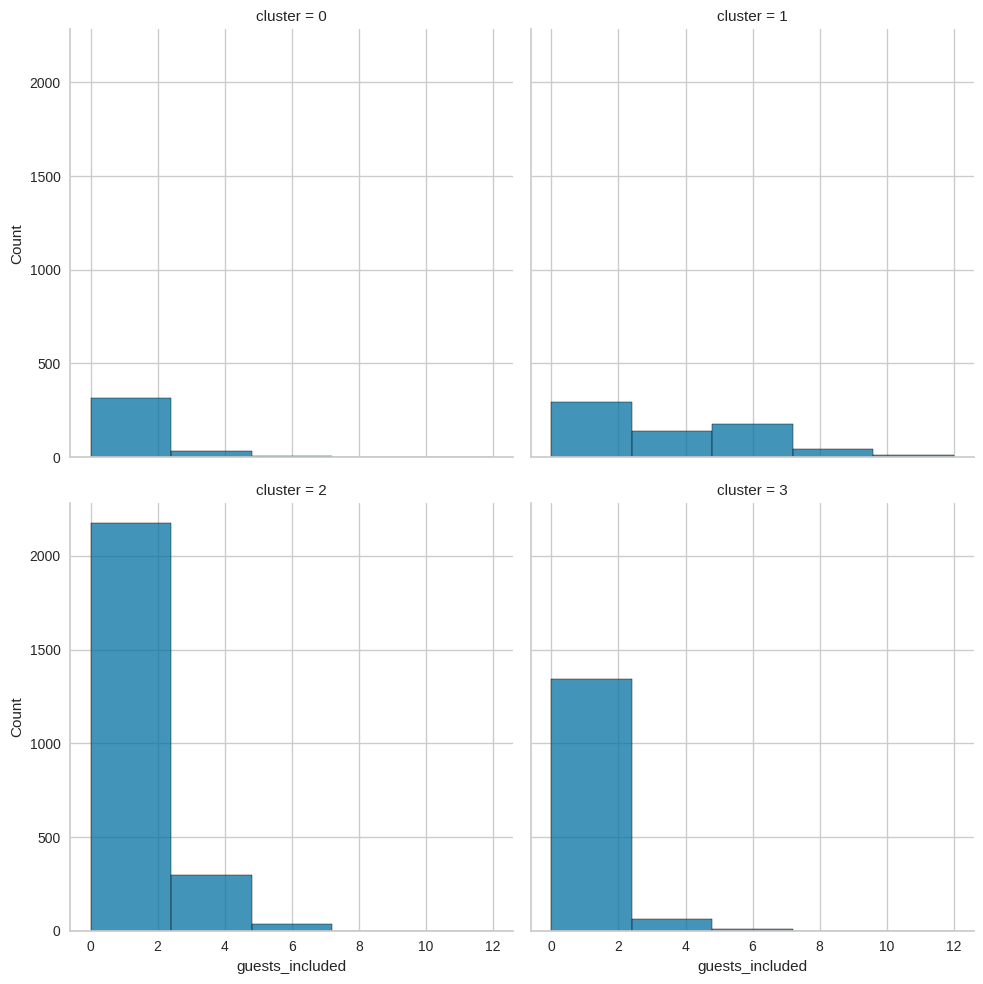

extra_people


<Figure size 800x400 with 0 Axes>

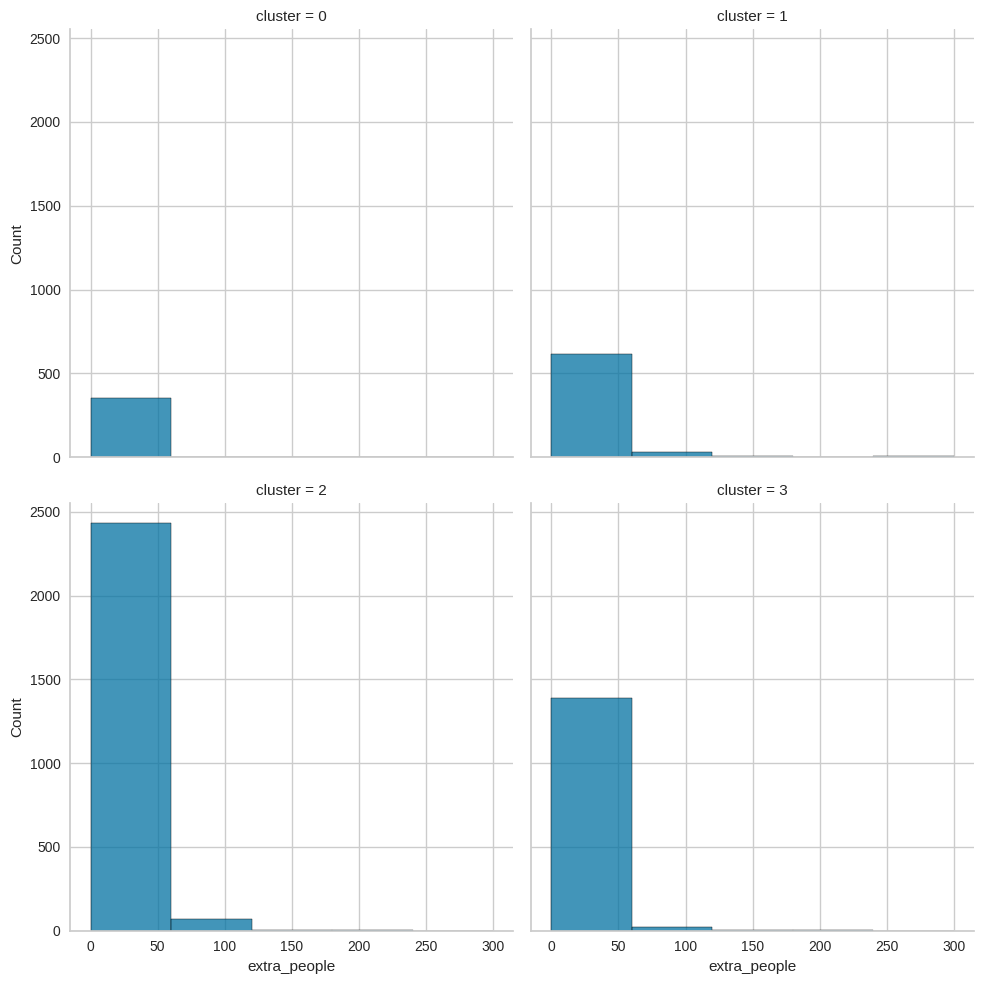

minimum_nights


<Figure size 800x400 with 0 Axes>

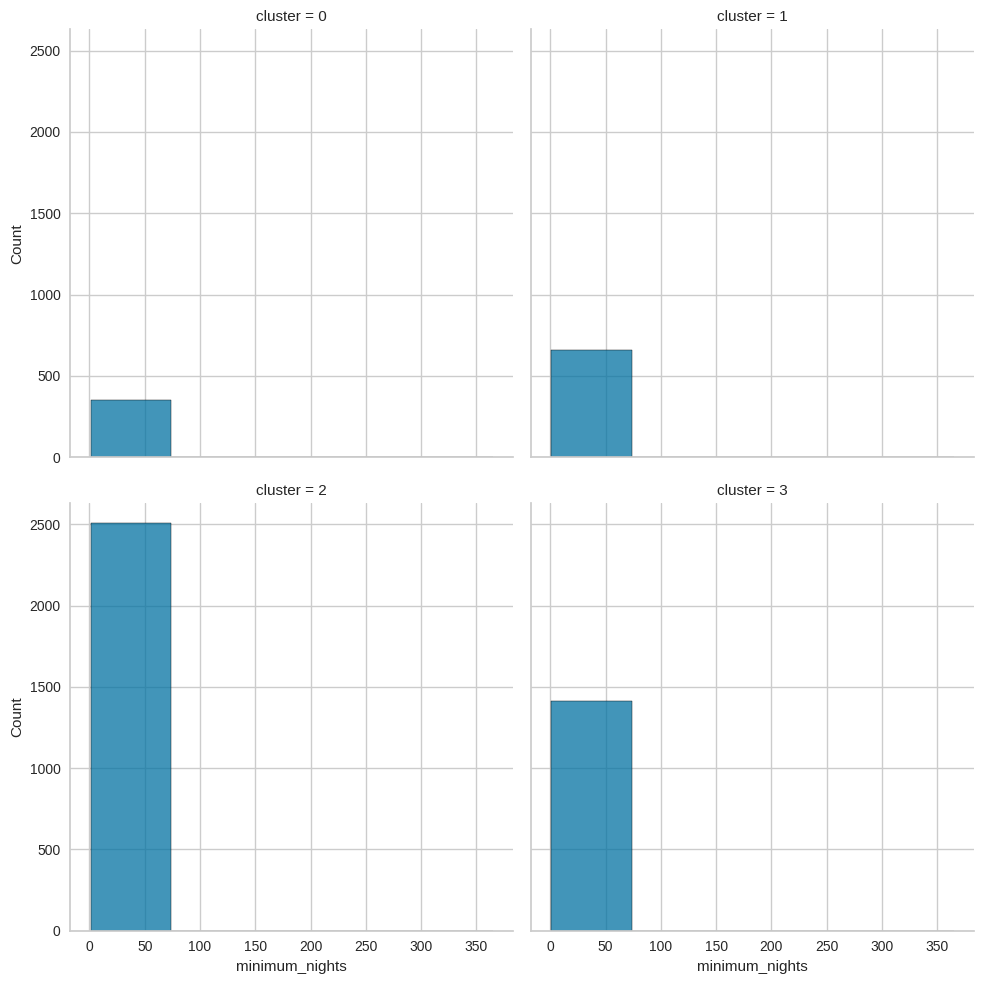

number_of_reviews


<Figure size 800x400 with 0 Axes>

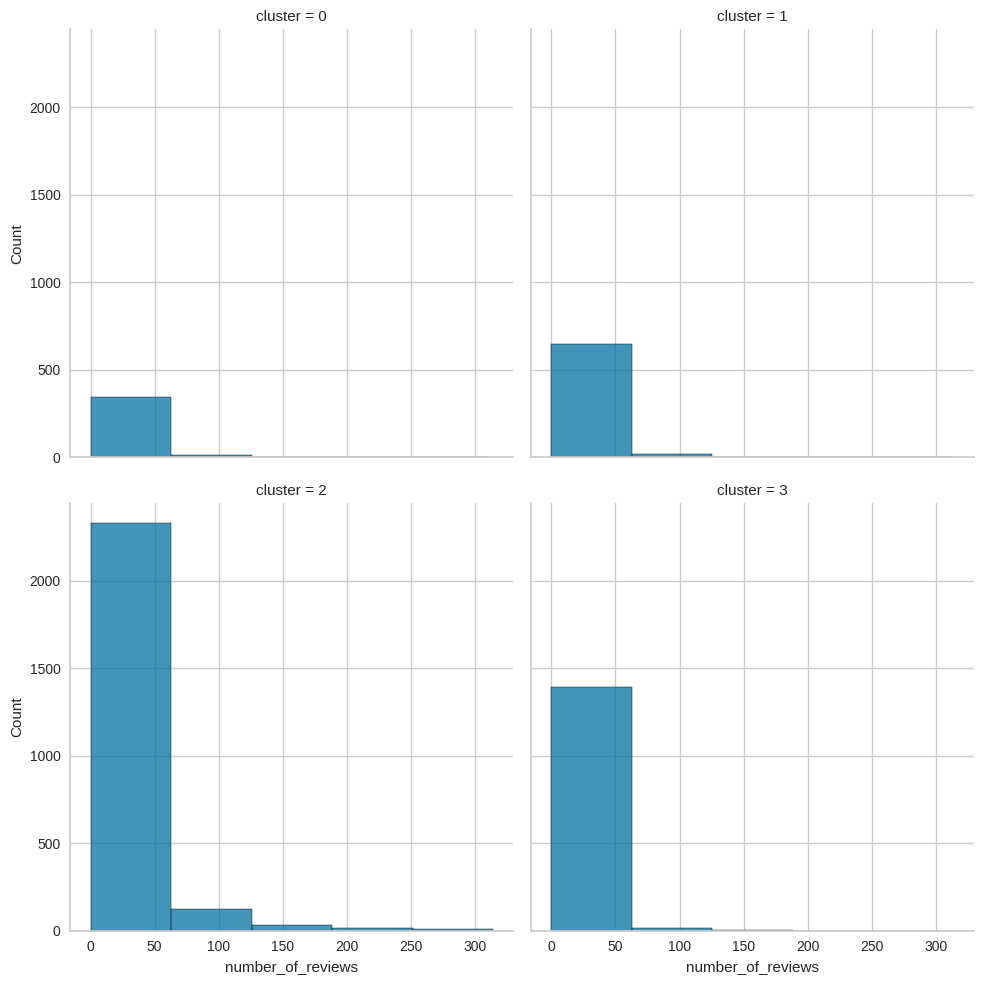

review_scores_rating


<Figure size 800x400 with 0 Axes>

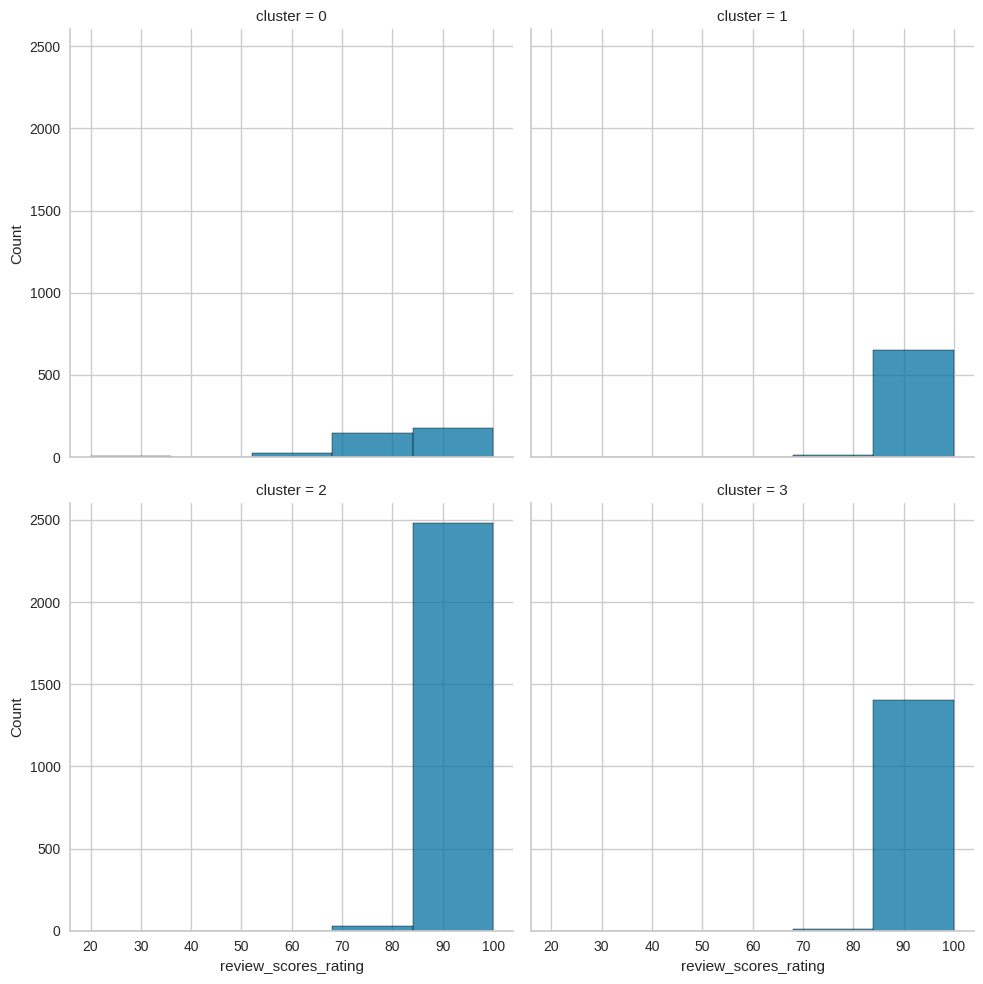

review_scores_accuracy


<Figure size 800x400 with 0 Axes>

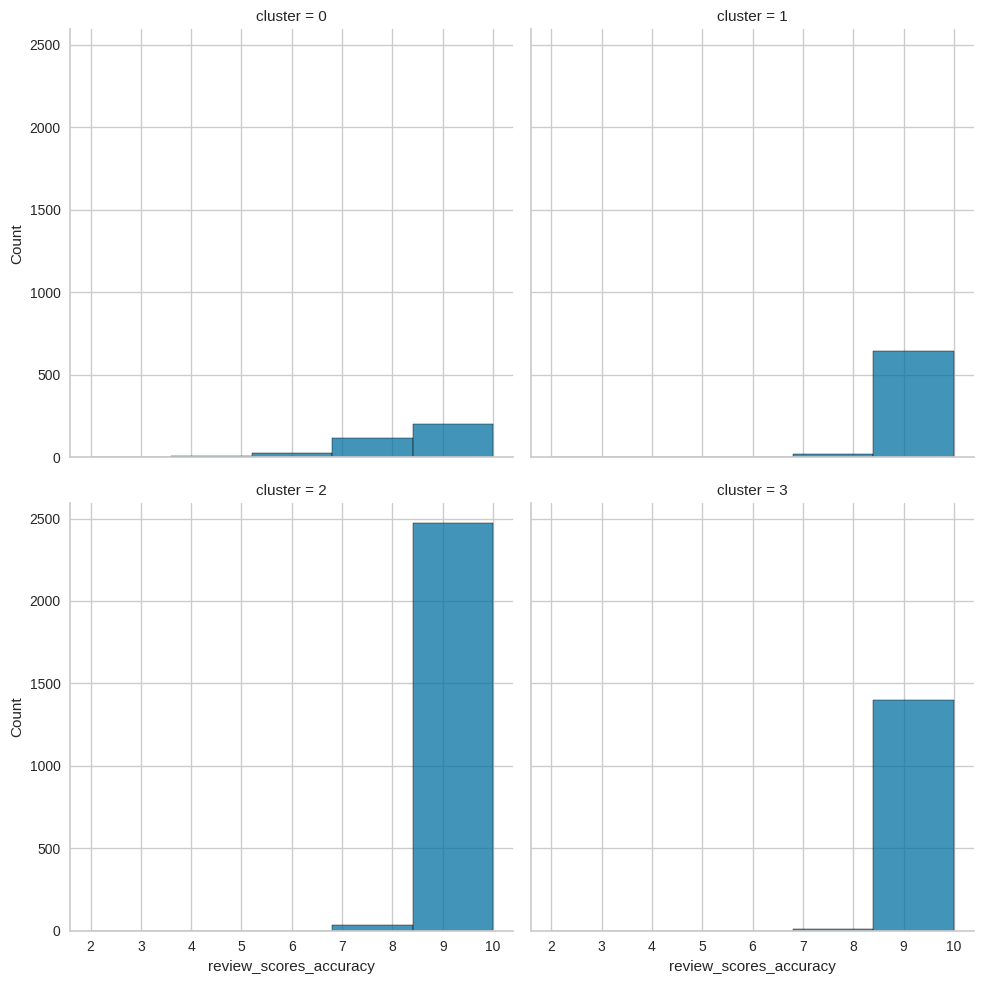

review_scores_cleanliness


<Figure size 800x400 with 0 Axes>

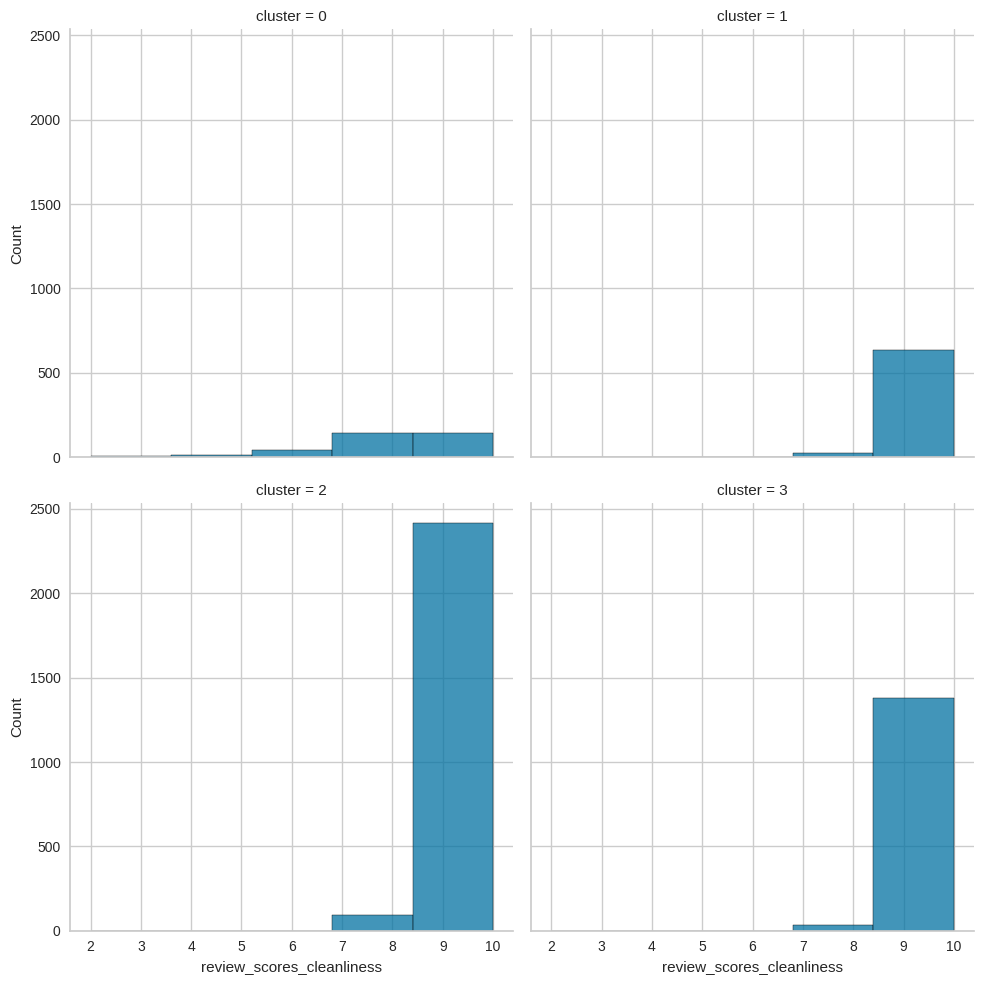

review_scores_checkin


<Figure size 800x400 with 0 Axes>

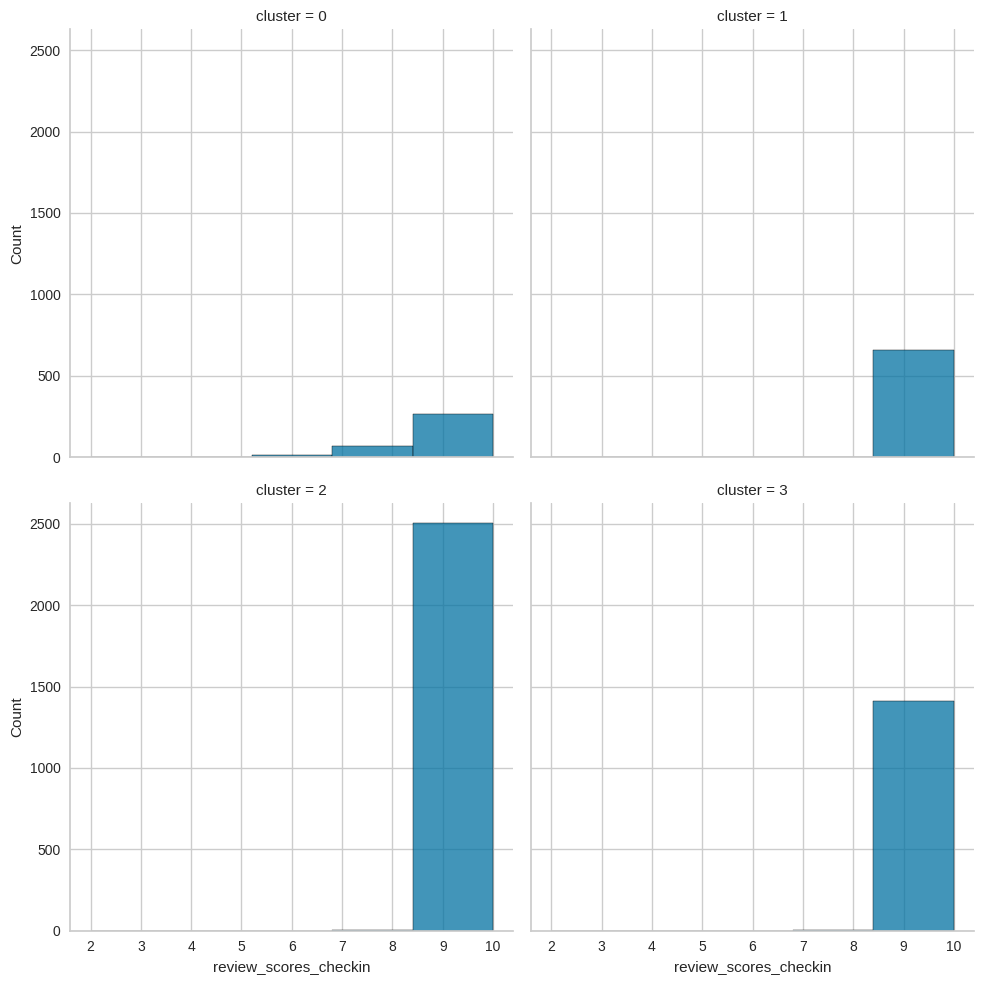

review_scores_communication


<Figure size 800x400 with 0 Axes>

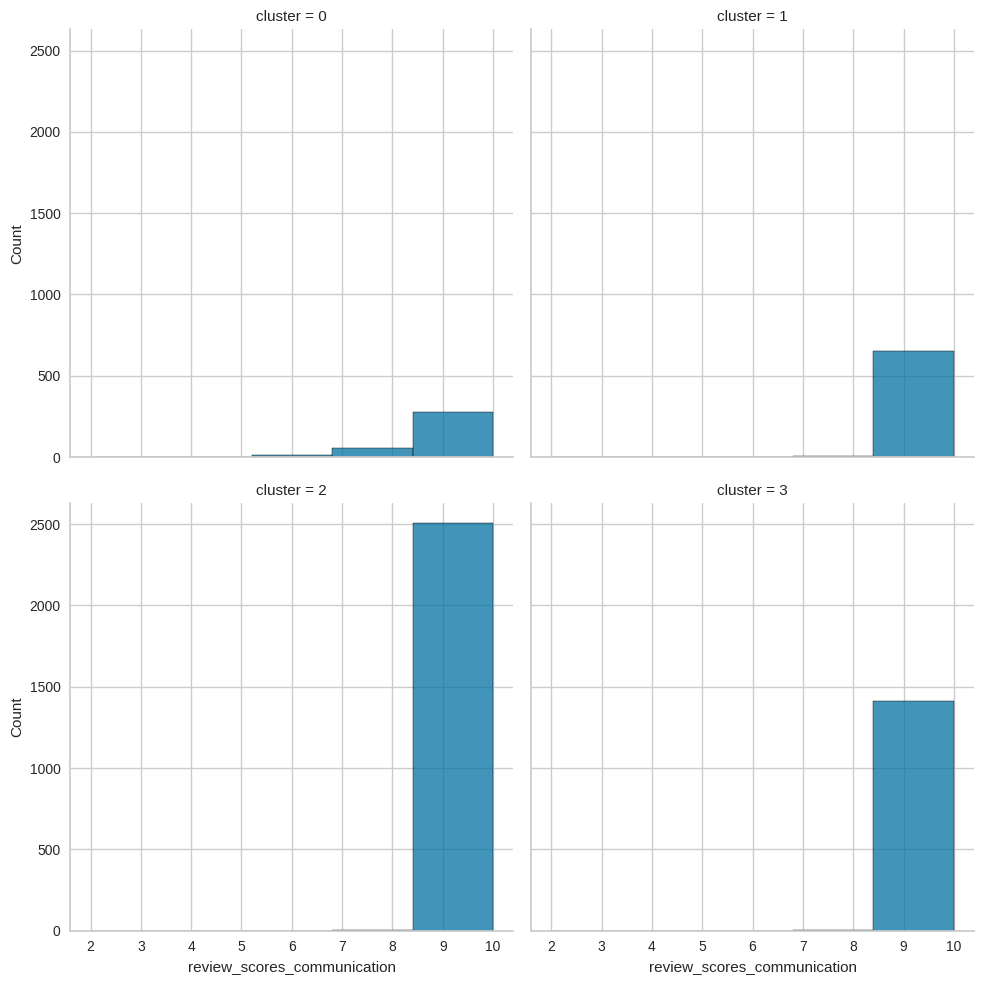

review_scores_location


<Figure size 800x400 with 0 Axes>

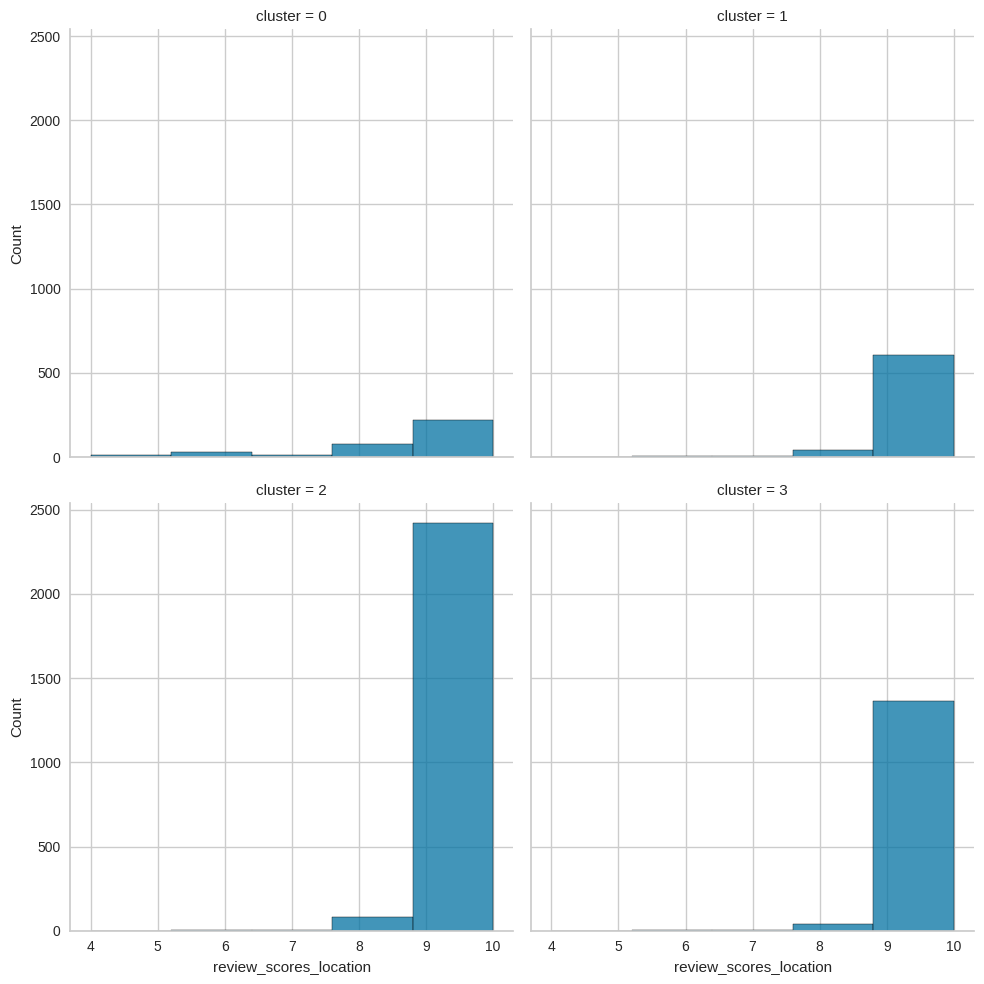

review_scores_value


<Figure size 800x400 with 0 Axes>

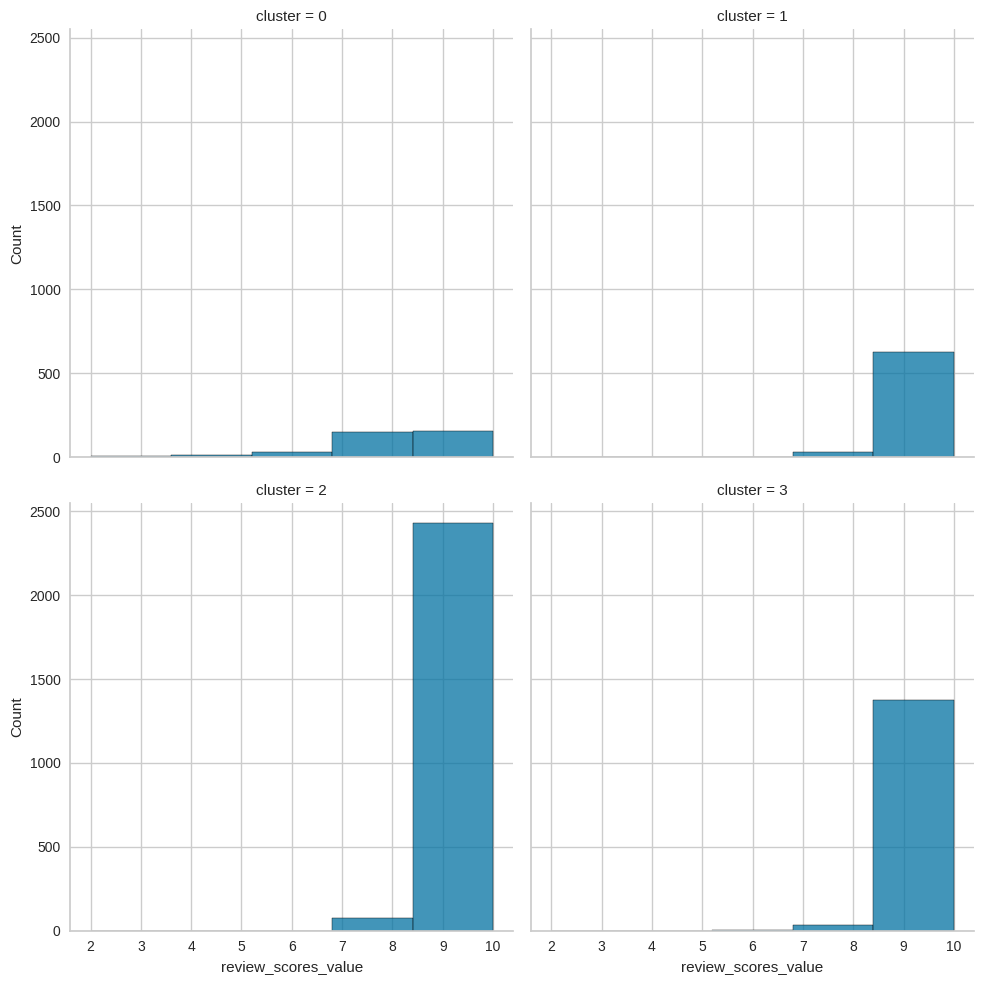

instant_bookable


<Figure size 800x400 with 0 Axes>

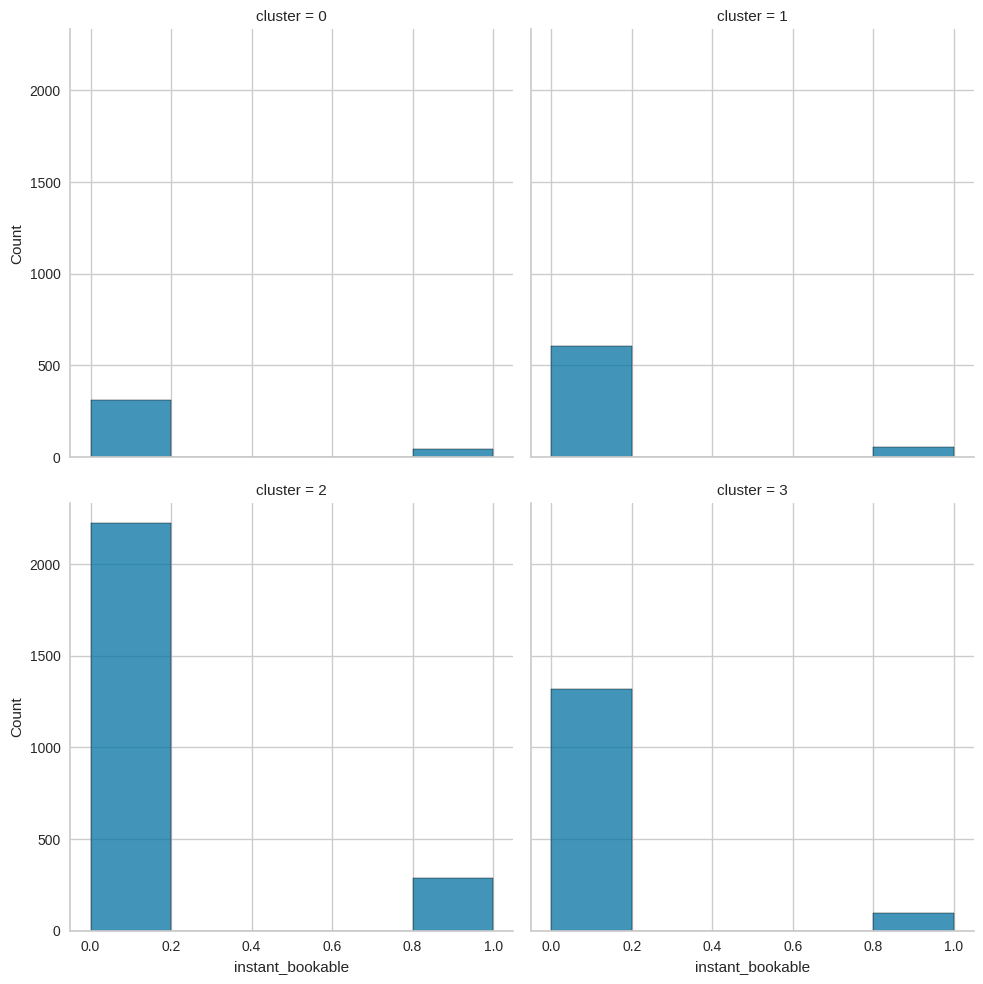

booked


<Figure size 800x400 with 0 Axes>

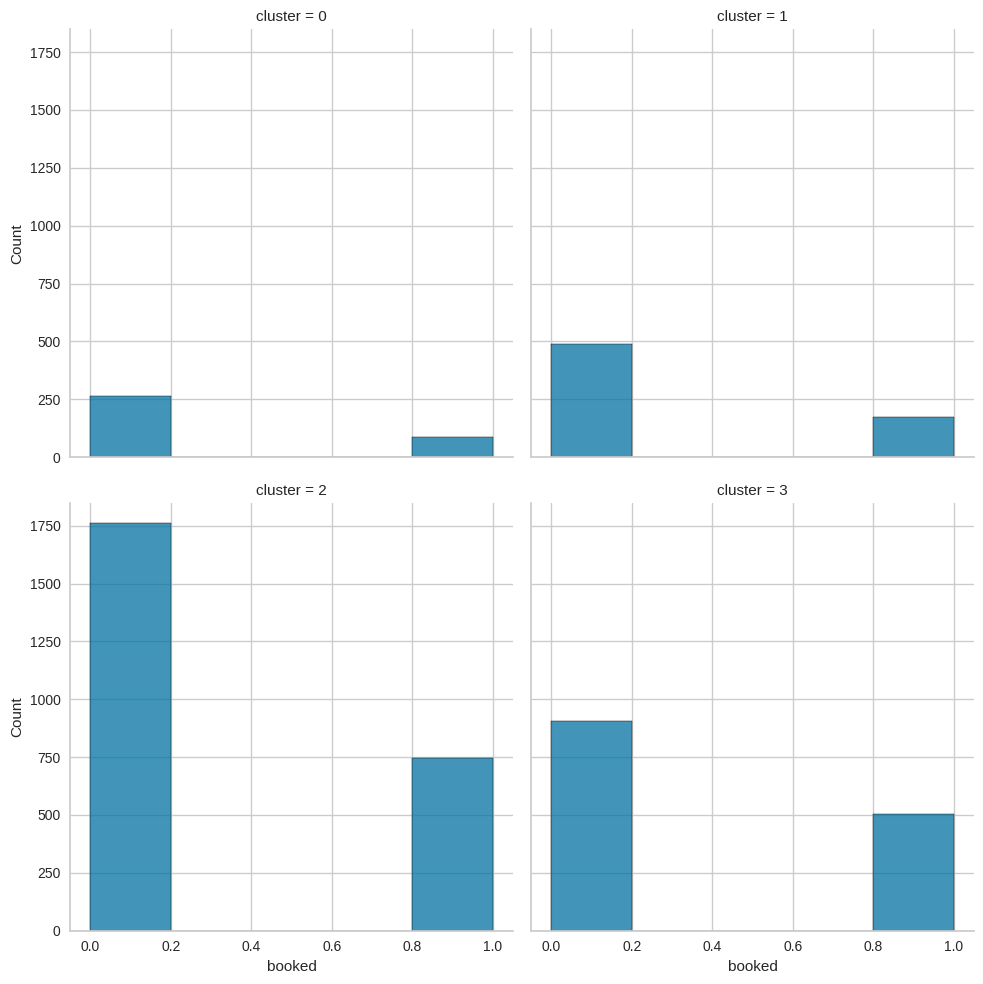

austin_name


<Figure size 800x400 with 0 Axes>

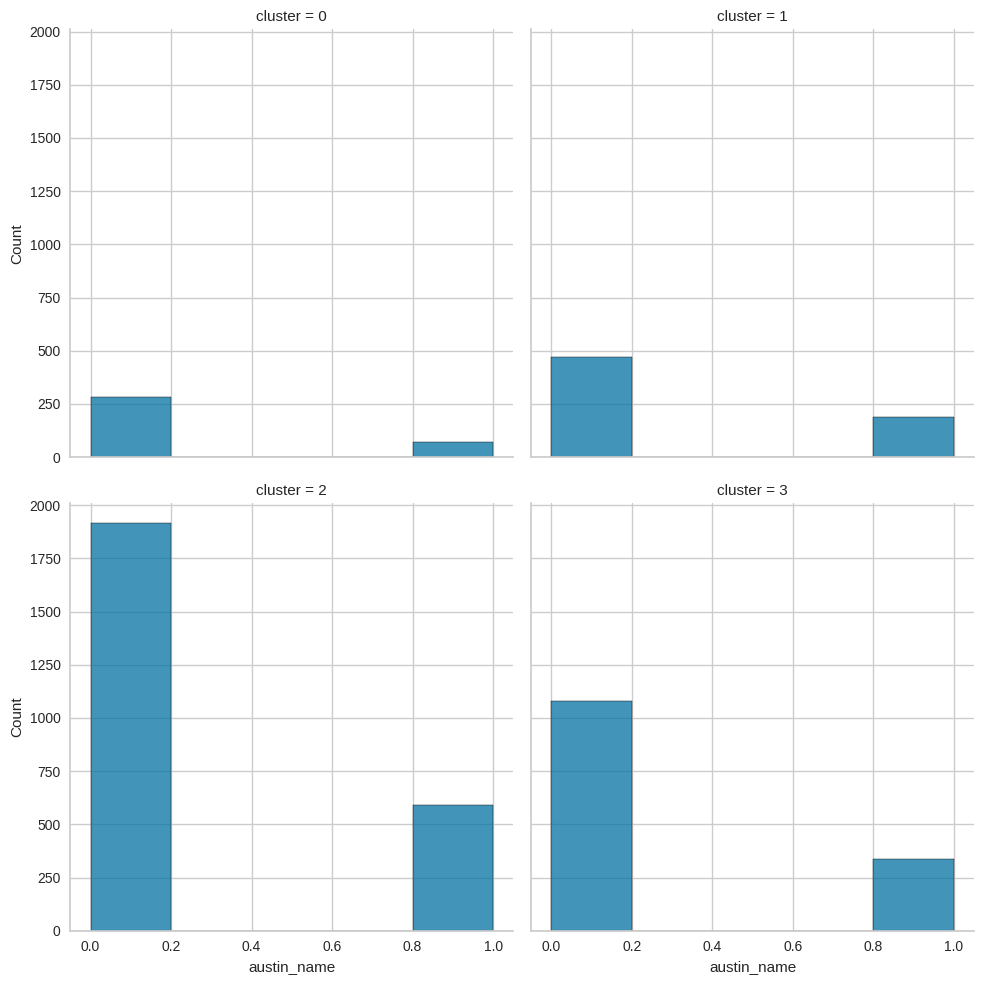

has_summary


<Figure size 800x400 with 0 Axes>

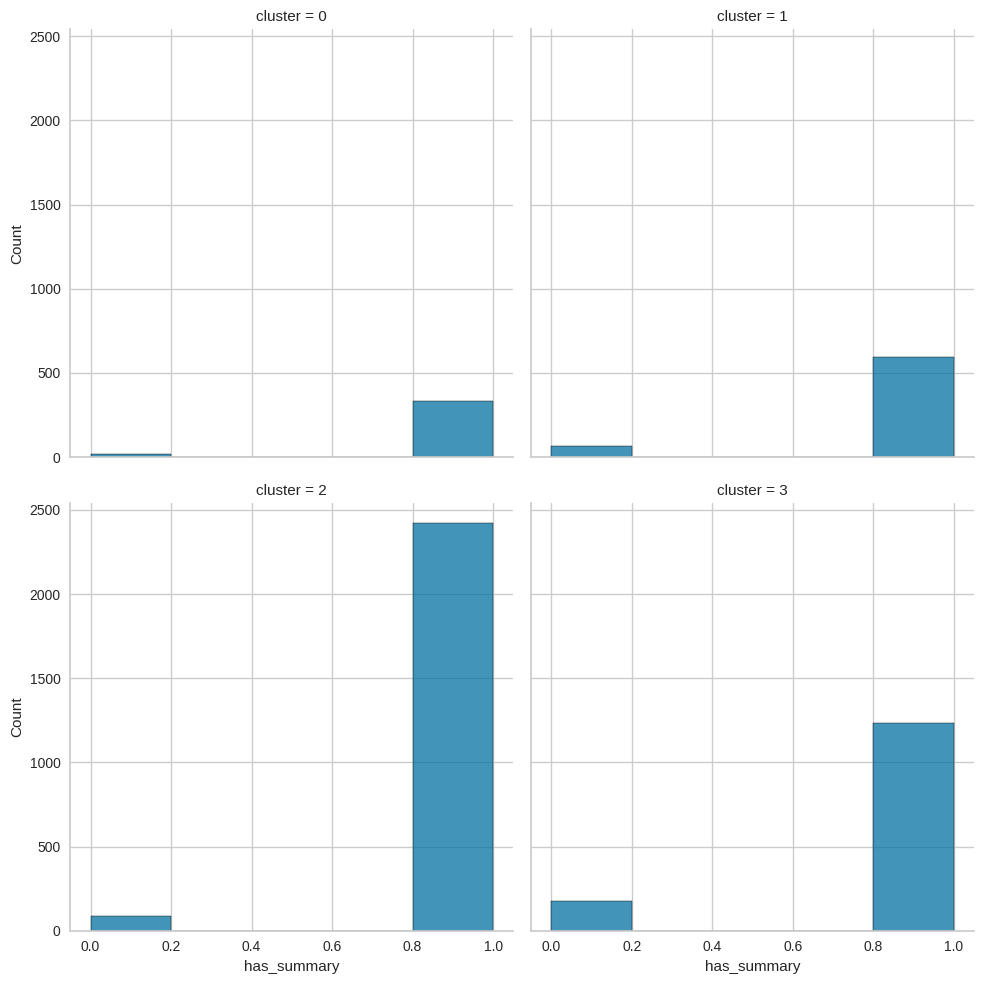

has_space


<Figure size 800x400 with 0 Axes>

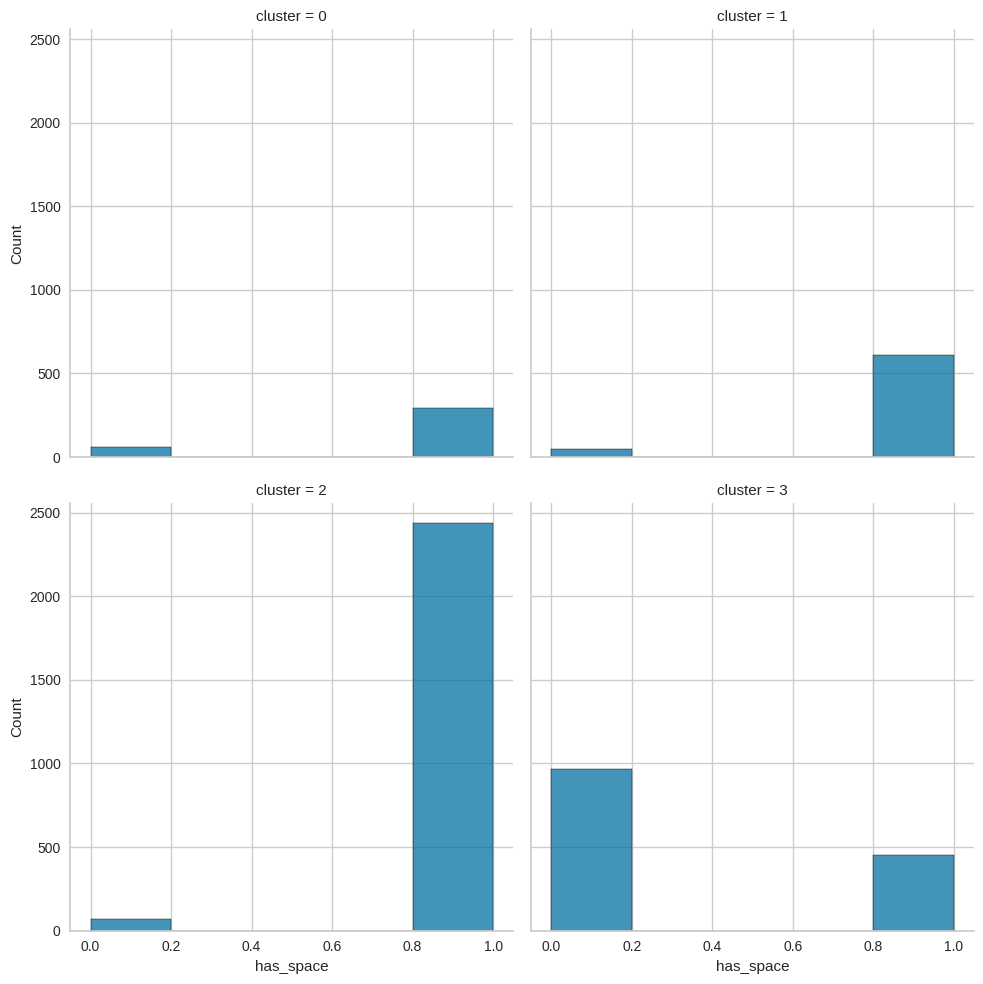

has_description


<Figure size 800x400 with 0 Axes>

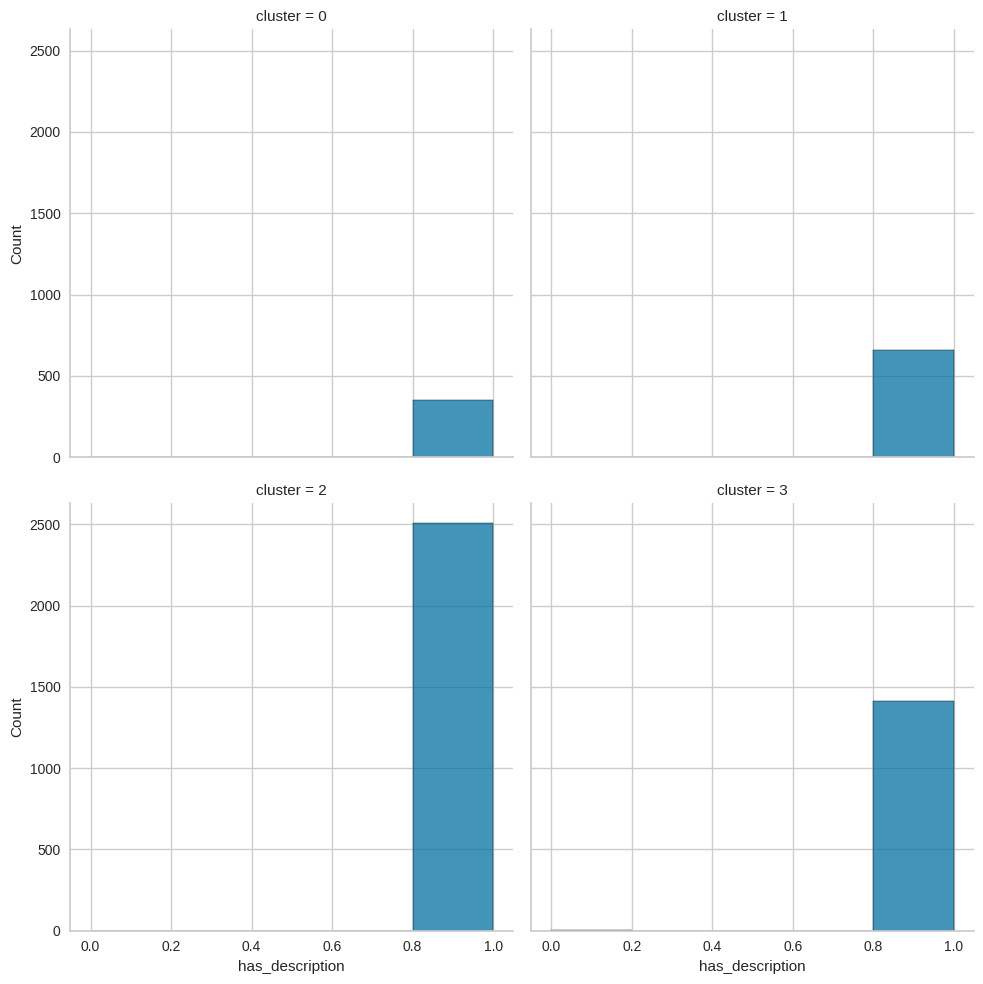

has_neighborhood


<Figure size 800x400 with 0 Axes>

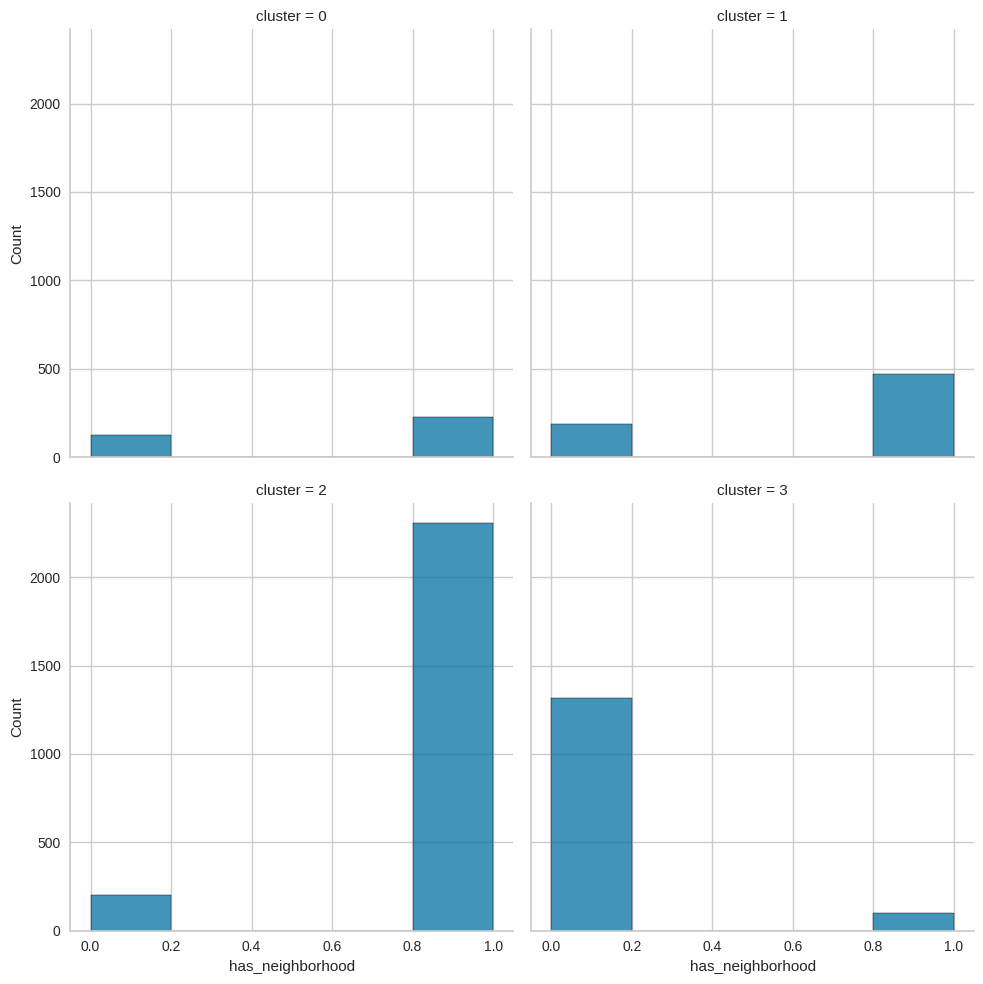

has_notes


<Figure size 800x400 with 0 Axes>

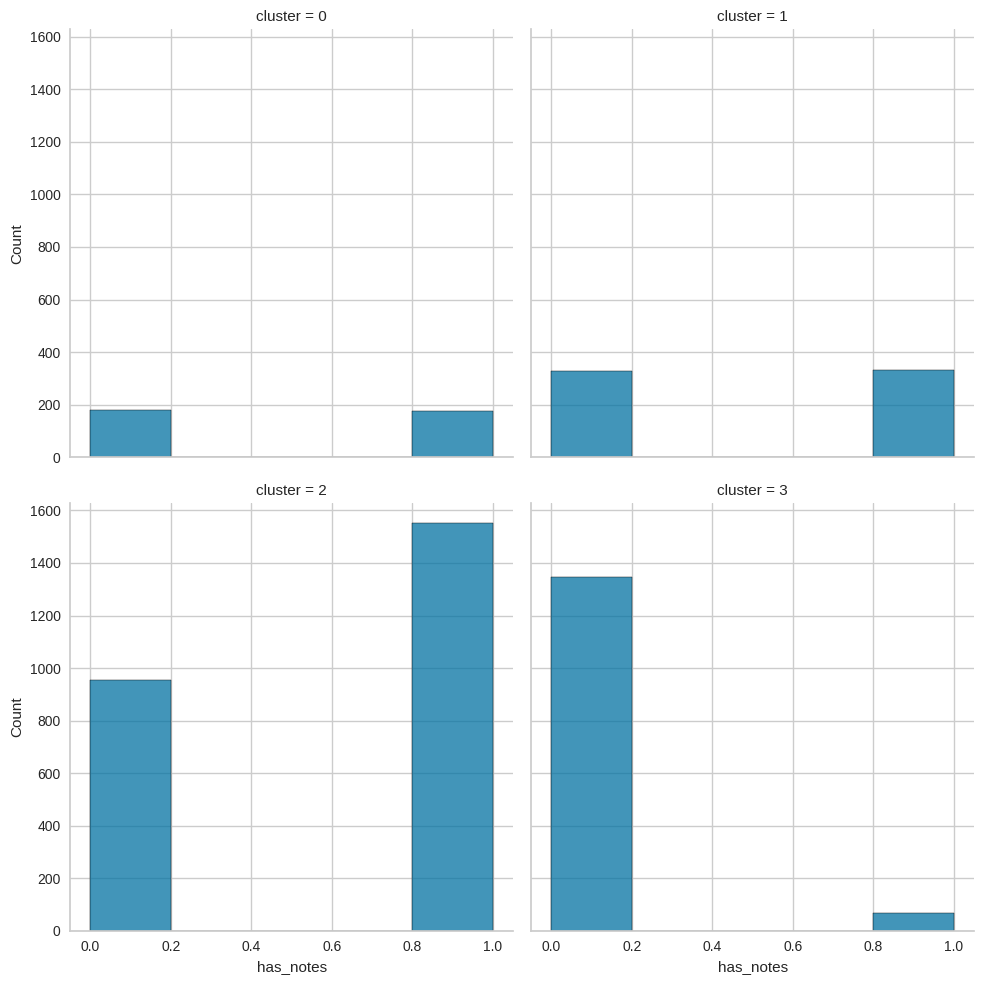

has_transit


<Figure size 800x400 with 0 Axes>

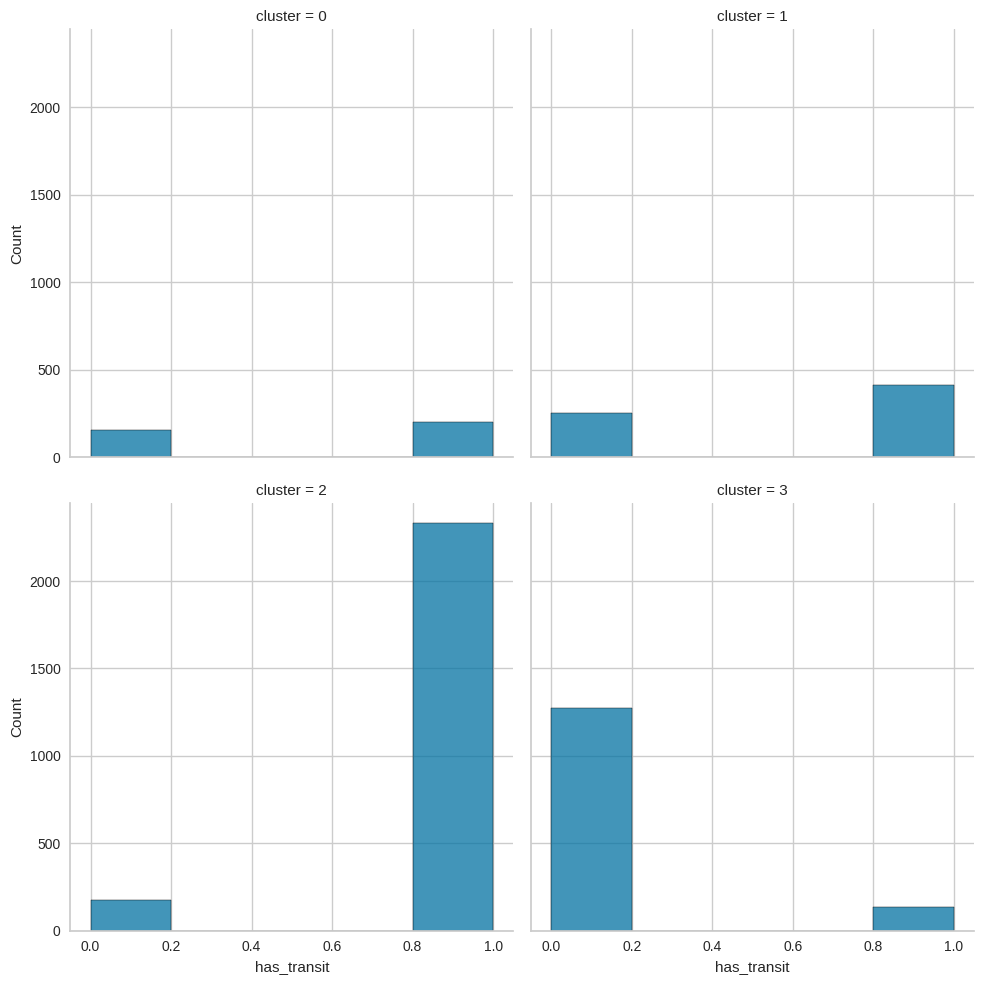

multiple_host


<Figure size 800x400 with 0 Axes>

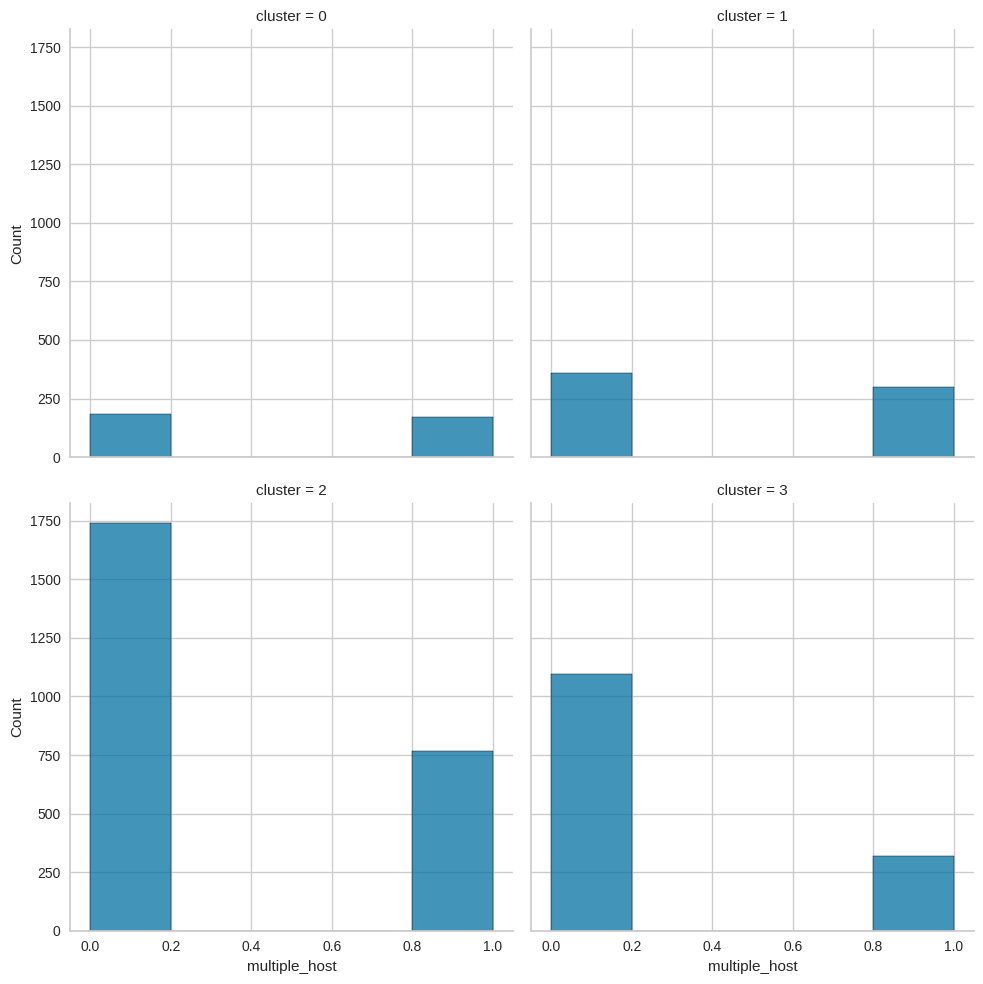

years_as_host


<Figure size 800x400 with 0 Axes>

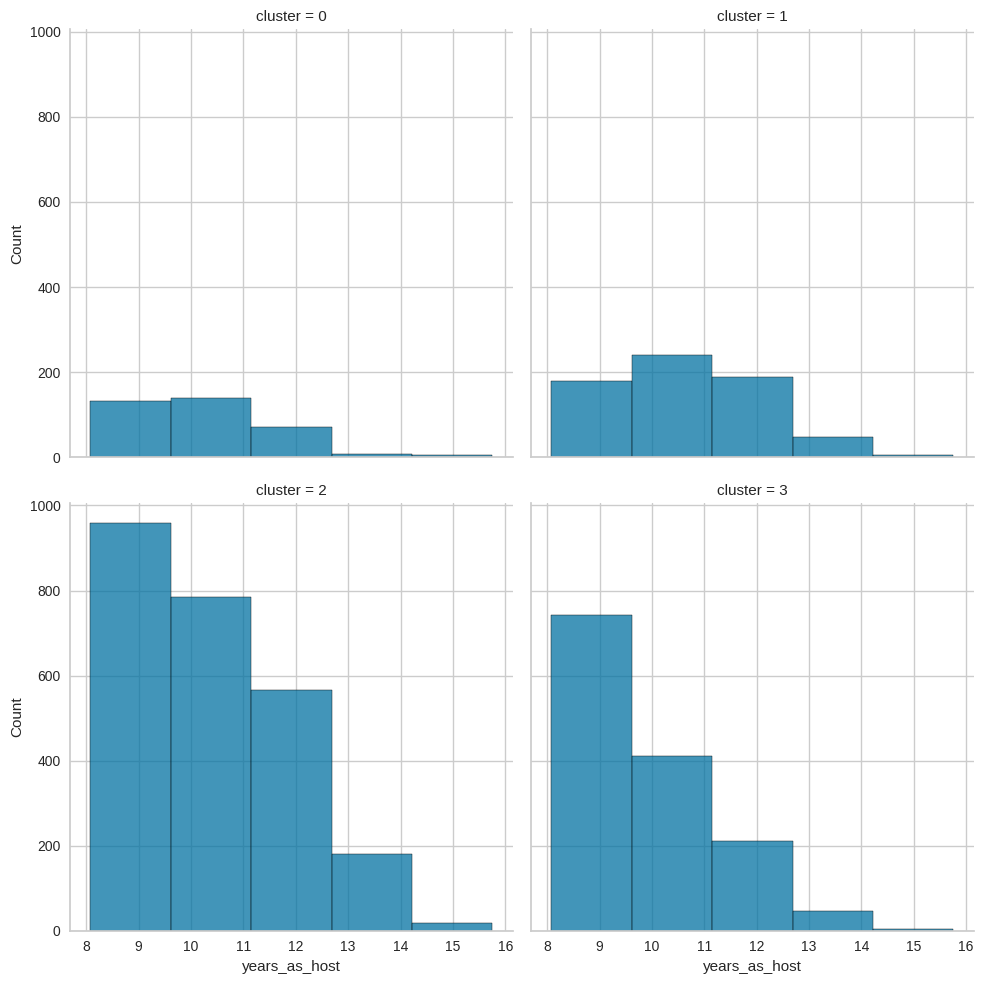

host_texas


<Figure size 800x400 with 0 Axes>

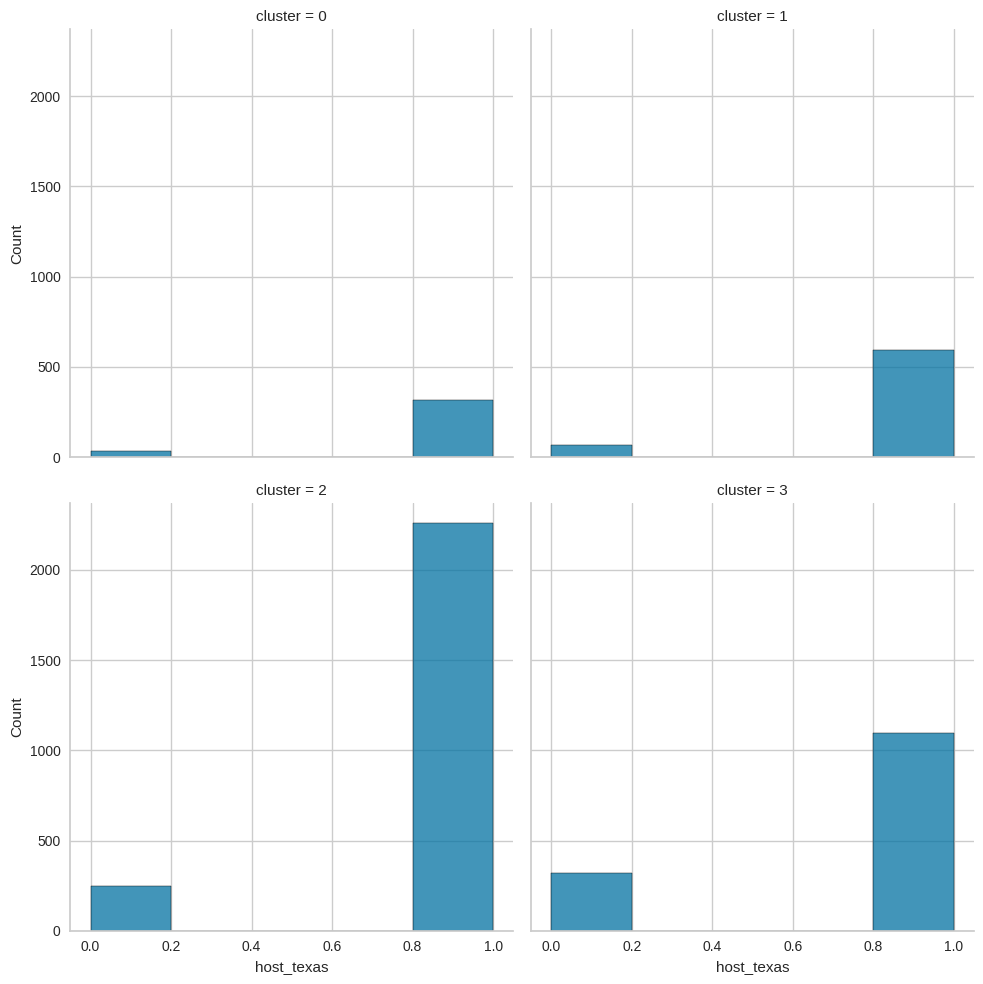

house


<Figure size 800x400 with 0 Axes>

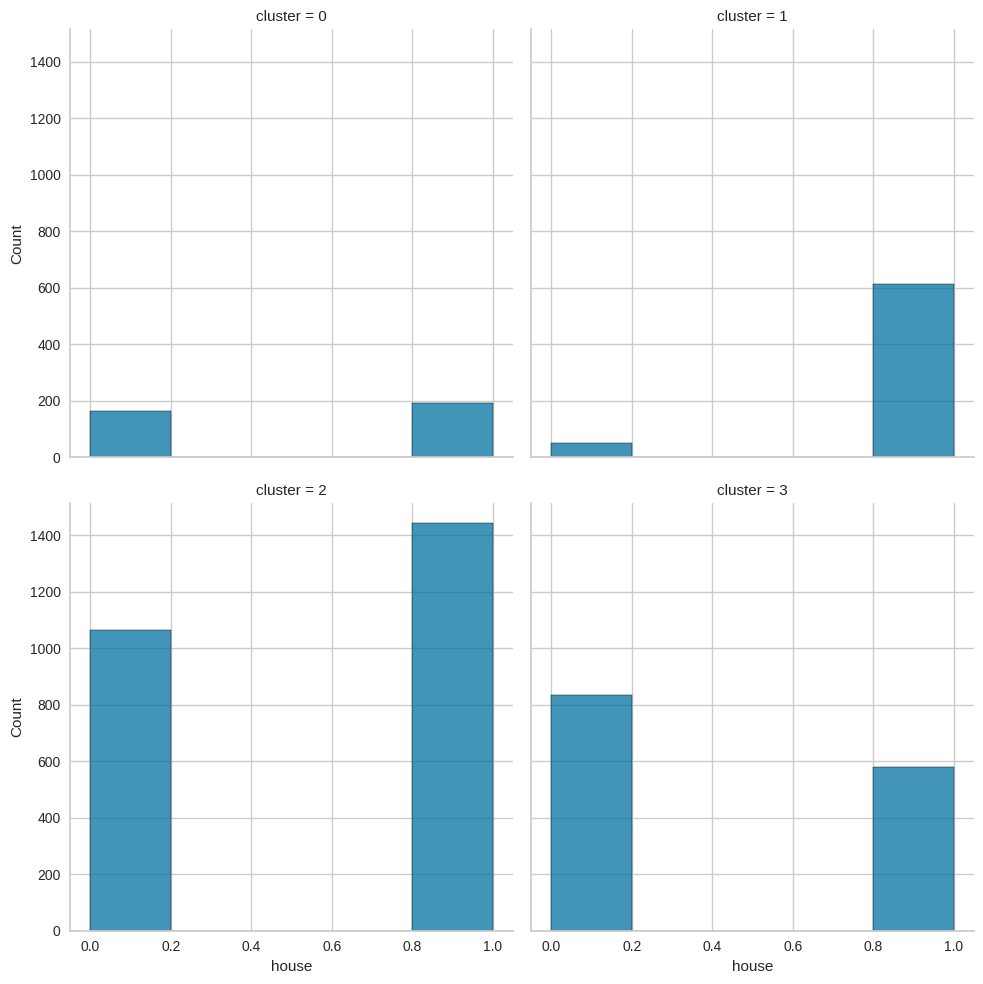

has_gym


<Figure size 800x400 with 0 Axes>

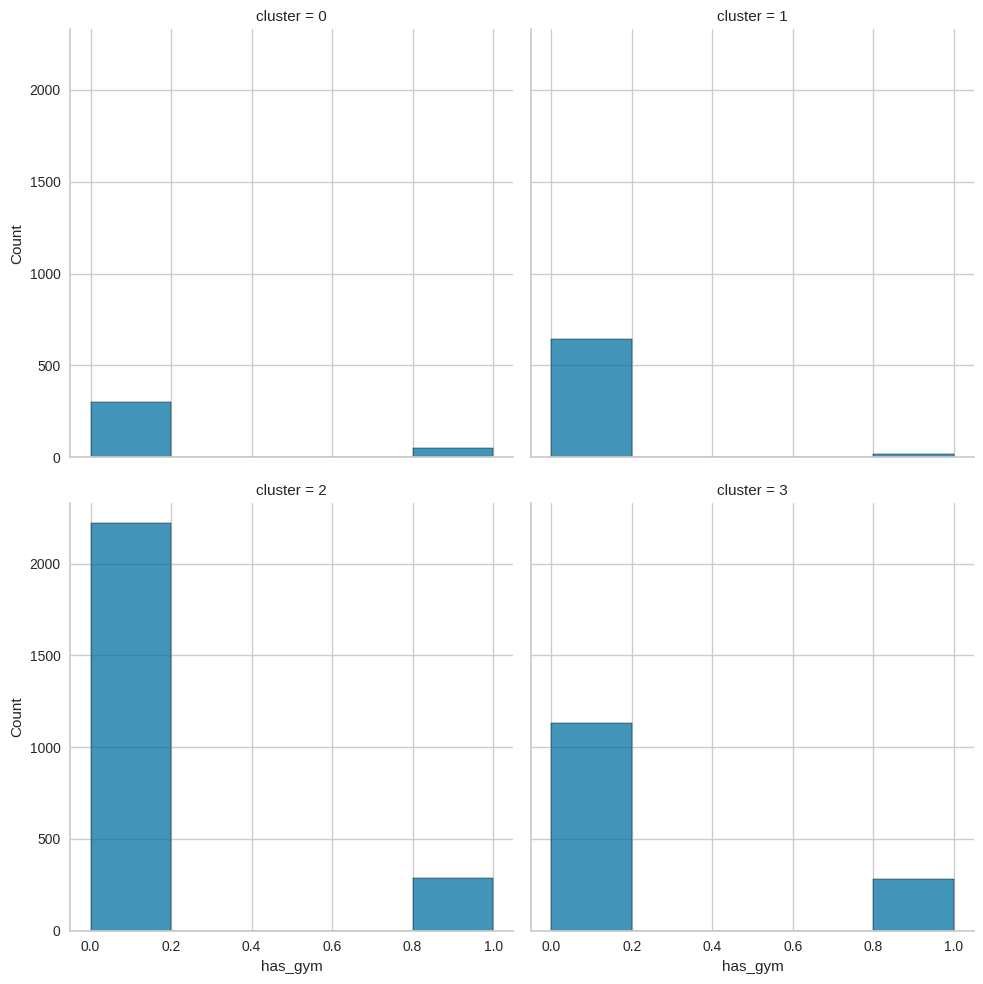

has_smoking_allowed


<Figure size 800x400 with 0 Axes>

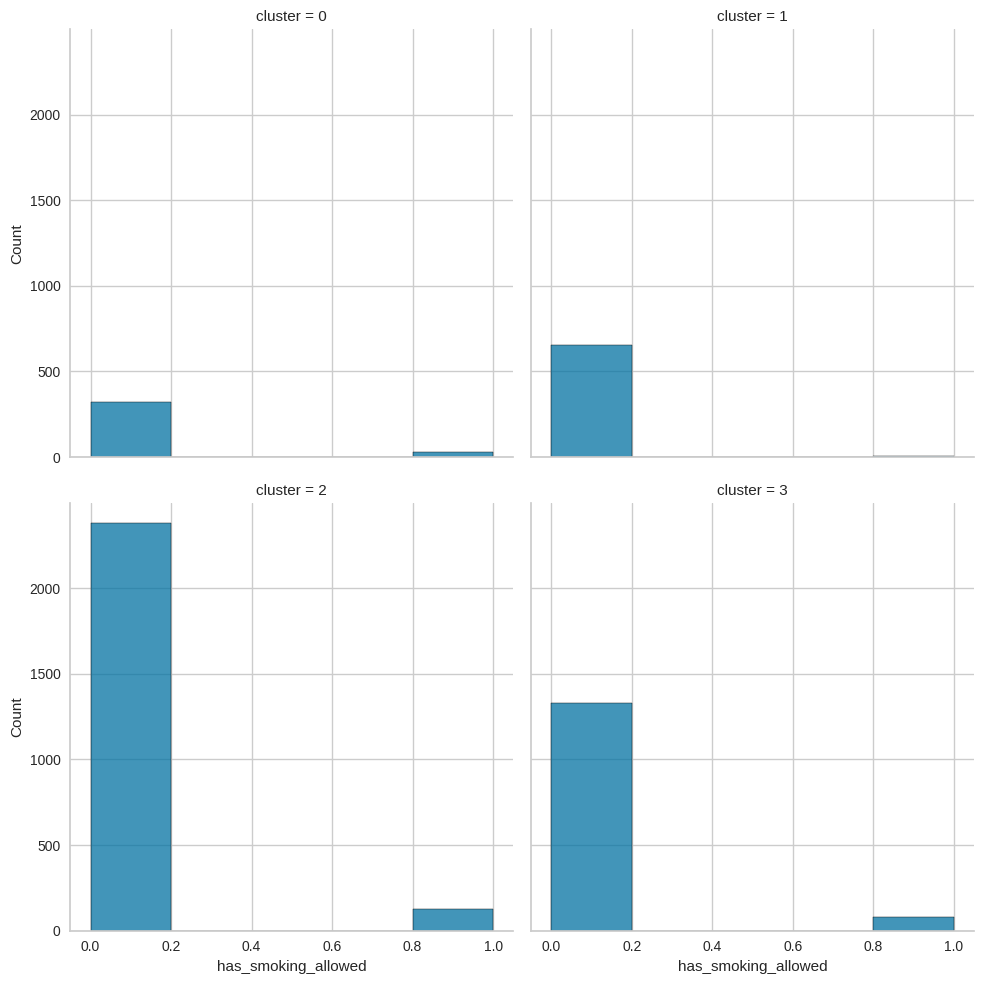

has_pool


<Figure size 800x400 with 0 Axes>

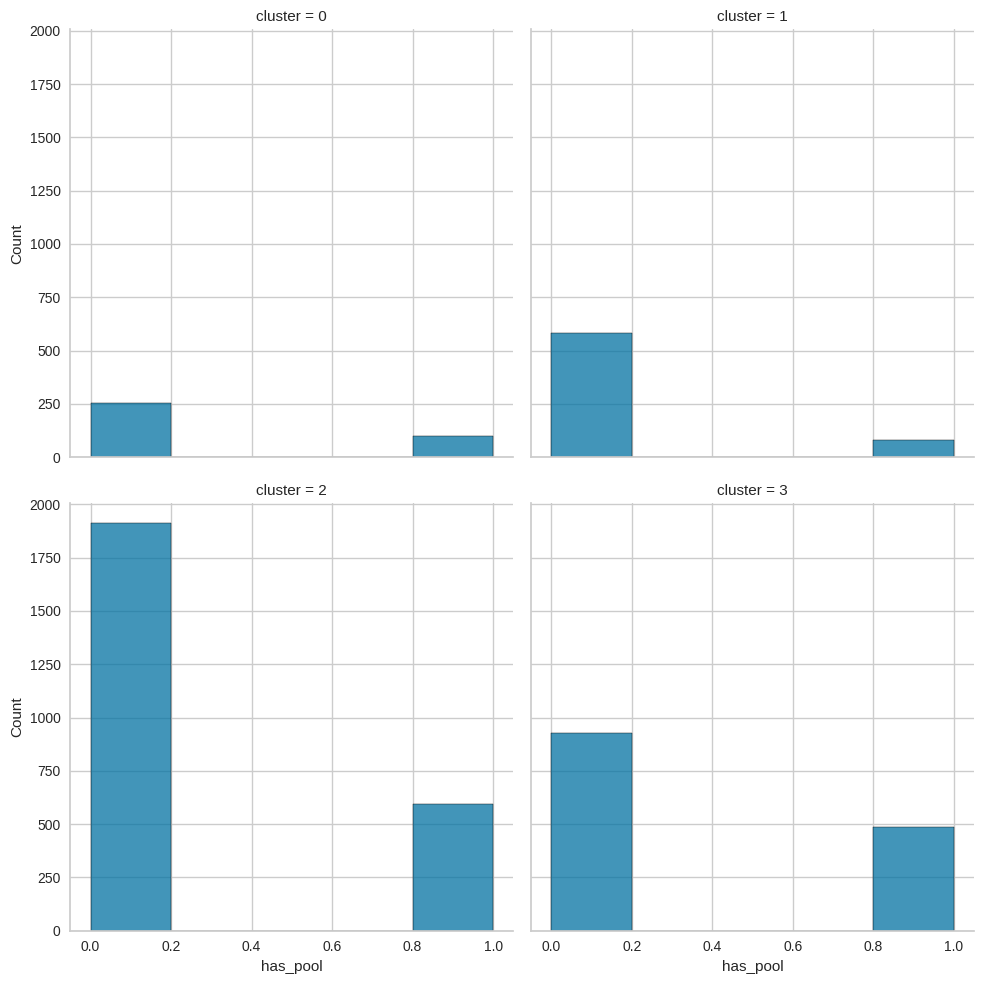

In [ ]:
cluster_col = ['price', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'booked', 'austin_name',
       'has_summary', 'has_space', 'has_description', 'has_neighborhood',
       'has_notes', 'has_transit', 'multiple_host', 'years_as_host',
       'host_texas', 'house', 'has_gym', 'has_smoking_allowed', 'has_pool']

#Romantic Movies
for col in cluster_col:
  plt.figure(figsize=(8,4))
  print(f"{col}")
  sns.displot(data=cluster_df2, x= col, bins=5, col='cluster', col_wrap=2, common_bins=True)
  plt.show()

In [ ]:
#find the mean values of price in each column by cluster
cluster_means2 = cluster_df2.groupby('cluster').mean()
cluster_means2

host_is_superhost  host_listings_count  host_has_profile_pic  \
cluster                                                                 
0                 0.025424            40.700565              1.000000   
1                 0.181543            33.800303              1.000000   
2                 0.208217             4.485840              0.998803   
3                 0.082744             2.651344              0.995050   

         host_identity_verified  accommodates  bathrooms  bedrooms      beds  \
cluster                                                                        
0                      0.779661      3.895480   1.258475  1.429379  1.929379   
1                      0.809380      7.593041   2.177761  3.075643  4.033283   
2                      0.745911      3.310730   1.154767  1.234144  1.609095   
3                      0.503536      3.159123   1.195191  1.235502  1.490099   

              price  security_deposit  ...  has_neighborhood  has_notes  \
cluster                                ...                                
0        140.545198        112.395480  ...          0.641243   0.491525   
1        298.118003        351.692890  ...          0.715582   0.502269   
2        141.797367        133.792182  ...          0.919426   0.618668   
3        175.789958         75.040311  ...          0.070721   0.048091   

         has_transit  multiple_host  years_as_host  host_texas     house  \
cluster                                                                    
0           0.567797       0.485876      10.236468    0.901130  0.542373   
1           0.621785       0.455371      10.694547    0.895613  0.924357   
2           0.929398       0.306342      10.330458    0.900678  0.575189   
3           0.097595       0.224894       9.769288    0.774399  0.410891   

          has_gym  has_smoking_allowed  has_pool  
cluster                                           
0        0.146893             0.090395  0.279661  
1        0.022693             0.013616  0.118003  
2        0.114878             0.051057  0.237734  
3        0.198020             0.057992  0.345120  

[4 rows x 38 columns]

Note that cluster 1 has the highest average price (~$300)

Some other distinguishing characteristics for cluster 1:


*   Highest proportion of verified hosts
*   Largest average number of bathrooms, bedrooms, and guests accommodated
*   About three more beds on average than other clusters
*   Higher security deposit and cleaning fee
*   All of the listings in cluster 1 have a description
*   Have longest average years as host
*   Most properties in this cluster are classified as houses




Cluster 0 has the lowest average price (barely), some distinguishing features:



*   All other clusters have an average review rating of about 97 while cluster 0 has one of 82 (lowest review ratings)
*   All listings in this cluster also have a description
*   Have highest proportion of hosts who live in Texas
*   Highest proportion of smoking allowed properties








In [ ]:
#Notice cluster 0 has the lowest (not by much though) mean price, so find mean values for all columns in cluster 0:
cluster0 = cluster_df2.groupby('cluster').mean().loc[0]
print(cluster0)

host_is_superhost                0.025424
host_listings_count             40.700565
host_has_profile_pic             1.000000
host_identity_verified           0.779661
accommodates                     3.895480
bathrooms                        1.258475
bedrooms                         1.429379
beds                             1.929379
price                          140.545198
security_deposit               112.395480
cleaning_fee                    37.039548
guests_included                  1.477401
extra_people                    10.262712
minimum_nights                   2.118644
number_of_reviews                9.728814
review_scores_rating            82.124294
review_scores_accuracy           8.387006
review_scores_cleanliness        7.901130
review_scores_checkin            8.918079
review_scores_communication      8.994350
review_scores_location           8.556497
review_scores_value              8.039548
instant_bookable                 0.127119
booked                           0

In [ ]:
#Notice that the mean price in cluster 1 is higher than other clusters, so find mean values for all columns in cluster 1:
cluster1 = cluster_df2.groupby('cluster').mean().loc[1]
print(cluster1)

host_is_superhost                0.181543
host_listings_count             33.800303
host_has_profile_pic             1.000000
host_identity_verified           0.809380
accommodates                     7.593041
bathrooms                        2.177761
bedrooms                         3.075643
beds                             4.033283
price                          298.118003
security_deposit               351.692890
cleaning_fee                   103.311649
guests_included                  3.532526
extra_people                    23.435703
minimum_nights                   2.183056
number_of_reviews               10.715582
review_scores_rating            96.891074
review_scores_accuracy           9.809380
review_scores_cleanliness        9.768533
review_scores_checkin            9.928896
review_scores_communication      9.919818
review_scores_location           9.553707
review_scores_value              9.635401
instant_bookable                 0.080182
booked                           0

In [ ]:
#do same for cluster 2
cluster2 = cluster_df2.groupby('cluster').mean().loc[2]
print(cluster2)

host_is_superhost                0.208217
host_listings_count              4.485840
host_has_profile_pic             0.998803
host_identity_verified           0.745911
accommodates                     3.310730
bathrooms                        1.154767
bedrooms                         1.234144
beds                             1.609095
price                          141.797367
security_deposit               133.792182
cleaning_fee                    32.342641
guests_included                  1.629836
extra_people                    13.447148
minimum_nights                   1.913841
number_of_reviews               17.279218
review_scores_rating            97.118069
review_scores_accuracy           9.850419
review_scores_cleanliness        9.767451
review_scores_checkin            9.962904
review_scores_communication      9.968887
review_scores_location           9.696450
review_scores_value              9.703231
instant_bookable                 0.113682
booked                           0

In [ ]:
#and custer 3
cluster3 = cluster_df2.groupby('cluster').mean().loc[3]
print(cluster3)

host_is_superhost                0.082744
host_listings_count              2.651344
host_has_profile_pic             0.995050
host_identity_verified           0.503536
accommodates                     3.159123
bathrooms                        1.195191
bedrooms                         1.235502
beds                             1.490099
price                          175.789958
security_deposit                75.040311
cleaning_fee                    20.291372
guests_included                  1.237624
extra_people                     6.699434
minimum_nights                   2.267327
number_of_reviews                4.701556
review_scores_rating            97.664781
review_scores_accuracy           9.913013
review_scores_cleanliness        9.859264
review_scores_checkin            9.966054
review_scores_communication      9.963225
review_scores_location           9.820368
review_scores_value              9.827440
instant_bookable                 0.068600
booked                           0

#What are the key factors driving the probability of keeping a unit booked in the Austin area?  To answer this question, you can classify a unit as “booked” if the 90-day availability for the property is less than 40%

In [ ]:
#see how variables are correlated with booked
#calculate the correlation with the 'booked' column
correlation_with_booked = df.corr()['booked'].sort_values(ascending=False)

#convert to df
booked_cor_df = correlation_with_booked.reset_index()
booked_cor_df.columns = ['Variable', 'Correlation_with_Booked']
booked_cor_df

Variable  Correlation_with_Booked
0                        booked                 1.000000
1                       has_gym                 0.091281
2                   has_summary                 0.089126
3                      has_pool                 0.061022
4        review_scores_accuracy                 0.055254
5           review_scores_value                 0.052231
6        review_scores_location                 0.048386
7   review_scores_communication                 0.039248
8     review_scores_cleanliness                 0.038331
9          review_scores_rating                 0.037533
10                        price                 0.027790
11        review_scores_checkin                 0.017186
12              has_description                 0.015233
13         host_has_profile_pic                 0.008135
14                    bathrooms                -0.000897
15                  austin_name                -0.001526
16               minimum_nights                -0.005990
17                     bedrooms                -0.012668
18             security_deposit                -0.014779
19                  has_transit                -0.020262
20          has_smoking_allowed                -0.021407
21             instant_bookable                -0.022073
22                 accommodates                -0.032728
23             has_neighborhood                -0.032975
24                      cluster                -0.034622
25                   host_texas                -0.036027
26          host_listings_count                -0.044676
27       host_identity_verified                -0.044897
28                         beds                -0.049122
29                    has_notes                -0.054759
30                 extra_people                -0.059161
31              guests_included                -0.064742
32                 cleaning_fee                -0.073630
33            host_is_superhost                -0.077547
34                        house                -0.104859
35            number_of_reviews                -0.113079
36                    has_space                -0.117348
37                years_as_host                -0.129386
38                multiple_host                -0.129723

##Full Logistic Regression

In [ ]:
#split df into testing and training
X1 = df.drop(['booked'], axis=1)
y1 = df['booked']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

X1_train.info()
y1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074 entries, 519 to 863
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            4074 non-null   int64  
 1   host_listings_count          4074 non-null   float64
 2   host_has_profile_pic         4074 non-null   int64  
 3   host_identity_verified       4074 non-null   int64  
 4   accommodates                 4074 non-null   int64  
 5   bathrooms                    4074 non-null   float64
 6   bedrooms                     4074 non-null   float64
 7   beds                         4074 non-null   float64
 8   price                        4074 non-null   float64
 9   security_deposit             4074 non-null   float64
 10  cleaning_fee                 4074 non-null   float64
 11  guests_included              4074 non-null   int64  
 12  extra_people                 4074 non-null   float64
 13  minimum_nights   

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X1_train is your independent variables DataFrame
vif_data = pd.DataFrame()
vif_data["feature"] = X1_train.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X1_train.values, i) for i in range(len(X1_train.columns))]

print(vif_data)

                        feature          VIF
0             host_is_superhost     1.490291
1           host_listings_count     1.745346
2          host_has_profile_pic   595.939073
3        host_identity_verified     3.680335
4                  accommodates    16.540902
5                     bathrooms    13.341723
6                      bedrooms    14.778914
7                          beds    10.918838
8                         price     2.945733
9              security_deposit     1.978638
10                 cleaning_fee     3.582879
11              guests_included     3.846555
12                 extra_people     1.676920
13               minimum_nights     1.129366
14            number_of_reviews     1.557009
15         review_scores_rating   750.542692
16       review_scores_accuracy   531.293140
17    review_scores_cleanliness   369.001014
18        review_scores_checkin   945.966369
19  review_scores_communication   924.912705
20       review_scores_location   262.391995
21        

In [ ]:
#split df into training and testing
X1 = df.drop(['booked'], axis=1)
X1 = X1.reset_index(drop=True)
y1 = df['booked']
y1 = y1.reset_index(drop=True)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

#add a constant
X1 = sm.add_constant(X1_train)

#create a logistic regression using 'booked' as the target variable
logit_full = sm.Logit(y1_train, X1).fit()
print(logit_full.summary())

         Current function value: 0.588139
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 booked   No. Observations:                 4074
Model:                          Logit   Df Residuals:                     4035
Method:                           MLE   Df Model:                           38
Date:                Thu, 14 Dec 2023   Pseudo R-squ.:                 0.05448
Time:                        04:30:22   Log-Likelihood:                -2396.1
converged:                      False   LL-Null:                       -2534.1
Covariance Type:            nonrobust   LLR p-value:                 6.558e-38
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -18.7520   5378.471     -0.003      0.997   -1.06e+04    1.05e+04
host_is_superh

In [ ]:
# Generate predicted values for training set
pprob = logit_full.predict(X1)

# Create predicted category for success using 50% cutoff
psuccess = (pprob > 0.5).astype(int)

# Add new variables to the training data set
X1_train['p_success'] = psuccess
X1_train['p_prob'] = pprob
X1_train['y'] = y1_train

X1_train.info()


# Generate predicted values for test set

X1_test = sm.add_constant(X1_test)

pprob_test = logit_full.predict(X1_test)

# Create predicted category for success using 50% cutoff
psuccess_test = (pprob_test > 0.5).astype(int)

# Add new variables to the response data set
X1_test['p_success'] = psuccess_test
X1_test['p_prob'] = pprob_test

X1_test.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074 entries, 518 to 860
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            4074 non-null   int64  
 1   host_listings_count          4074 non-null   float64
 2   host_has_profile_pic         4074 non-null   int64  
 3   host_identity_verified       4074 non-null   int64  
 4   accommodates                 4074 non-null   int64  
 5   bathrooms                    4074 non-null   float64
 6   bedrooms                     4074 non-null   float64
 7   beds                         4074 non-null   float64
 8   price                        4074 non-null   float64
 9   security_deposit             4074 non-null   float64
 10  cleaning_fee                 4074 non-null   float64
 11  guests_included              4074 non-null   int64  
 12  extra_people                 4074 non-null   float64
 13  minimum_nights   

###Calculating Accuracy, Precision, and Recall for model:


In [ ]:
# calculate the accuracy, precision, and recall scores
acc_train1 = accuracy_score(y1_train, psuccess)
prec_train1 = precision_score(y1_train, psuccess)
rec_train1 = recall_score(y1_train, psuccess)
auc_train1 = roc_auc_score(y1_train,pprob)

# print the scores

print("Accuracy (Train) : {:.4f}".format(acc_train1))
print("Precision (Train): {:.4f}".format(prec_train1))
print("Recall (Train)   : {:.4f}".format(rec_train1))
print("AUC (Train)      : {:.4f}".format(auc_train1))
print("")

# calculate the accuracy, precision, and recall scores
acc_test1 = accuracy_score(y1_test, psuccess_test)
prec_test1 = precision_score(y1_test, psuccess_test)
rec_test1 = recall_score(y1_test, psuccess_test)
auc_test1 = roc_auc_score(y1_test, pprob_test)

# print the scores

print("Accuracy (Test) : {:.4f}".format(acc_test1))
print("Precision (Test): {:.4f}".format(prec_test1))
print("Recall (Test)   : {:.4f}".format(rec_test1))
print("AUC (Test)      : {:.4f}".format(auc_train1))
print("")


Accuracy (Train) : 0.6944
Precision (Train): 0.5805
Recall (Train)   : 0.0931
AUC (Train)      : 0.6655

Accuracy (Test) : 0.7039
Precision (Test): 0.5604
Recall (Test)   : 0.0966
AUC (Test)      : 0.6655



##Try a Reduced Fit Regularization Regression

In [ ]:
#split df into testing and training
X2 = df.drop(['booked'], axis=1)
y2 = df['booked']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

X2_train.info()
y2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074 entries, 519 to 863
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            4074 non-null   int64  
 1   host_listings_count          4074 non-null   float64
 2   host_has_profile_pic         4074 non-null   int64  
 3   host_identity_verified       4074 non-null   int64  
 4   accommodates                 4074 non-null   int64  
 5   bathrooms                    4074 non-null   float64
 6   bedrooms                     4074 non-null   float64
 7   beds                         4074 non-null   float64
 8   price                        4074 non-null   float64
 9   security_deposit             4074 non-null   float64
 10  cleaning_fee                 4074 non-null   float64
 11  guests_included              4074 non-null   int64  
 12  extra_people                 4074 non-null   float64
 13  minimum_nights   

In [ ]:
# Create an Instance of Logistic Regression for LASSO Selection  using c = 0.1 and c = 0.01

lr_l1_1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
lr_l1_01 = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)

# fit the models to the training data
lr_l1_1.fit(X2_train, y2_train)
lr_l1_01.fit(X2_train, y2_train)

# Create an Instance of Logistic Regression for Ridge Regression (L2 regularization)
lr_l2 = LogisticRegression(penalty='l2', solver='liblinear')

# Create an instance of Logistic Regression for Elastic Net
lr_l12 = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga')

# fit the models to the training data
lr_l2.fit(X2_train, y2_train)
lr_l12.fit(X2_train, y2_train)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [ ]:
# function for model coefficents
def rpt_model_variables(model):
    # Get the intercept term
    intercept = model.intercept_

    # Access the coefficients (weights) of the model, i rounded them
    coefficients = np.round(model.coef_[0],decimals=4)

    # Create DataFrames for intercept and coefficients
    df_intercept = pd.DataFrame({'feature': ['Intercept'], 'coefficient': [intercept[0]]})
    df_coefficients = pd.DataFrame({'feature': X2.columns, 'coefficient': coefficients})
    df_coefficients['abs_coefficient'] = df_coefficients['coefficient'].abs()
    df_coefficients.sort_values(by='abs_coefficient', ascending=False, inplace=True)

    # if you want to add intercept to table
    #df_model = pd.concat([df_intercept, df_coefficients]).reset_index(drop=True)

    # Print the DataFrame
    print(df_coefficients)

    return df_coefficients

df_coefficients1 = rpt_model_variables(lr_l1_1)
df_coefficients01 = rpt_model_variables(lr_l1_01)
df_coefficients2 = rpt_model_variables(lr_l2)
df_coefficients12 = rpt_model_variables(lr_l12)

                        feature  coefficient  abs_coefficient
24                  has_summary       0.4684           0.4684
30                multiple_host      -0.4263           0.4263
33                        house      -0.2340           0.2340
25                    has_space      -0.1143           0.1143
31                years_as_host      -0.0848           0.0848
18        review_scores_checkin      -0.0650           0.0650
37                      cluster      -0.0632           0.0632
34                      has_gym       0.0508           0.0508
5                     bathrooms       0.0475           0.0475
16       review_scores_accuracy       0.0465           0.0465
6                      bedrooms       0.0433           0.0433
3        host_identity_verified       0.0401           0.0401
35          has_smoking_allowed      -0.0339           0.0339
7                          beds      -0.0319           0.0319
21          review_scores_value       0.0290           0.0290
4       

In [ ]:
# make predictions on the testing data
y_pred_train = lr_l1_1.predict(X2_train)
y_pred_test = lr_l1_1.predict(X2_test)
y_proba_train = lr_l1_1.predict_proba(X2_train)
y_proba_test = lr_l1_1.predict_proba(X2_test)

y_pred_train1 = lr_l1_01.predict(X2_train)
y_pred_test1 = lr_l1_01.predict(X2_test)
y_proba_train1 = lr_l1_01.predict_proba(X2_train)
y_proba_test1 = lr_l1_01.predict_proba(X2_test)

y_pred_train2 = lr_l2.predict(X2_train)
y_pred_test2 = lr_l2.predict(X2_test)
y_proba_train2 = lr_l2.predict_proba(X2_train)
y_proba_test2 = lr_l2.predict_proba(X2_test)

y_pred_train12 = lr_l12.predict(X2_train)
y_pred_test12 = lr_l12.predict(X2_test)
y_proba_train12 = lr_l12.predict_proba(X2_train)
y_proba_test12 = lr_l12.predict_proba(X2_test)

###Calculating Accuracy, Precision, and Recall for each model:


L1 with c=.1

In [ ]:
# calculate the accuracy, precision, and recall scores
acc2_train = accuracy_score(y2_train, y_pred_train)
prec2_train = precision_score(y2_train, y_pred_train)
rec2_train = recall_score(y2_train, y_pred_train)
auc2_train = roc_auc_score(y2_train, y_proba_train[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc2_train))
print("Precision: {:.4f}".format(prec2_train))
print("Recall.  : {:.4f}".format(rec2_train))
print("AUC      : {:.4f}".format(auc2_train))
print("")

# calculate the accuracy, precision, and recall scores
acc2_test = accuracy_score(y2_test, y_pred_test)
prec2_test = precision_score(y2_test, y_pred_test)
rec2_test = recall_score(y2_test, y_pred_test)
auc2_test = roc_auc_score(y2_test, y_proba_test[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc2_test))
print("Precision: {:.4f}".format(prec2_test))
print("Recall.  : {:.4f}".format(rec2_test))
print("AUC      : {:.4f}".format(auc2_test))

 -- train set -- 
Accuracy : 0.6897
Precision: 0.6346
Recall.  : 0.0258
AUC      : 0.6618

 -- test set -- 
Accuracy : 0.7005
Precision: 0.5676
Recall.  : 0.0398
AUC      : 0.6551


L1 with c = .01

In [ ]:
# calculate the accuracy, precision, and recall scores
acc2_train1 = accuracy_score(y2_train, y_pred_train1)
prec2_train1 = precision_score(y2_train, y_pred_train1)
rec2_train1 = recall_score(y2_train, y_pred_train1)
auc2_train1 = roc_auc_score(y2_train, y_proba_train1[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc2_train1))
print("Precision: {:.4f}".format(prec2_train1))
print("Recall.  : {:.4f}".format(rec2_train1))
print("AUC      : {:.4f}".format(auc2_train1))
print("")

# calculate the accuracy, precision, and recall scores
acc2_test1 = accuracy_score(y2_test, y_pred_test1)
prec2_test1 = precision_score(y2_test, y_pred_test1)
rec2_test1 = recall_score(y2_test, y_pred_test1)
auc2_test1 = roc_auc_score(y2_test, y_proba_test1[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc2_test1))
print("Precision: {:.4f}".format(prec2_test1))
print("Recall.  : {:.4f}".format(rec2_test1))
print("AUC      : {:.4f}".format(auc2_test1))

 -- train set -- 
Accuracy : 0.6865
Precision: 0.5556
Recall.  : 0.0039
AUC      : 0.6322

 -- test set -- 
Accuracy : 0.6959
Precision: 0.2000
Recall.  : 0.0019
AUC      : 0.6423


L2

In [ ]:
# calculate the accuracy, precision, and recall scores
acc2_train2 = accuracy_score(y2_train, y_pred_train2)
prec2_train2 = precision_score(y2_train, y_pred_train2)
rec2_train2 = recall_score(y2_train, y_pred_train2)
auc2_train2 = roc_auc_score(y2_train, y_proba_train2[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc2_train2))
print("Precision: {:.4f}".format(prec2_train2))
print("Recall.  : {:.4f}".format(rec2_train2))
print("AUC      : {:.4f}".format(auc2_train2))
print("")

# calculate the accuracy, precision, and recall scores
acc2_test2 = accuracy_score(y2_test, y_pred_test2)
prec2_test2 = precision_score(y2_test, y_pred_test2)
rec2_test2 = recall_score(y2_test, y_pred_test2)
auc2_test2 = roc_auc_score(y2_test, y_proba_test2[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc2_test2))
print("Precision: {:.4f}".format(prec2_test2))
print("Recall.  : {:.4f}".format(rec2_test2))
print("AUC      : {:.4f}".format(auc2_test2))

 -- train set -- 
Accuracy : 0.6954
Precision: 0.5939
Recall.  : 0.0915
AUC      : 0.6649

 -- test set -- 
Accuracy : 0.7045
Precision: 0.5667
Recall.  : 0.0966
AUC      : 0.6473


Elastic Net

In [ ]:
# calculate the accuracy, precision, and recall scores
acc2_train12 = accuracy_score(y2_train, y_pred_train12)
prec2_train12 = precision_score(y2_train, y_pred_train12)
rec2_train12 = recall_score(y2_train, y_pred_train12)
auc2_train12 = roc_auc_score(y2_train, y_proba_train12[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc2_train12))
print("Precision: {:.4f}".format(prec2_train12))
print("Recall.  : {:.4f}".format(rec2_train12))
print("AUC      : {:.4f}".format(auc2_train12))
print("")

# calculate the accuracy, precision, and recall scores
acc2_test12 = accuracy_score(y2_test, y_pred_test12)
prec2_test12 = precision_score(y2_test, y_pred_test12)
rec2_test12 = recall_score(y2_test, y_pred_test12)
auc2_test12 = roc_auc_score(y2_test, y_proba_test12[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc2_test12))
print("Precision: {:.4f}".format(prec2_test12))
print("Recall.  : {:.4f}".format(rec2_test12))
print("AUC      : {:.4f}".format(auc2_test12))

 -- train set -- 
Accuracy : 0.6861
Precision: 0.4545
Recall.  : 0.0039
AUC      : 0.6104

 -- test set -- 
Accuracy : 0.6959
Precision: 0.2000
Recall.  : 0.0019
AUC      : 0.6282


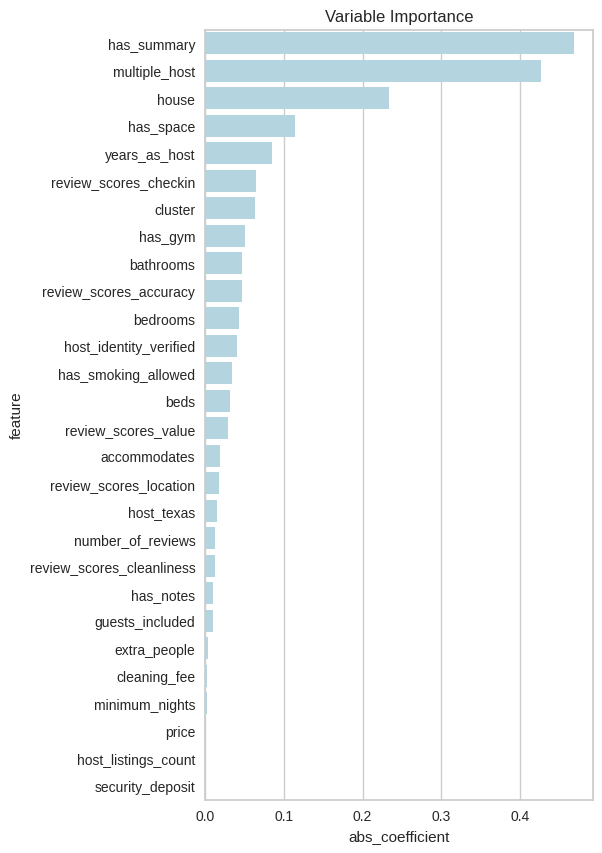

-- rejected --
 has_pool
 host_is_superhost
 has_transit
 has_neighborhood
 has_description
 austin_name
 instant_bookable
 review_scores_rating
 host_has_profile_pic
 review_scores_communication


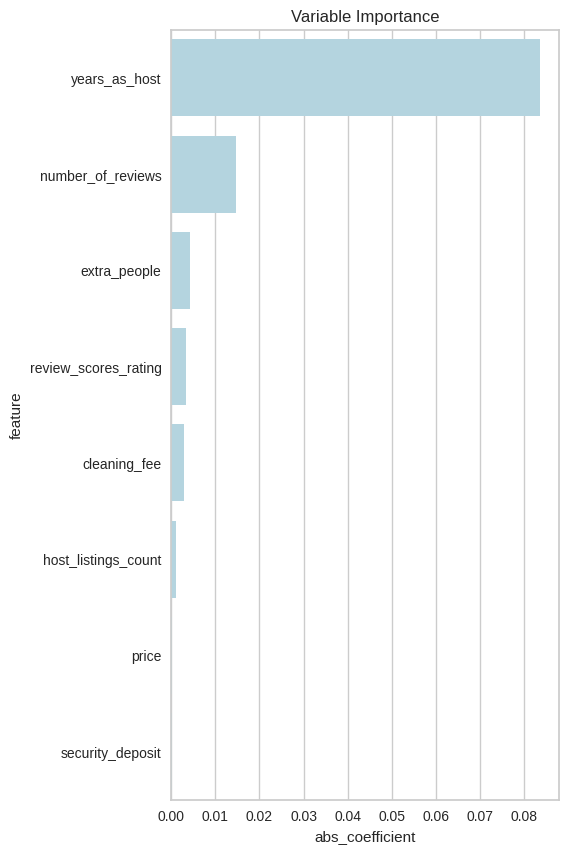

-- rejected --
 host_is_superhost
 has_space
 has_description
 has_neighborhood
 has_notes
 multiple_host
 has_transit
 austin_name
 host_texas
 house
 has_gym
 has_smoking_allowed
 has_pool
 has_summary
 review_scores_communication
 instant_bookable
 review_scores_value
 review_scores_location
 review_scores_checkin
 review_scores_cleanliness
 review_scores_accuracy
 minimum_nights
 guests_included
 beds
 bedrooms
 bathrooms
 accommodates
 host_identity_verified
 host_has_profile_pic
 cluster


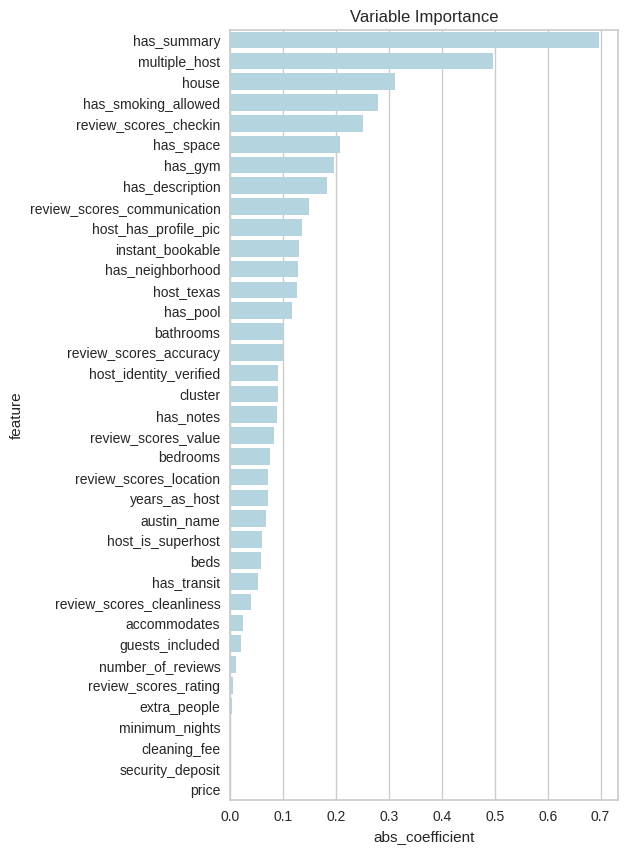

-- rejected --
 host_listings_count


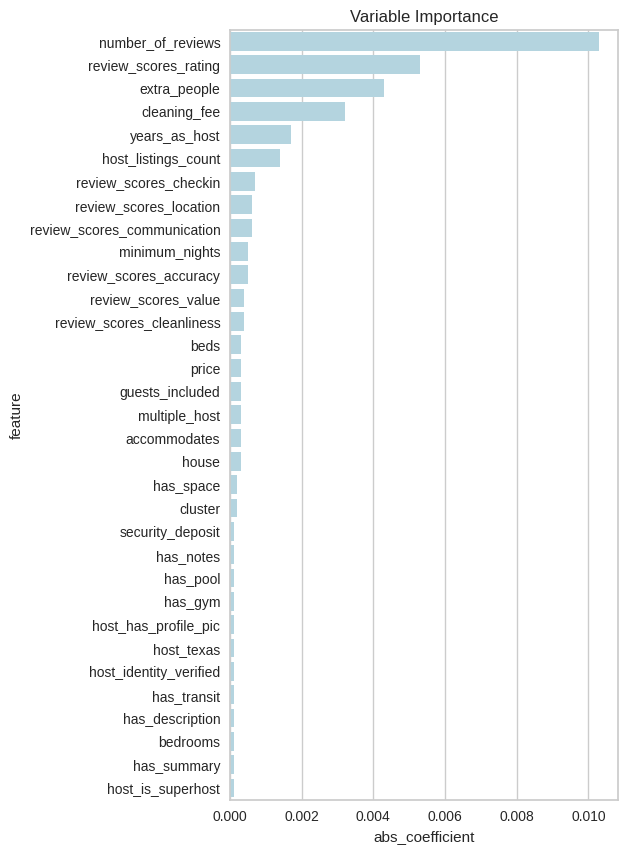

-- rejected --
 instant_bookable
 bathrooms
 has_neighborhood
 has_smoking_allowed
 austin_name


In [ ]:
# plot variable importance
def plot_variable_imp(df_coef):
  df_plt = df_coef[df_coef['abs_coefficient'] != 0]
  reject_vars = df_coef[df_coef['abs_coefficient'] == 0]['feature'].tolist()

  plt.figure(figsize=(5, 10))
  plt.title('Variable Importance')
  plt.xlabel('Coefficient')
  plt.ylabel('Feature')
  sns.barplot(data=df_plt,
                     y=df_plt['feature'],
                     x=df_plt['abs_coefficient'], color="lightblue")

  plt.show()
  print("-- rejected --")
  for i in reject_vars:
    print(f" {i}")

plot_variable_imp(df_coefficients1)
plot_variable_imp(df_coefficients01)
plot_variable_imp(df_coefficients2)
plot_variable_imp(df_coefficients12)

##Create Decision Tree

In [ ]:
# split the data into training and testing sets
X3 = df.drop(['booked'], axis=1)

y3 = df['booked']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.4, random_state=42)

X3_train.info()
y3_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3492 entries, 3967 to 863
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            3492 non-null   int64  
 1   host_listings_count          3492 non-null   float64
 2   host_has_profile_pic         3492 non-null   int64  
 3   host_identity_verified       3492 non-null   int64  
 4   accommodates                 3492 non-null   int64  
 5   bathrooms                    3492 non-null   float64
 6   bedrooms                     3492 non-null   float64
 7   beds                         3492 non-null   float64
 8   price                        3492 non-null   float64
 9   security_deposit             3492 non-null   float64
 10  cleaning_fee                 3492 non-null   float64
 11  guests_included              3492 non-null   int64  
 12  extra_people                 3492 non-null   float64
 13  minimum_nights  

In [ ]:
# create an instance of a decision tree classifier using default values

dt_booked = DecisionTreeClassifier(max_depth = 10, min_samples_leaf=50, ccp_alpha = 0.001)

# fit the model to the training data
dt_booked.fit(X3_train, y3_train)

# this code can be used to produce a textual representation of the tree if desired
#text_rep = tree.export_text(dt_booked)
#print(text_rep)

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=10, min_samples_leaf=50)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(dt_booked, filled=True, rounded=True, feature_names=X3.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree_booked")

'decision_tree_booked.pdf'

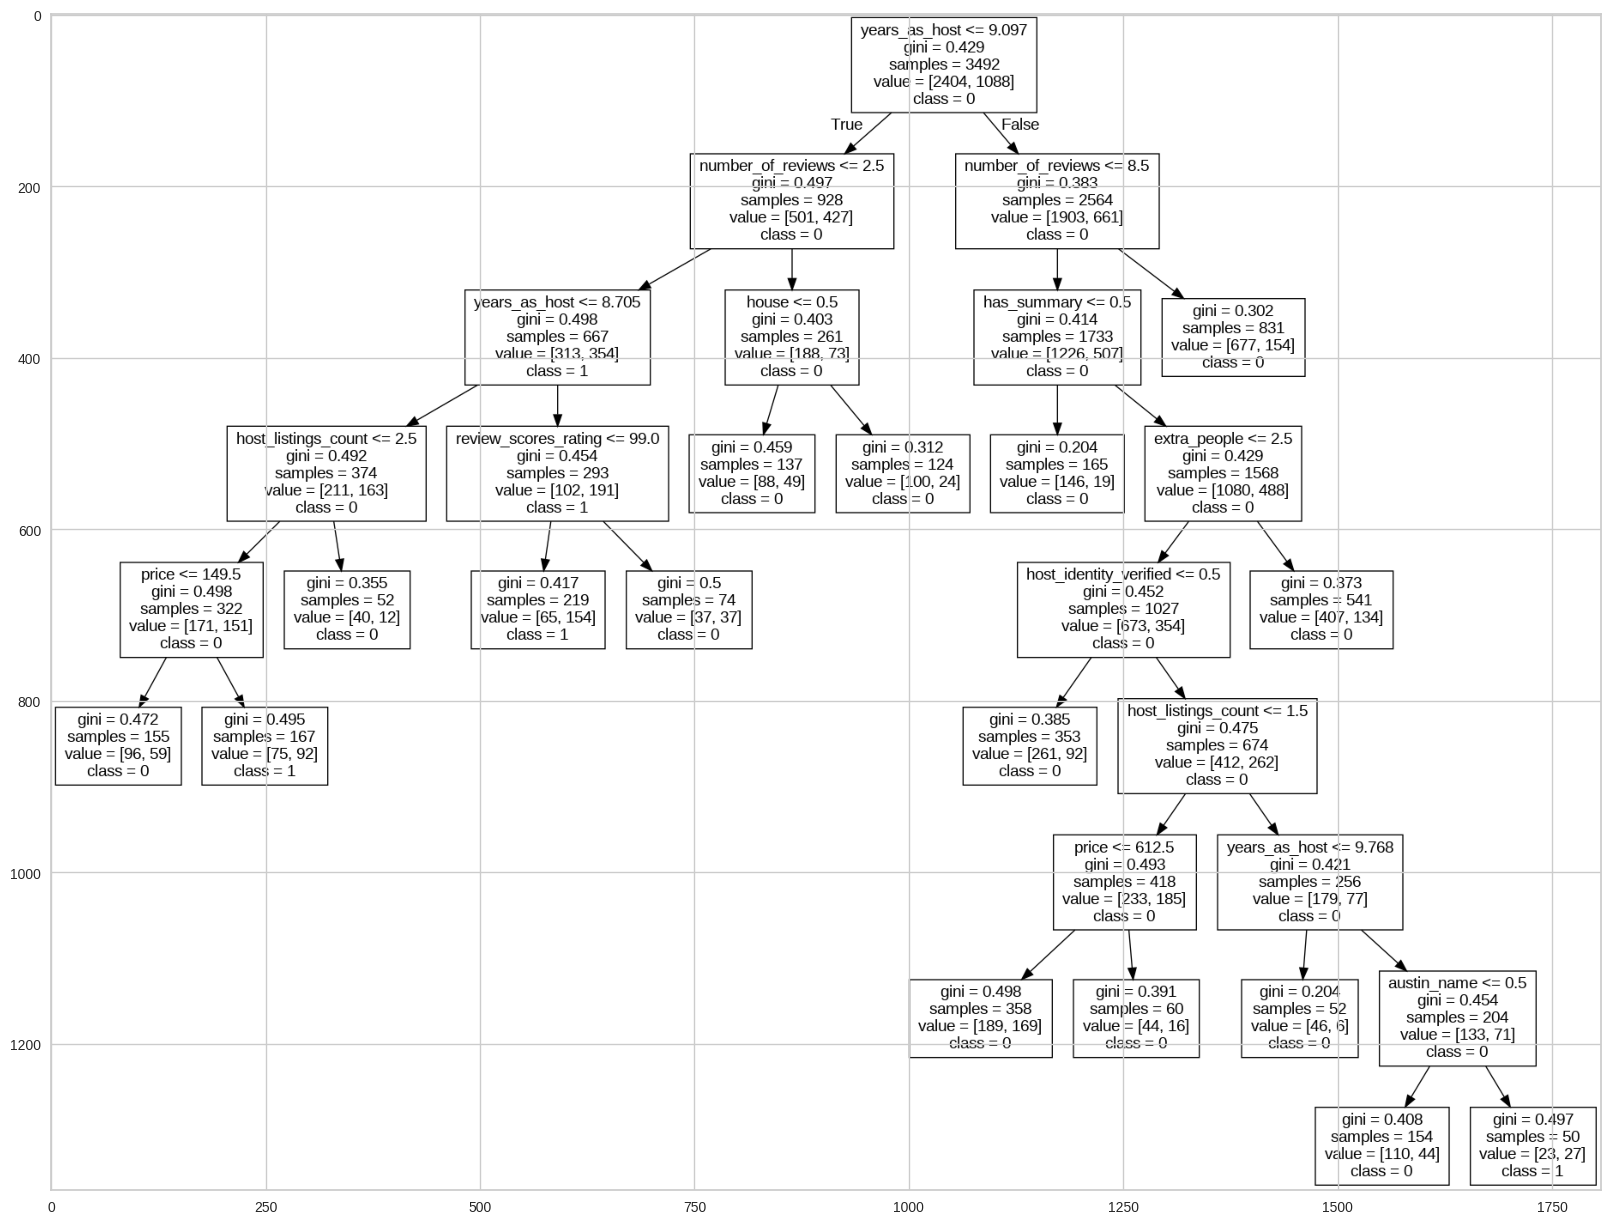

In [ ]:
export_graphviz(dt_booked,
                'tree.dot',
                class_names=['0','1'],
                feature_names = X3_train.columns)
! dot -Tpng tree.dot -o tree.png

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 40))
plt.imshow(img)

In [ ]:
# make predictions on the training and test data
y3_pred_train = dt_booked.predict(X3_train)
y3_pred_test = dt_booked.predict(X3_test)

y3_prob_train = dt_booked.predict_proba(X3_train)
y3_prob_test = dt_booked.predict_proba(X3_test)

###Calculating Accuracy, Precision, and Recall for each set:


In [ ]:
# calculate the accuracy, precision, and recall scores
acc_train3 = accuracy_score(y3_train, y3_pred_train)
prec_train3 = precision_score(y3_train, y3_pred_train)
rec_train3 = recall_score(y3_train, y3_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train3))
print("Precision: {:.4f}".format(prec_train3))
print("Recall.  : {:.4f}".format(rec_train3))
print("")

# calculate the accuracy, precision, and recall scores
acc_test3 = accuracy_score(y3_test, y3_pred_test)
prec_test3 = precision_score(y3_test, y3_pred_test)
rec_test3 = recall_score(y3_test, y3_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test3))
print("Precision: {:.4f}".format(prec_test3))
print("Recall.  : {:.4f}".format(rec_test3))

 -- train set -- 
Accuracy : 0.7199
Precision: 0.6261
Recall.  : 0.2509

 -- test set -- 
Accuracy : 0.7032
Precision: 0.5434
Recall.  : 0.2354


In [ ]:
# confusion matrix
conf_trainbooked3 = confusion_matrix(y3_pred_train, y3_train)
print(conf_trainbooked3)

# Generate confusion matrix for test set
conf_testbooked3 = confusion_matrix(y3_pred_test, y3_test)
print(conf_testbooked3)

[[2241  815]
 [ 163  273]]
[[1468  549]
 [ 142  169]]


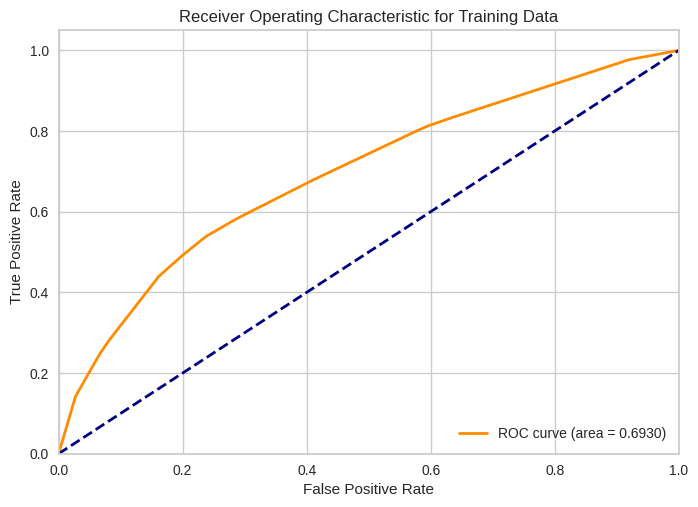

In [ ]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y3_train, y3_prob_train[:,1])
roc_auc = roc_auc_score(y3_train, y3_prob_train[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

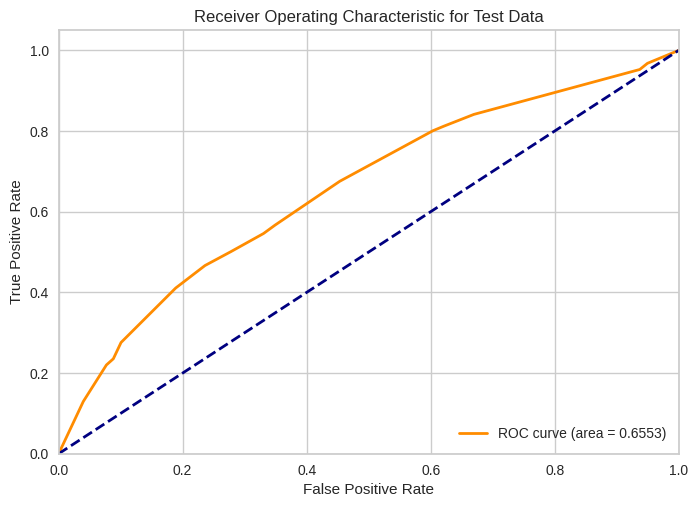

In [ ]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y3_test, y3_prob_test[:,1])
roc_auc = roc_auc_score(y3_test, y3_prob_test[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()


###Variable Importance

In [ ]:
# plot variable importance
def plot_variable_imp(df_coef):
  df_plt = df_coef[df_coef['abs_coefficient'] != 0]
  reject_vars = df_coef[df_coef['abs_coefficient'] == 0]['feature'].tolist()

  plt.figure(figsize=(5, 10))
  plt.title('Variable Importance')
  plt.xlabel('Coefficient')
  plt.ylabel('Feature')
  sns.barplot(data=df_plt,
                     y=df_plt['feature'],
                     x=df_plt['abs_coefficient'], color="lightblue")




    importance                 feature
31    0.441291           years_as_host
14    0.213396       number_of_reviews
24    0.066994             has_summary
1     0.066910     host_listings_count
8     0.052506                   price
3     0.044375  host_identity_verified
12    0.038920            extra_people
23    0.028489             austin_name
15    0.026657    review_scores_rating
33    0.020463                   house
-- rejected --
 has_space
 has_description
 has_neighborhood
 host_is_superhost
 has_notes
 instant_bookable
 multiple_host
 host_texas
 has_gym
 has_smoking_allowed
 has_pool
 has_transit
 review_scores_communication
 review_scores_value
 review_scores_location
 review_scores_checkin
 review_scores_cleanliness
 review_scores_accuracy
 minimum_nights
 guests_included
 cleaning_fee
 security_deposit
 beds
 bedrooms
 bathrooms
 accommodates
 host_has_profile_pic
 cluster


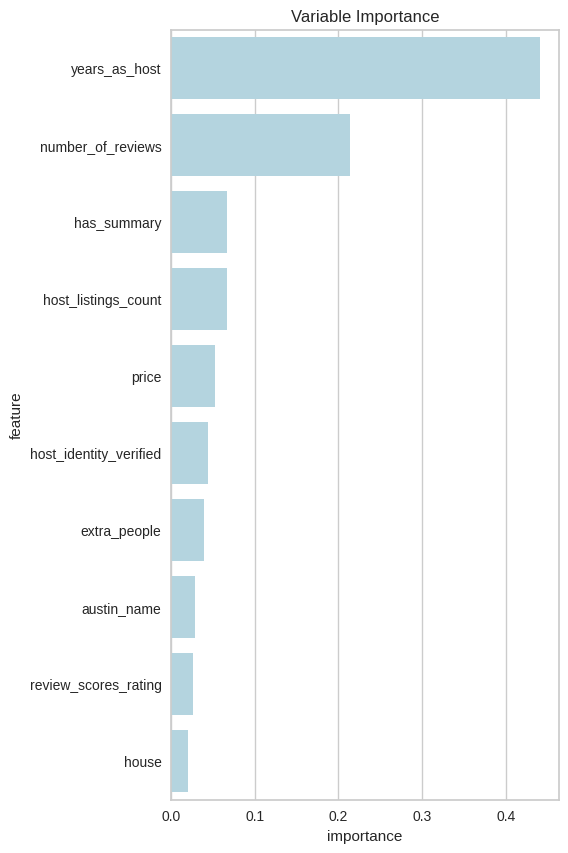

In [ ]:
#calculate feature importance
tree_imp = dt_booked.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df1 = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df1['feature']=X3.columns

#sort data so features with largest importance values are at the top
df2 = df1.sort_values(by=['importance'], ascending=False)

#create a list of rejected variables
importance_threshold = 0.0
rejected_vars = df2[df2['importance'] <= importance_threshold]['feature'].tolist()

#filter the DataFrame to exclude rejected variables
df2 = df2[df2['importance'] > importance_threshold]
print(df2)

#print the rejected variables
print("-- rejected --")
for i in rejected_vars:
    print(f" {i}")

# Create Variable Importance Plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2, y=df2['feature'], x=df2['importance'], color="lightblue")

plt.show()

In [ ]:
#tune parameters of decision tree
dt_tune = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 10, 20, 50, 100, 200],
    'ccp_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(dt_tune, param_grid, cv=5)
grid_search.fit(X3_train, y3_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(best_params)
print(best_estimator)

{'ccp_alpha': 0, 'max_depth': 5, 'min_samples_leaf': 50}
DecisionTreeClassifier(ccp_alpha=0, max_depth=5, min_samples_leaf=50)


##Decision Tree with Best parameters and estimators

In [ ]:
# create an instance of a decision tree classifier using default values

dt_booked2 = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=50, ccp_alpha = 0)

# fit the model to the training data
dt_booked2.fit(X3_train, y3_train)

# this code can be used to produce a textual representation of the tree if desired
#text_rep = tree.export_text(dt_booked2)
#print(text_rep)

DecisionTreeClassifier(ccp_alpha=0, max_depth=5, min_samples_leaf=50)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(dt_booked2, filled=True, rounded=True, feature_names=X3.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree_booked2")

'decision_tree_booked2.pdf'

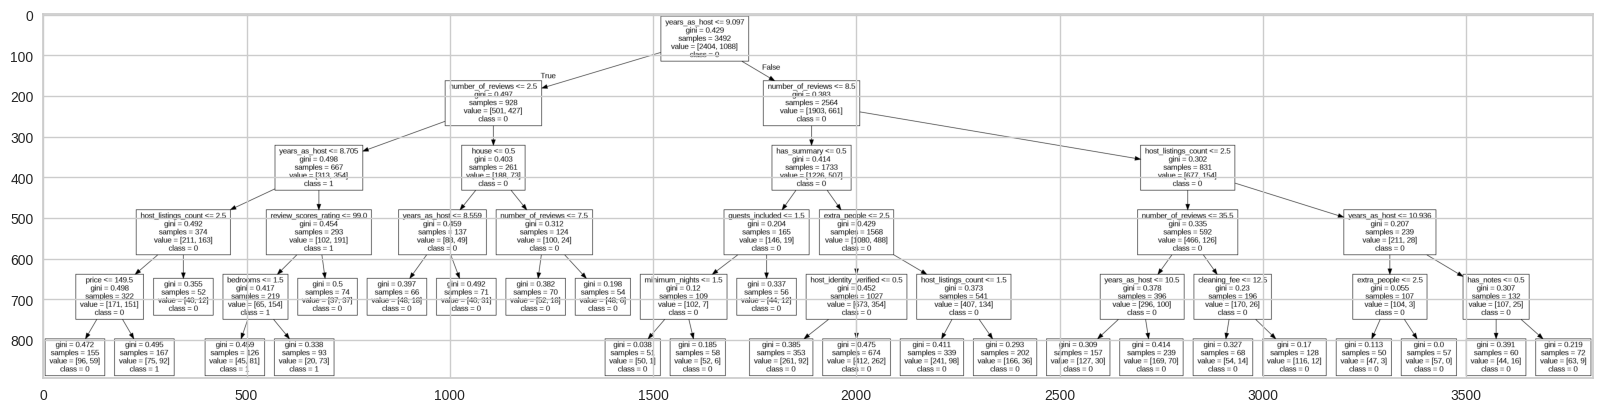

In [ ]:
export_graphviz(dt_booked2,
                'tree.dot',
                class_names=['0','1'],
                feature_names = X3_train.columns)
! dot -Tpng tree.dot -o tree.png

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 40))
plt.imshow(img)

In [ ]:
# make predictions on the training and test data
y3_pred_train = dt_booked2.predict(X3_train)
y3_pred_test = dt_booked2.predict(X3_test)

y3_prob_train = dt_booked2.predict_proba(X3_train)
y3_prob_test = dt_booked2.predict_proba(X3_test)

###Calculating Accuracy, Precision, and Recall for each set:


In [ ]:
# calculate the accuracy, precision, and recall scores
acc_train3 = accuracy_score(y3_train, y3_pred_train)
prec_train3 = precision_score(y3_train, y3_pred_train)
rec_train3 = recall_score(y3_train, y3_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train3))
print("Precision: {:.4f}".format(prec_train3))
print("Recall.  : {:.4f}".format(rec_train3))
print("")

# calculate the accuracy, precision, and recall scores
acc_test3 = accuracy_score(y3_test, y3_pred_test)
prec_test3 = precision_score(y3_test, y3_pred_test)
rec_test3 = recall_score(y3_test, y3_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test3))
print("Precision: {:.4f}".format(prec_test3))
print("Recall.  : {:.4f}".format(rec_test3))

 -- train set -- 
Accuracy : 0.7188
Precision: 0.6373
Recall.  : 0.2261

 -- test set -- 
Accuracy : 0.7062
Precision: 0.5603
Recall.  : 0.2201


In [ ]:
# confusion matrix
conf_trainbooked3 = confusion_matrix(y3_pred_train, y3_train)
print(conf_trainbooked3)

# Generate confusion matrix for test set
conf_testbooked3 = confusion_matrix(y3_pred_test, y3_test)
print(conf_testbooked3)

[[2264  842]
 [ 140  246]]
[[1486  560]
 [ 124  158]]


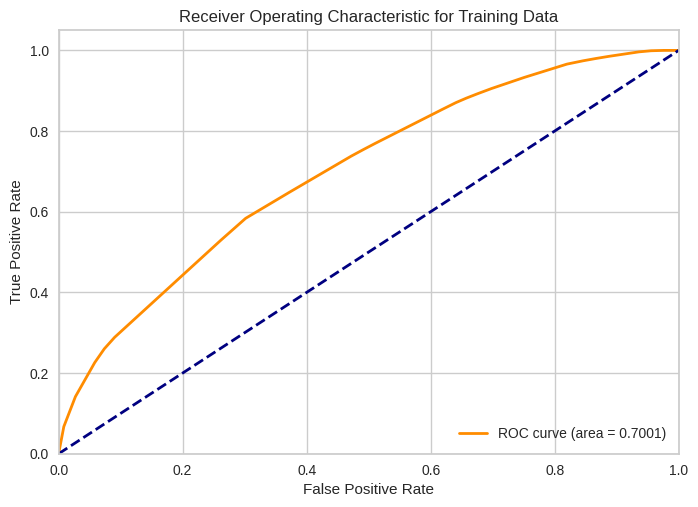

In [ ]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y3_train, y3_prob_train[:,1])
roc_auc = roc_auc_score(y3_train, y3_prob_train[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

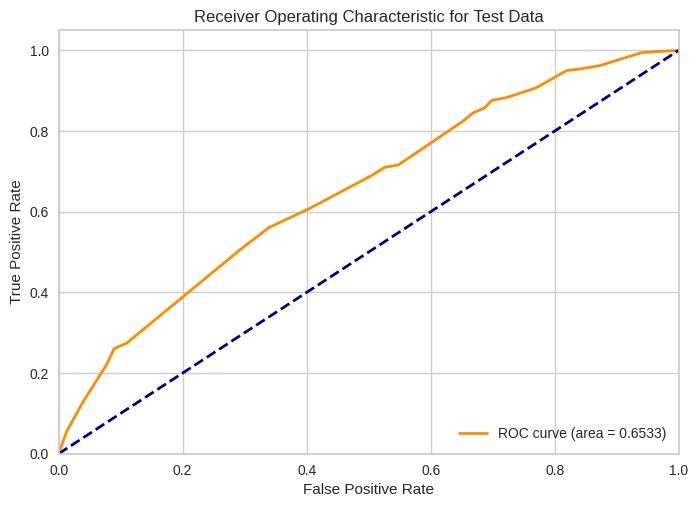

In [ ]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y3_test, y3_prob_test[:,1])
roc_auc = roc_auc_score(y3_test, y3_prob_test[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()


###Variable Importance

    importance                 feature
31    0.442553           years_as_host
14    0.236194       number_of_reviews
24    0.065125             has_summary
1     0.064159     host_listings_count
3     0.043137  host_identity_verified
12    0.038922            extra_people
8     0.026440                   price
15    0.025913    review_scores_rating
33    0.019892                   house
6     0.012258                bedrooms
11    0.009453         guests_included
28    0.007453               has_notes
10    0.006336            cleaning_fee
13    0.002165          minimum_nights
-- rejected --
 has_transit
 has_neighborhood
 has_description
 host_is_superhost
 multiple_host
 host_texas
 has_gym
 has_smoking_allowed
 has_pool
 has_space
 review_scores_communication
 austin_name
 instant_bookable
 review_scores_value
 review_scores_location
 review_scores_checkin
 review_scores_cleanliness
 review_scores_accuracy
 security_deposit
 beds
 bathrooms
 accommodates
 host_has_profile_pic
 clus

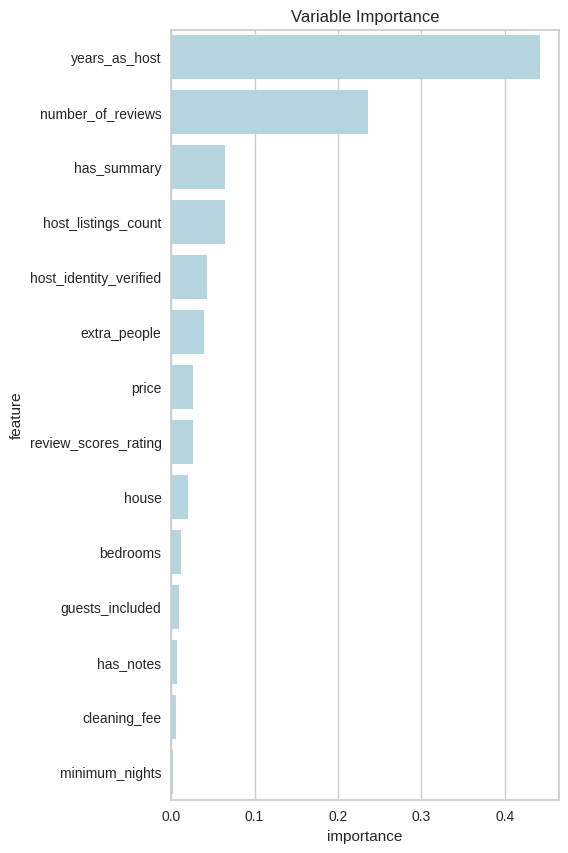

In [ ]:
#calculate feature importance
tree_imp = dt_booked2.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df3 = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df3['feature']=X3.columns

#sort data so features with largest importance values are at the top
df4 = df3.sort_values(by=['importance'], ascending=False)

#create a list of rejected variables
importance_threshold = 0.0
rejected_vars = df4[df4['importance'] <= importance_threshold]['feature'].tolist()

#filter the DataFrame to exclude rejected variables
df4 = df4[df4['importance'] > importance_threshold]
print(df4)

#print the rejected variables
print("-- rejected --")
for i in rejected_vars:
    print(f" {i}")

# Create Variable Importance Plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df4, y=df4['feature'], x=df4['importance'], color="lightblue")

plt.show()

#More Exploration on Reviews

In [ ]:
q3_columns = ['number_of_reviews',
              'review_scores_rating',
              'review_scores_accuracy',
              'review_scores_cleanliness',
              'review_scores_checkin',
              'review_scores_communication',
              'review_scores_location',
              'review_scores_value']

In [ ]:
tree_imp

array([0.        , 0.06415939, 0.        , 0.04313683, 0.        ,
       0.        , 0.01225776, 0.        , 0.02644006, 0.        ,
       0.00633585, 0.00945307, 0.03892181, 0.00216451, 0.23619437,
       0.02591316, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.06512494,
       0.        , 0.        , 0.        , 0.0074529 , 0.        ,
       0.        , 0.44255312, 0.        , 0.01989222, 0.        ,
       0.        , 0.        , 0.        ])

In [ ]:
df4

importance                 feature
31    0.442553           years_as_host
14    0.236194       number_of_reviews
24    0.065125             has_summary
1     0.064159     host_listings_count
3     0.043137  host_identity_verified
12    0.038922            extra_people
8     0.026440                   price
15    0.025913    review_scores_rating
33    0.019892                   house
6     0.012258                bedrooms
11    0.009453         guests_included
28    0.007453               has_notes
10    0.006336            cleaning_fee
13    0.002165          minimum_nights

In [ ]:
simplified_df = df4[df4['feature'].str.contains('review')]
simplified_df

importance               feature
14    0.236194     number_of_reviews
15    0.025913  review_scores_rating

    importance                      feature
14    0.236194            number_of_reviews
15    0.025913         review_scores_rating
19    0.000000  review_scores_communication
21    0.000000          review_scores_value
20    0.000000       review_scores_location
18    0.000000        review_scores_checkin
17    0.000000    review_scores_cleanliness
16    0.000000       review_scores_accuracy
-- rejected --
 review_scores_communication
 review_scores_value
 review_scores_location
 review_scores_checkin
 review_scores_cleanliness
 review_scores_accuracy


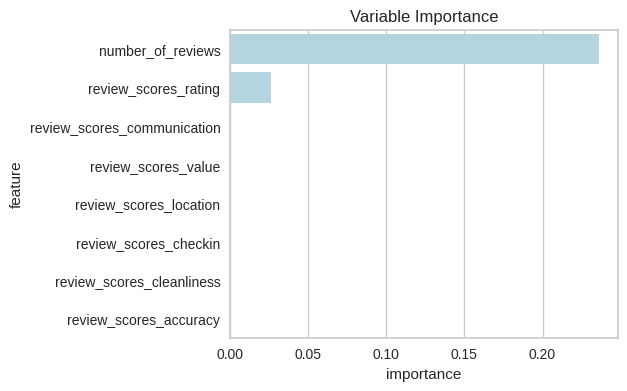

In [ ]:
#calculate feature importance
tree_imp = dt_booked2.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df3 = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df3['feature'] = X3.columns

#sort data so features with largest importance values are at the top
df4 = df3.sort_values(by=['importance'], ascending=False)

#create a list of rejected variables
importance_threshold = 0.0
simplified_df = df4[df4['feature'].str.contains('review')]
rejected_vars = simplified_df[simplified_df['importance'] <= importance_threshold]['feature'].tolist()

#filter the DataFrame to exclude rejected variables
simplifeid_df = simplified_df[simplified_df['importance'] > importance_threshold]
print(simplified_df)

#print the rejected variables
print("-- rejected --")
for i in rejected_vars:
    print(f" {i}")

# Create Variable Importance Plot
plt.figure(figsize=(5, 4))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data = simplified_df, y = simplified_df['feature'], x = simplified_df['importance'], color="lightblue")

plt.show()

In [ ]:
#download to html
!jupyter nbconvert --to html '/content/AirbnbinAustin_Bellamy_Vickers.ipynb'

[NbConvertApp] Converting notebook /content/AirbnbinAustin_Bellamy_Vickers.ipynb to html
[NbConvertApp] Writing 7549272 bytes to /content/AirbnbinAustin_Bellamy_Vickers.html
